### This notebook trains proteinVI unshared, totalvi shared, and rna unshared on protein_unshared, protein shared, rna shared and rna_unshared

This notebook also train the models in a criss cross manner too.

In [36]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
import anndata as ad
import scanpy as sc
import torch
import random

In [37]:
def set_random_seed():
    # Example usage:
    seed = 42
    # Set seed for random module
    random.seed(seed)

    # Set seed for numpy
    np.random.seed(seed)

    # Set seed for torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_random_seed()

In [38]:
# read in protein data
protein = pd.read_csv("data/citeseq_pbmc/pro.csv") # 10k cells (protein)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns

# read in celltyle labels
metadata = pd.read_csv('data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

protein_adata.obs['celltype.l1'] = labels_l1
protein_adata.obs['celltype.l2'] = labels_l2

print("Final stats of protein adata: \n",protein_adata)

Final stats of protein adata: 
 AnnData object with n_obs × n_vars = 10000 × 224
    obs: 'celltype.l1', 'celltype.l2'


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [39]:
# read in RNA data
rna = mmread("./data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('./data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

# read in celltyle labels
metadata = pd.read_csv('./data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [40]:
rna_protein_correspondence = []
correspondence = pd.read_csv('data/protein_gene_conversion.csv')
for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)
print("Number of correspondence matches: ", rna_protein_correspondence.shape)
shared_gene_names_repeated = rna_protein_correspondence.T[0]
shared_protein_names_repeated = rna_protein_correspondence.T[1]
print("Unique shared gene names: {}, Unique shared protein names: {}".format(len(np.unique(shared_gene_names_repeated)), len(np.unique(shared_protein_names_repeated))))

Number of correspondence matches:  (180, 2)
Unique shared gene names: 170, Unique shared protein names: 170


In [41]:
shared_gene_features = list(set(shared_gene_names_repeated))
print("Final shared RNA: ",len(shared_gene_features))
shared_protein_features = list(set(shared_protein_names_repeated))
print("Final share protein: ", len(shared_protein_features))

rna_adata_copy = rna_adata.copy()
sc.pp.normalize_total(rna_adata_copy)
sc.pp.log1p(rna_adata_copy)
sc.pp.highly_variable_genes(rna_adata_copy, n_top_genes=2000)

highly_var_genes = list(set(rna_adata.var_names[rna_adata_copy.var.highly_variable==True]))
highly_var_genes_filtered = [gene for gene in highly_var_genes if gene not in shared_gene_features]

unshared_protein_features = [protein for protein in protein_adata.var_names if protein not in shared_protein_features]
print("Unshared protein features: ", len(unshared_protein_features))
print("variable genes that are not shared: ", len(highly_var_genes_filtered))

Final shared RNA:  170
Final share protein:  170


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


Unshared protein features:  54
variable genes that are not shared:  1911


In [42]:
def get_indices(feature_names, all_feature_names):
    """Returns the indices of features in 'feature_names' within the 'all_feature_names' list.

    Args:
        feature_names: A list of feature names to find indices for.
        all_feature_names: The complete list of all feature names.

    Returns:
        A list of indices corresponding to the positions of the 'feature_names' 
        within the 'all_feature_names' list. If a feature is not found, its index
        will be -1.
    """
    indices = []
    for feature in feature_names:
        try:
            index = all_feature_names.index(feature)
        except ValueError:
            index = -1  # Feature not found
        indices.append(index)
    return indices

In [43]:
unshared_gene_indices = get_indices(highly_var_genes_filtered, rna_adata.var_names.to_list())
shared_gene_indices = get_indices(shared_gene_names_repeated, rna_adata.var_names.to_list())
unshared_protein_indices = get_indices(unshared_protein_features, protein_adata.var_names.to_list())
shared_protein_indices = get_indices(shared_protein_names_repeated, protein_adata.var_names.to_list())

print("Length of unshared_gene_indices:", len(unshared_gene_indices))
print("Length of shared_gene_indices:", len(shared_gene_indices))
print("Length of unshared_protein_indices:", len(unshared_protein_indices))
print("Length of shared_protein_indices:", len(shared_protein_indices))

# Convert index lists to sets for unique element calculation
unshared_gene_unique = set(unshared_gene_indices)
shared_gene_unique = set(shared_gene_indices)
unshared_protein_unique = set(unshared_protein_indices)
shared_protein_unique = set(shared_protein_indices)

# Print lengths of unique elements
print("Unique elements in unshared_gene_indices:", len(unshared_gene_unique))
print("Unique elements in shared_gene_indices:", len(shared_gene_unique))
print("Unique elements in unshared_protein_indices:", len(unshared_protein_unique))
print("Unique elements in shared_protein_indices:", len(shared_protein_unique))

Length of unshared_gene_indices: 1911
Length of shared_gene_indices: 180
Length of unshared_protein_indices: 54
Length of shared_protein_indices: 180
Unique elements in unshared_gene_indices: 1911
Unique elements in shared_gene_indices: 170
Unique elements in unshared_protein_indices: 54
Unique elements in shared_protein_indices: 170


In [44]:
rna_unshared_adata = rna_adata[:,unshared_gene_indices]
rna_shared_adata = rna_adata[:,shared_gene_indices]
protein_unshared_adata = protein_adata[:,unshared_protein_indices]
protein_shared_adata = protein_adata[:,shared_protein_indices]

In [45]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class ProteinDataset(Dataset):
    def __init__(self,unshared_protein_adata, shared_protein_adata):
        self.unshared_data = np.asarray(unshared_protein_adata.X)
        self.shared_data = np.asarray(shared_protein_adata.X)
        self.labels_l1 = protein_adata.obs['celltype.l1']
        self.labels_l2 = protein_adata.obs['celltype.l2']
        self.batch = np.array([1.0]*self.unshared_data.shape[0]).reshape((-1,1)).astype(np.float32)
        
    def __len__(self):
        return self.unshared_data.shape[0]

    def __getitem__(self, idx):
        return {"y_unshared":self.unshared_data[idx], "y_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "batch": self.batch[idx]}

protein_dataset = ProteinDataset(protein_unshared_adata, protein_shared_adata)
protein_dataloader = DataLoader(protein_dataset, batch_size=256, shuffle=True)

In [46]:
class RNADataset(Dataset):
    def __init__(self,unshared_rna_adata, shared_rna_adata):
        self.unshared_data = np.asarray(unshared_rna_adata.X.todense())
        self.shared_data = np.asarray(shared_rna_adata.X.todense())
        self.labels_l1 = rna_adata.obs['celltype.l1']
        self.labels_l2 = rna_adata.obs['celltype.l2']
        self.local_mean, self.local_var = self.compute_library_size(np.concatenate([self.unshared_data, self.shared_data],axis=1))
        self.local_mean = np.array([self.local_mean]*self.unshared_data.shape[0])
        self.local_var = np.array([self.local_var]*self.unshared_data.shape[0])
        self.batch = np.array([0.0]*self.unshared_data.shape[0]).reshape((-1,1)).astype(np.float32)
        
    def __len__(self):
        return self.unshared_data.shape[0]

    def __getitem__(self, idx):
        return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
    
    def compute_library_size(self, data):
        # print(data.shape)
        sum_counts = data.sum(axis=1)
        masked_log_sum = np.ma.log(sum_counts)
        if np.ma.is_masked(masked_log_sum):
            print(
                "Warning: This dataset has some empty cells, this might fail scVI inference. Data should be filtered with `my_dataset.filter_cells_by_count()"
            )
        log_counts = masked_log_sum.filled(0)
        local_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)
        local_var = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)

        local_mean = torch.Tensor(local_mean).reshape(-1)
        local_var = torch.Tensor(local_var).reshape(-1)
        return local_mean, local_var

rna_dataset = RNADataset(rna_unshared_adata, rna_shared_adata)
rna_dataloader = DataLoader(rna_dataset, batch_size=256, shuffle=True)

In [47]:
def l2_normalize_batch_pytorch(batch):
    norm = torch.norm(batch, dim=1, keepdim=True)
    normalized_batch = batch / norm
    return normalized_batch
    
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

def CLIP_loss(rna_total,rna_unshared):
    
    text_embeddings = l2_normalize_batch_pytorch(rna_total)
    image_embeddings = l2_normalize_batch_pytorch(rna_unshared)
    temperature = 1.0
    logits = (text_embeddings @ image_embeddings.T) 
    images_similarity = image_embeddings @ image_embeddings.T
    texts_similarity = text_embeddings @ text_embeddings.T
    targets = F.softmax(
        (images_similarity + texts_similarity) / 2, dim=-1
    )
    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 
    return loss.mean()

In [48]:
Unshared_protein_loss = []
Unshared_rna_loss = []
Shared_loss = []
loss_emb_p = []
loss_emb_r = []

final_unshared_protein_loss = 0.0
final_unshared_rna_loss = 0.0
final_shared_loss = 0.0
final_loss_emb_p = 0.0
final_loss_emb_r = 0.0

In [49]:
def get_paras_for_podel(para_out_prodel, gene_size):
    para = {}
    para["qz_m"] = para_out_prodel["qz_m"][gene_size:]
    para["qz_v"] = para_out_prodel["qz_v"][gene_size:]
    para["z_protein"] = para_out_prodel["z_protein"]
    para["untran_z"] = para_out_prodel["untran_z"][gene_size:]
    return para

def get_paras_for_rodel(para_out_prodel, gene_size):
    para = {}
    para["qz_m"] = para_out_prodel["qz_m"][:gene_size]
    para["qz_v"] = para_out_prodel["qz_v"][:gene_size]
    para["z_gene"] = para_out_prodel["z_gene"]
    para["ql_m"] = para_out_prodel["ql_m"][:gene_size]
    para["ql_v"] = para_out_prodel["ql_v"][:gene_size]
    para["l"] = para_out_prodel["l"][:gene_size]
    return para

def get_paras_for_prodel(para_out_rodel, para_out_podel, gene_size):
    para = {}
    para["qz_m"] = torch.cat([para_out_rodel["qz_m"], para_out_podel["qz_m"]], dim=0)
    para["qz_v"] = torch.cat([para_out_rodel["qz_v"], para_out_podel["qz_v"]], dim=0)    
    para["ql_m"] = torch.cat([para_out_rodel["ql_m"], torch.zeros_like(para_out_rodel["ql_m"])], dim=0)
    para["ql_v"] = torch.cat([para_out_rodel["ql_v"], torch.zeros_like(para_out_rodel["ql_v"])], dim=0)
    para["z_gene"] = para_out_rodel["z_gene"]
    para["z_protein"] = para_out_podel["z_protein"]
    para["l"] = torch.cat([para_out_rodel["l"], torch.zeros_like(para_out_rodel["l"])], dim=0)
    para["untran_z"] = torch.cat([torch.zeros_like(para_out_podel["untran_z"]), para_out_podel["untran_z"]], dim=0)
    para["untran_l"] = torch.cat([para_out_rodel["l"], torch.zeros_like(para_out_rodel["l"])], dim=0)
    return para

In [50]:
from scvi.models.proteinvi_unshared_cross import PROTENVI_UNSHARED_CROSS
from scvi.models.rna_unshared_cross import RNA_UNSHARED_CROSS
from scvi.models.totalvi_shared_cross import TOTALVI_SHARED_CROSS
import torch.nn.functional as F
import torch.nn as nn
import metrics.match_utils as mu

podel = PROTENVI_UNSHARED_CROSS(54, latent_distribution="normal", log_variational=True)
prodel = TOTALVI_SHARED_CROSS(180, latent_distribution="normal", log_variational=True, reconstruction_loss_gene = "zinb")
rodel = RNA_UNSHARED_CROSS(1911, latent_distribution="normal", log_variational=True, reconstruction_loss="zinb")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device used for training is: ", device)
podel.to(device)
prodel.to(device)
rodel.to(device)
prodel_params = filter(lambda p: p.requires_grad, prodel.parameters())
podel_params = filter(lambda p: p.requires_grad, podel.parameters())
rodel_params = filter(lambda p: p.requires_grad, rodel.parameters())

optimizer_p = torch.optim.Adam(podel_params, lr=0.001, eps=0.01)
optimizer_r = torch.optim.Adam(rodel_params, lr=0.001, eps=0.01)
optimizer_pr = torch.optim.Adam(prodel_params, lr=0.001, eps=0.01)

The device used for training is:  cpu


Epoch: 0: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 0: 40it [00:06,  6.01it/s]


RNA Recon Loss: 4.1172, RNA KL Div L: 0.0117, RNA KL Div Z: 0.3467, Protein Recon Loss: 0.5807, Protein KL Div Back Pro: 1.7196, Protein KL Div Z: 0.3081, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.3666, Shared Recon Loss Gene: 0.3676, Shared Recon Loss Protein: 2.0729 Cross Loss Protein: 0.0000


Epoch: 1: 40it [00:06,  6.11it/s]


RNA Recon Loss: 3.8704, RNA KL Div L: 0.0121, RNA KL Div Z: 0.3611, Protein Recon Loss: 0.5775, Protein KL Div Back Pro: 1.6694, Protein KL Div Z: 0.3215, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.3924, Shared Recon Loss Gene: 0.3613, Shared Recon Loss Protein: 2.0579 Cross Loss Protein: 0.0000


Epoch: 2: 40it [00:08,  4.97it/s]


RNA Recon Loss: 3.8702, RNA KL Div L: 0.0121, RNA KL Div Z: 0.3718, Protein Recon Loss: 0.5743, Protein KL Div Back Pro: 1.6012, Protein KL Div Z: 0.3368, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4183, Shared Recon Loss Gene: 0.3571, Shared Recon Loss Protein: 2.0461 Cross Loss Protein: 0.5930


Epoch: 3: 40it [00:07,  5.00it/s]


RNA Recon Loss: 4.3561, RNA KL Div L: 0.0137, RNA KL Div Z: 0.3834, Protein Recon Loss: 0.5707, Protein KL Div Back Pro: 1.5341, Protein KL Div Z: 0.3608, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4404, Shared Recon Loss Gene: 0.3535, Shared Recon Loss Protein: 2.0387 Cross Loss Protein: 0.5884


Epoch: 4: 40it [00:07,  5.00it/s]


RNA Recon Loss: 4.0740, RNA KL Div L: 0.0178, RNA KL Div Z: 0.3871, Protein Recon Loss: 0.5666, Protein KL Div Back Pro: 1.4726, Protein KL Div Z: 0.3815, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4632, Shared Recon Loss Gene: 0.3495, Shared Recon Loss Protein: 2.0294 Cross Loss Protein: 0.5858


Epoch: 5: 40it [00:08,  4.98it/s]


RNA Recon Loss: 4.0029, RNA KL Div L: 0.0138, RNA KL Div Z: 0.3954, Protein Recon Loss: 0.5628, Protein KL Div Back Pro: 1.4191, Protein KL Div Z: 0.4000, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4847, Shared Recon Loss Gene: 0.3478, Shared Recon Loss Protein: 2.0239 Cross Loss Protein: 0.5831


Epoch: 6: 40it [00:08,  4.94it/s]


RNA Recon Loss: 3.5783, RNA KL Div L: 0.0140, RNA KL Div Z: 0.3989, Protein Recon Loss: 0.5602, Protein KL Div Back Pro: 1.3686, Protein KL Div Z: 0.4164, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5024, Shared Recon Loss Gene: 0.3448, Shared Recon Loss Protein: 2.0195 Cross Loss Protein: 0.5815


Epoch: 7: 40it [00:08,  4.93it/s]


RNA Recon Loss: 3.4313, RNA KL Div L: 0.0120, RNA KL Div Z: 0.4005, Protein Recon Loss: 0.5566, Protein KL Div Back Pro: 1.3342, Protein KL Div Z: 0.4291, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5181, Shared Recon Loss Gene: 0.3436, Shared Recon Loss Protein: 2.0133 Cross Loss Protein: 0.5792


Epoch: 8: 40it [00:08,  4.91it/s]


RNA Recon Loss: 3.4540, RNA KL Div L: 0.0127, RNA KL Div Z: 0.4063, Protein Recon Loss: 0.5550, Protein KL Div Back Pro: 1.2940, Protein KL Div Z: 0.4402, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5318, Shared Recon Loss Gene: 0.3404, Shared Recon Loss Protein: 2.0095 Cross Loss Protein: 0.5792


Epoch: 9: 40it [00:08,  4.86it/s]


RNA Recon Loss: 3.4180, RNA KL Div L: 0.0130, RNA KL Div Z: 0.4087, Protein Recon Loss: 0.5519, Protein KL Div Back Pro: 1.2676, Protein KL Div Z: 0.4521, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5451, Shared Recon Loss Gene: 0.3384, Shared Recon Loss Protein: 2.0043 Cross Loss Protein: 0.5773


Epoch: 10: 40it [00:08,  4.87it/s]


RNA Recon Loss: 3.5362, RNA KL Div L: 0.0133, RNA KL Div Z: 0.4139, Protein Recon Loss: 0.5495, Protein KL Div Back Pro: 1.2385, Protein KL Div Z: 0.4636, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5589, Shared Recon Loss Gene: 0.3376, Shared Recon Loss Protein: 1.9994 Cross Loss Protein: 0.5761


Epoch: 11: 40it [00:08,  4.88it/s]


RNA Recon Loss: 3.7886, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4144, Protein Recon Loss: 0.5475, Protein KL Div Back Pro: 1.2143, Protein KL Div Z: 0.4751, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5696, Shared Recon Loss Gene: 0.3350, Shared Recon Loss Protein: 1.9972 Cross Loss Protein: 0.5749


Epoch: 12: 40it [00:08,  4.85it/s]


RNA Recon Loss: 3.7043, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4185, Protein Recon Loss: 0.5473, Protein KL Div Back Pro: 1.1933, Protein KL Div Z: 0.4848, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5796, Shared Recon Loss Gene: 0.3335, Shared Recon Loss Protein: 1.9953 Cross Loss Protein: 0.5756


Epoch: 13: 40it [00:08,  4.81it/s]


RNA Recon Loss: 3.3808, RNA KL Div L: 0.0143, RNA KL Div Z: 0.4190, Protein Recon Loss: 0.5453, Protein KL Div Back Pro: 1.1664, Protein KL Div Z: 0.4918, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5879, Shared Recon Loss Gene: 0.3320, Shared Recon Loss Protein: 1.9909 Cross Loss Protein: 0.5746


Epoch: 14: 40it [00:08,  4.86it/s]


RNA Recon Loss: 3.1912, RNA KL Div L: 0.0136, RNA KL Div Z: 0.4208, Protein Recon Loss: 0.5422, Protein KL Div Back Pro: 1.1508, Protein KL Div Z: 0.4988, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5947, Shared Recon Loss Gene: 0.3305, Shared Recon Loss Protein: 1.9861 Cross Loss Protein: 0.5723


Epoch: 15: 40it [00:08,  4.83it/s]


RNA Recon Loss: 3.7245, RNA KL Div L: 0.0146, RNA KL Div Z: 0.4216, Protein Recon Loss: 0.5406, Protein KL Div Back Pro: 1.1361, Protein KL Div Z: 0.5064, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6008, Shared Recon Loss Gene: 0.3295, Shared Recon Loss Protein: 1.9820 Cross Loss Protein: 0.5717


Epoch: 16: 40it [00:08,  4.80it/s]


RNA Recon Loss: 3.4174, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4239, Protein Recon Loss: 0.5373, Protein KL Div Back Pro: 1.1206, Protein KL Div Z: 0.5153, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6087, Shared Recon Loss Gene: 0.3275, Shared Recon Loss Protein: 1.9777 Cross Loss Protein: 0.5693


Epoch: 17: 40it [00:08,  4.74it/s]


RNA Recon Loss: 3.4431, RNA KL Div L: 0.0146, RNA KL Div Z: 0.4250, Protein Recon Loss: 0.5354, Protein KL Div Back Pro: 1.1080, Protein KL Div Z: 0.5236, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6147, Shared Recon Loss Gene: 0.3264, Shared Recon Loss Protein: 1.9743 Cross Loss Protein: 0.5681


Epoch: 18: 40it [00:08,  4.79it/s]


RNA Recon Loss: 3.2668, RNA KL Div L: 0.0138, RNA KL Div Z: 0.4268, Protein Recon Loss: 0.5375, Protein KL Div Back Pro: 1.0973, Protein KL Div Z: 0.5289, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6205, Shared Recon Loss Gene: 0.3270, Shared Recon Loss Protein: 1.9744 Cross Loss Protein: 0.5709


Epoch: 19: 40it [00:08,  4.80it/s]


RNA Recon Loss: 4.0832, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4276, Protein Recon Loss: 0.5344, Protein KL Div Back Pro: 1.0802, Protein KL Div Z: 0.5337, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6231, Shared Recon Loss Gene: 0.3243, Shared Recon Loss Protein: 1.9716 Cross Loss Protein: 0.5683


Epoch: 20: 40it [00:08,  4.79it/s]


RNA Recon Loss: 3.5371, RNA KL Div L: 0.0204, RNA KL Div Z: 0.4286, Protein Recon Loss: 0.5323, Protein KL Div Back Pro: 1.0727, Protein KL Div Z: 0.5422, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6298, Shared Recon Loss Gene: 0.3222, Shared Recon Loss Protein: 1.9667 Cross Loss Protein: 0.5659


Epoch: 21: 40it [00:08,  4.77it/s]


RNA Recon Loss: 3.2451, RNA KL Div L: 0.0144, RNA KL Div Z: 0.4298, Protein Recon Loss: 0.5311, Protein KL Div Back Pro: 1.0633, Protein KL Div Z: 0.5482, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6353, Shared Recon Loss Gene: 0.3215, Shared Recon Loss Protein: 1.9657 Cross Loss Protein: 0.5661


Epoch: 22: 40it [00:08,  4.66it/s]


RNA Recon Loss: 3.2203, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4303, Protein Recon Loss: 0.5296, Protein KL Div Back Pro: 1.0590, Protein KL Div Z: 0.5551, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6377, Shared Recon Loss Gene: 0.3202, Shared Recon Loss Protein: 1.9648 Cross Loss Protein: 0.5656


Epoch: 23: 40it [00:08,  4.58it/s]


RNA Recon Loss: 3.4045, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4318, Protein Recon Loss: 0.5294, Protein KL Div Back Pro: 1.0519, Protein KL Div Z: 0.5627, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6458, Shared Recon Loss Gene: 0.3206, Shared Recon Loss Protein: 1.9626 Cross Loss Protein: 0.5656


Epoch: 24: 40it [00:08,  4.58it/s]


RNA Recon Loss: 3.3140, RNA KL Div L: 0.0174, RNA KL Div Z: 0.4297, Protein Recon Loss: 0.5277, Protein KL Div Back Pro: 1.0441, Protein KL Div Z: 0.5670, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6474, Shared Recon Loss Gene: 0.3174, Shared Recon Loss Protein: 1.9599 Cross Loss Protein: 0.5647


Epoch: 25: 40it [00:08,  4.49it/s]


RNA Recon Loss: 3.3475, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4306, Protein Recon Loss: 0.5279, Protein KL Div Back Pro: 1.0320, Protein KL Div Z: 0.5674, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6476, Shared Recon Loss Gene: 0.3162, Shared Recon Loss Protein: 1.9569 Cross Loss Protein: 0.5650


Epoch: 26: 40it [00:08,  4.69it/s]


RNA Recon Loss: 3.3606, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4334, Protein Recon Loss: 0.5251, Protein KL Div Back Pro: 1.0301, Protein KL Div Z: 0.5748, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6504, Shared Recon Loss Gene: 0.3160, Shared Recon Loss Protein: 1.9519 Cross Loss Protein: 0.5629


Epoch: 27: 40it [00:08,  4.72it/s]


RNA Recon Loss: 3.0916, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4356, Protein Recon Loss: 0.5274, Protein KL Div Back Pro: 1.0245, Protein KL Div Z: 0.5781, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6526, Shared Recon Loss Gene: 0.3148, Shared Recon Loss Protein: 1.9520 Cross Loss Protein: 0.5646


Epoch: 28: 40it [00:08,  4.68it/s]


RNA Recon Loss: 3.0674, RNA KL Div L: 0.0146, RNA KL Div Z: 0.4356, Protein Recon Loss: 0.5262, Protein KL Div Back Pro: 1.0170, Protein KL Div Z: 0.5823, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6552, Shared Recon Loss Gene: 0.3136, Shared Recon Loss Protein: 1.9512 Cross Loss Protein: 0.5646


Epoch: 29: 40it [00:08,  4.68it/s]


RNA Recon Loss: 3.1298, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4361, Protein Recon Loss: 0.5242, Protein KL Div Back Pro: 1.0094, Protein KL Div Z: 0.5861, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6540, Shared Recon Loss Gene: 0.3125, Shared Recon Loss Protein: 1.9467 Cross Loss Protein: 0.5626


Epoch: 30: 40it [00:08,  4.59it/s]


RNA Recon Loss: 2.9796, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4365, Protein Recon Loss: 0.5225, Protein KL Div Back Pro: 1.0084, Protein KL Div Z: 0.5934, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6562, Shared Recon Loss Gene: 0.3114, Shared Recon Loss Protein: 1.9450 Cross Loss Protein: 0.5618


Epoch: 31: 40it [00:08,  4.54it/s]


RNA Recon Loss: 3.0853, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4364, Protein Recon Loss: 0.5223, Protein KL Div Back Pro: 0.9982, Protein KL Div Z: 0.5955, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6566, Shared Recon Loss Gene: 0.3104, Shared Recon Loss Protein: 1.9443 Cross Loss Protein: 0.5616


Epoch: 32: 40it [00:08,  4.64it/s]


RNA Recon Loss: 3.0151, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4374, Protein Recon Loss: 0.5211, Protein KL Div Back Pro: 1.0032, Protein KL Div Z: 0.6023, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6587, Shared Recon Loss Gene: 0.3087, Shared Recon Loss Protein: 1.9408 Cross Loss Protein: 0.5605


Epoch: 33: 40it [00:08,  4.65it/s]


RNA Recon Loss: 3.1085, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4374, Protein Recon Loss: 0.5198, Protein KL Div Back Pro: 1.0008, Protein KL Div Z: 0.6059, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6609, Shared Recon Loss Gene: 0.3098, Shared Recon Loss Protein: 1.9384 Cross Loss Protein: 0.5601


Epoch: 34: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.9704, RNA KL Div L: 0.0145, RNA KL Div Z: 0.4393, Protein Recon Loss: 0.5195, Protein KL Div Back Pro: 0.9995, Protein KL Div Z: 0.6118, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6597, Shared Recon Loss Gene: 0.3076, Shared Recon Loss Protein: 1.9362 Cross Loss Protein: 0.5606


Epoch: 35: 40it [00:08,  4.68it/s]


RNA Recon Loss: 3.0592, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4401, Protein Recon Loss: 0.5205, Protein KL Div Back Pro: 0.9860, Protein KL Div Z: 0.6129, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6610, Shared Recon Loss Gene: 0.3067, Shared Recon Loss Protein: 1.9351 Cross Loss Protein: 0.5612


Epoch: 36: 40it [00:08,  4.59it/s]


RNA Recon Loss: 3.1389, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4405, Protein Recon Loss: 0.5200, Protein KL Div Back Pro: 0.9877, Protein KL Div Z: 0.6205, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6602, Shared Recon Loss Gene: 0.3056, Shared Recon Loss Protein: 1.9334 Cross Loss Protein: 0.5605


Epoch: 37: 40it [00:09,  4.23it/s]


RNA Recon Loss: 2.8901, RNA KL Div L: 0.0144, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.5210, Protein KL Div Back Pro: 0.9819, Protein KL Div Z: 0.6225, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6583, Shared Recon Loss Gene: 0.3048, Shared Recon Loss Protein: 1.9297 Cross Loss Protein: 0.5613


Epoch: 38: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.9324, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4438, Protein Recon Loss: 0.5170, Protein KL Div Back Pro: 0.9789, Protein KL Div Z: 0.6271, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6613, Shared Recon Loss Gene: 0.3040, Shared Recon Loss Protein: 1.9297 Cross Loss Protein: 0.5590


Epoch: 39: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.9421, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.5171, Protein KL Div Back Pro: 0.9744, Protein KL Div Z: 0.6321, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6634, Shared Recon Loss Gene: 0.3035, Shared Recon Loss Protein: 1.9278 Cross Loss Protein: 0.5584


Epoch: 40: 40it [00:08,  4.64it/s]


RNA Recon Loss: 3.6876, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4409, Protein Recon Loss: 0.5161, Protein KL Div Back Pro: 0.9778, Protein KL Div Z: 0.6387, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6641, Shared Recon Loss Gene: 0.3028, Shared Recon Loss Protein: 1.9246 Cross Loss Protein: 0.5578


Epoch: 41: 40it [00:08,  4.63it/s]


RNA Recon Loss: 4.1124, RNA KL Div L: 0.0223, RNA KL Div Z: 0.4413, Protein Recon Loss: 0.5147, Protein KL Div Back Pro: 0.9745, Protein KL Div Z: 0.6413, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6634, Shared Recon Loss Gene: 0.3017, Shared Recon Loss Protein: 1.9211 Cross Loss Protein: 0.5575


Epoch: 42: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.9431, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4438, Protein Recon Loss: 0.5158, Protein KL Div Back Pro: 0.9711, Protein KL Div Z: 0.6435, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6634, Shared Recon Loss Gene: 0.3016, Shared Recon Loss Protein: 1.9229 Cross Loss Protein: 0.5583


Epoch: 43: 40it [00:08,  4.65it/s]


RNA Recon Loss: 3.0047, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4440, Protein Recon Loss: 0.5161, Protein KL Div Back Pro: 0.9711, Protein KL Div Z: 0.6470, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6620, Shared Recon Loss Gene: 0.3005, Shared Recon Loss Protein: 1.9212 Cross Loss Protein: 0.5587


Epoch: 44: 40it [00:08,  4.54it/s]


RNA Recon Loss: 3.0189, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4432, Protein Recon Loss: 0.5147, Protein KL Div Back Pro: 0.9689, Protein KL Div Z: 0.6495, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6597, Shared Recon Loss Gene: 0.3004, Shared Recon Loss Protein: 1.9188 Cross Loss Protein: 0.5577


Epoch: 45: 40it [00:08,  4.57it/s]


RNA Recon Loss: 3.0114, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4447, Protein Recon Loss: 0.5138, Protein KL Div Back Pro: 0.9659, Protein KL Div Z: 0.6524, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6593, Shared Recon Loss Gene: 0.3002, Shared Recon Loss Protein: 1.9144 Cross Loss Protein: 0.5569


Epoch: 46: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.9069, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4465, Protein Recon Loss: 0.5136, Protein KL Div Back Pro: 0.9634, Protein KL Div Z: 0.6566, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6581, Shared Recon Loss Gene: 0.2985, Shared Recon Loss Protein: 1.9160 Cross Loss Protein: 0.5575


Epoch: 47: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.9310, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4458, Protein Recon Loss: 0.5142, Protein KL Div Back Pro: 0.9630, Protein KL Div Z: 0.6602, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6589, Shared Recon Loss Gene: 0.2981, Shared Recon Loss Protein: 1.9144 Cross Loss Protein: 0.5577


Epoch: 48: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.8838, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4467, Protein Recon Loss: 0.5130, Protein KL Div Back Pro: 0.9553, Protein KL Div Z: 0.6629, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6596, Shared Recon Loss Gene: 0.2975, Shared Recon Loss Protein: 1.9155 Cross Loss Protein: 0.5561


Epoch: 49: 40it [00:08,  4.62it/s]


RNA Recon Loss: 3.3823, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4460, Protein Recon Loss: 0.5121, Protein KL Div Back Pro: 0.9561, Protein KL Div Z: 0.6641, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6583, Shared Recon Loss Gene: 0.2986, Shared Recon Loss Protein: 1.9143 Cross Loss Protein: 0.5570


Epoch: 50: 40it [00:08,  4.63it/s]


RNA Recon Loss: 3.4895, RNA KL Div L: 0.0176, RNA KL Div Z: 0.4466, Protein Recon Loss: 0.5111, Protein KL Div Back Pro: 0.9567, Protein KL Div Z: 0.6706, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6557, Shared Recon Loss Gene: 0.2969, Shared Recon Loss Protein: 1.9106 Cross Loss Protein: 0.5551


Epoch: 51: 40it [00:08,  4.59it/s]


RNA Recon Loss: 2.9081, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4482, Protein Recon Loss: 0.5121, Protein KL Div Back Pro: 0.9585, Protein KL Div Z: 0.6715, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6571, Shared Recon Loss Gene: 0.2951, Shared Recon Loss Protein: 1.9080 Cross Loss Protein: 0.5563


Epoch: 52: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.8844, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4479, Protein Recon Loss: 0.5119, Protein KL Div Back Pro: 0.9541, Protein KL Div Z: 0.6713, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6551, Shared Recon Loss Gene: 0.2961, Shared Recon Loss Protein: 1.9069 Cross Loss Protein: 0.5556


Epoch: 53: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.8616, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4470, Protein Recon Loss: 0.5126, Protein KL Div Back Pro: 0.9587, Protein KL Div Z: 0.6787, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6580, Shared Recon Loss Gene: 0.2953, Shared Recon Loss Protein: 1.9036 Cross Loss Protein: 0.5549


Epoch: 54: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.9345, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4479, Protein Recon Loss: 0.5099, Protein KL Div Back Pro: 0.9537, Protein KL Div Z: 0.6821, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6582, Shared Recon Loss Gene: 0.2944, Shared Recon Loss Protein: 1.9040 Cross Loss Protein: 0.5549


Epoch: 55: 40it [00:08,  4.61it/s]


RNA Recon Loss: 3.2377, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4468, Protein Recon Loss: 0.5091, Protein KL Div Back Pro: 0.9527, Protein KL Div Z: 0.6851, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6621, Shared Recon Loss Gene: 0.2937, Shared Recon Loss Protein: 1.9048 Cross Loss Protein: 0.5543


Epoch: 56: 40it [00:08,  4.60it/s]


RNA Recon Loss: 3.3613, RNA KL Div L: 0.0184, RNA KL Div Z: 0.4476, Protein Recon Loss: 0.5111, Protein KL Div Back Pro: 0.9468, Protein KL Div Z: 0.6894, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6615, Shared Recon Loss Gene: 0.2927, Shared Recon Loss Protein: 1.9029 Cross Loss Protein: 0.5557


Epoch: 57: 40it [00:08,  4.61it/s]


RNA Recon Loss: 3.4763, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4483, Protein Recon Loss: 0.5104, Protein KL Div Back Pro: 0.9476, Protein KL Div Z: 0.6885, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6595, Shared Recon Loss Gene: 0.2929, Shared Recon Loss Protein: 1.8993 Cross Loss Protein: 0.5543


Epoch: 58: 40it [00:08,  4.51it/s]


RNA Recon Loss: 3.5489, RNA KL Div L: 0.0185, RNA KL Div Z: 0.4472, Protein Recon Loss: 0.5093, Protein KL Div Back Pro: 0.9573, Protein KL Div Z: 0.6945, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6580, Shared Recon Loss Gene: 0.2919, Shared Recon Loss Protein: 1.8968 Cross Loss Protein: 0.5539


Epoch: 59: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.9119, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4458, Protein Recon Loss: 0.5082, Protein KL Div Back Pro: 0.9472, Protein KL Div Z: 0.6927, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6579, Shared Recon Loss Gene: 0.2915, Shared Recon Loss Protein: 1.8998 Cross Loss Protein: 0.5545


Epoch: 60: 40it [00:08,  4.55it/s]


RNA Recon Loss: 3.0256, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4479, Protein Recon Loss: 0.5068, Protein KL Div Back Pro: 0.9469, Protein KL Div Z: 0.6971, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6578, Shared Recon Loss Gene: 0.2918, Shared Recon Loss Protein: 1.8936 Cross Loss Protein: 0.5528


Epoch: 61: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.9499, RNA KL Div L: 0.0174, RNA KL Div Z: 0.4480, Protein Recon Loss: 0.5087, Protein KL Div Back Pro: 0.9405, Protein KL Div Z: 0.6985, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6576, Shared Recon Loss Gene: 0.2912, Shared Recon Loss Protein: 1.8942 Cross Loss Protein: 0.5527


Epoch: 62: 40it [00:08,  4.68it/s]


RNA Recon Loss: 2.8148, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4468, Protein Recon Loss: 0.5081, Protein KL Div Back Pro: 0.9349, Protein KL Div Z: 0.7010, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6574, Shared Recon Loss Gene: 0.2900, Shared Recon Loss Protein: 1.8931 Cross Loss Protein: 0.5540


Epoch: 63: 40it [00:08,  4.64it/s]


RNA Recon Loss: 3.1128, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4468, Protein Recon Loss: 0.5089, Protein KL Div Back Pro: 0.9382, Protein KL Div Z: 0.7026, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6563, Shared Recon Loss Gene: 0.2902, Shared Recon Loss Protein: 1.8951 Cross Loss Protein: 0.5538


Epoch: 64: 40it [00:08,  4.62it/s]


RNA Recon Loss: 3.1606, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4476, Protein Recon Loss: 0.5051, Protein KL Div Back Pro: 0.9407, Protein KL Div Z: 0.7055, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6596, Shared Recon Loss Gene: 0.2903, Shared Recon Loss Protein: 1.8924 Cross Loss Protein: 0.5526


Epoch: 65: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.9058, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4475, Protein Recon Loss: 0.5059, Protein KL Div Back Pro: 0.9391, Protein KL Div Z: 0.7071, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6588, Shared Recon Loss Gene: 0.2901, Shared Recon Loss Protein: 1.8864 Cross Loss Protein: 0.5523


Epoch: 66: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.8062, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4472, Protein Recon Loss: 0.5071, Protein KL Div Back Pro: 0.9403, Protein KL Div Z: 0.7083, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6591, Shared Recon Loss Gene: 0.2887, Shared Recon Loss Protein: 1.8896 Cross Loss Protein: 0.5533


Epoch: 67: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.9126, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4490, Protein Recon Loss: 0.5066, Protein KL Div Back Pro: 0.9431, Protein KL Div Z: 0.7073, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6572, Shared Recon Loss Gene: 0.2899, Shared Recon Loss Protein: 1.8859 Cross Loss Protein: 0.5524


Epoch: 68: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.8505, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4484, Protein Recon Loss: 0.5080, Protein KL Div Back Pro: 0.9419, Protein KL Div Z: 0.7101, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6572, Shared Recon Loss Gene: 0.2884, Shared Recon Loss Protein: 1.8851 Cross Loss Protein: 0.5528


Epoch: 69: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.8045, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4482, Protein Recon Loss: 0.5110, Protein KL Div Back Pro: 0.9329, Protein KL Div Z: 0.7049, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6506, Shared Recon Loss Gene: 0.2898, Shared Recon Loss Protein: 1.8925 Cross Loss Protein: 0.5557


Epoch: 70: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.8037, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4475, Protein Recon Loss: 0.5059, Protein KL Div Back Pro: 0.9366, Protein KL Div Z: 0.7119, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6512, Shared Recon Loss Gene: 0.2874, Shared Recon Loss Protein: 1.8885 Cross Loss Protein: 0.5538


Epoch: 71: 40it [00:09,  4.36it/s]


RNA Recon Loss: 2.8567, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4488, Protein Recon Loss: 0.5063, Protein KL Div Back Pro: 0.9268, Protein KL Div Z: 0.7140, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6525, Shared Recon Loss Gene: 0.2869, Shared Recon Loss Protein: 1.8853 Cross Loss Protein: 0.5538


Epoch: 72: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.8721, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4480, Protein Recon Loss: 0.5062, Protein KL Div Back Pro: 0.9250, Protein KL Div Z: 0.7159, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6508, Shared Recon Loss Gene: 0.2874, Shared Recon Loss Protein: 1.8839 Cross Loss Protein: 0.5527


Epoch: 73: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.8970, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4489, Protein Recon Loss: 0.5046, Protein KL Div Back Pro: 0.9238, Protein KL Div Z: 0.7183, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6530, Shared Recon Loss Gene: 0.2874, Shared Recon Loss Protein: 1.8818 Cross Loss Protein: 0.5515


Epoch: 74: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.8606, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4486, Protein Recon Loss: 0.5043, Protein KL Div Back Pro: 0.9345, Protein KL Div Z: 0.7226, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6531, Shared Recon Loss Gene: 0.2875, Shared Recon Loss Protein: 1.8819 Cross Loss Protein: 0.5517


Epoch: 75: 40it [00:08,  4.59it/s]


RNA Recon Loss: 2.8642, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4487, Protein Recon Loss: 0.5054, Protein KL Div Back Pro: 0.9270, Protein KL Div Z: 0.7225, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6544, Shared Recon Loss Gene: 0.2857, Shared Recon Loss Protein: 1.8792 Cross Loss Protein: 0.5519


Epoch: 76: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.8692, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4494, Protein Recon Loss: 0.5035, Protein KL Div Back Pro: 0.9328, Protein KL Div Z: 0.7215, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6541, Shared Recon Loss Gene: 0.2864, Shared Recon Loss Protein: 1.8784 Cross Loss Protein: 0.5505


Epoch: 77: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.8832, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4497, Protein Recon Loss: 0.5027, Protein KL Div Back Pro: 0.9337, Protein KL Div Z: 0.7243, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6541, Shared Recon Loss Gene: 0.2842, Shared Recon Loss Protein: 1.8770 Cross Loss Protein: 0.5506


Epoch: 78: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.7132, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4485, Protein Recon Loss: 0.5050, Protein KL Div Back Pro: 0.9329, Protein KL Div Z: 0.7254, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6555, Shared Recon Loss Gene: 0.2843, Shared Recon Loss Protein: 1.8787 Cross Loss Protein: 0.5526


Epoch: 79: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.7390, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4490, Protein Recon Loss: 0.5024, Protein KL Div Back Pro: 0.9342, Protein KL Div Z: 0.7259, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6547, Shared Recon Loss Gene: 0.2838, Shared Recon Loss Protein: 1.8748 Cross Loss Protein: 0.5502


Epoch: 80: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.7302, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4509, Protein Recon Loss: 0.5028, Protein KL Div Back Pro: 0.9297, Protein KL Div Z: 0.7259, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6555, Shared Recon Loss Gene: 0.2842, Shared Recon Loss Protein: 1.8720 Cross Loss Protein: 0.5501


Epoch: 81: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.6978, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4502, Protein Recon Loss: 0.5036, Protein KL Div Back Pro: 0.9261, Protein KL Div Z: 0.7251, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6556, Shared Recon Loss Gene: 0.2839, Shared Recon Loss Protein: 1.8718 Cross Loss Protein: 0.5504


Epoch: 82: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.7666, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4490, Protein Recon Loss: 0.5050, Protein KL Div Back Pro: 0.9231, Protein KL Div Z: 0.7265, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6533, Shared Recon Loss Gene: 0.2845, Shared Recon Loss Protein: 1.8784 Cross Loss Protein: 0.5523


Epoch: 83: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.7359, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4492, Protein Recon Loss: 0.5051, Protein KL Div Back Pro: 0.9270, Protein KL Div Z: 0.7282, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6534, Shared Recon Loss Gene: 0.2834, Shared Recon Loss Protein: 1.8737 Cross Loss Protein: 0.5522


Epoch: 84: 40it [00:09,  4.41it/s]


RNA Recon Loss: 2.8502, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4498, Protein Recon Loss: 0.5044, Protein KL Div Back Pro: 0.9222, Protein KL Div Z: 0.7239, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6514, Shared Recon Loss Gene: 0.2832, Shared Recon Loss Protein: 1.8733 Cross Loss Protein: 0.5510


Epoch: 85: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.8898, RNA KL Div L: 0.0175, RNA KL Div Z: 0.4481, Protein Recon Loss: 0.5029, Protein KL Div Back Pro: 0.9266, Protein KL Div Z: 0.7252, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6514, Shared Recon Loss Gene: 0.2826, Shared Recon Loss Protein: 1.8729 Cross Loss Protein: 0.5513


Epoch: 86: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.7489, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4472, Protein Recon Loss: 0.5024, Protein KL Div Back Pro: 0.9243, Protein KL Div Z: 0.7259, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6531, Shared Recon Loss Gene: 0.2824, Shared Recon Loss Protein: 1.8678 Cross Loss Protein: 0.5493


Epoch: 87: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.8957, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4503, Protein Recon Loss: 0.5059, Protein KL Div Back Pro: 0.9204, Protein KL Div Z: 0.7264, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6506, Shared Recon Loss Gene: 0.2840, Shared Recon Loss Protein: 1.8772 Cross Loss Protein: 0.5527


Epoch: 88: 40it [00:09,  4.37it/s]


RNA Recon Loss: 2.8250, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4503, Protein Recon Loss: 0.5048, Protein KL Div Back Pro: 0.9162, Protein KL Div Z: 0.7274, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6477, Shared Recon Loss Gene: 0.2863, Shared Recon Loss Protein: 1.8792 Cross Loss Protein: 0.5544


Epoch: 89: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.7798, RNA KL Div L: 0.0173, RNA KL Div Z: 0.4515, Protein Recon Loss: 0.5027, Protein KL Div Back Pro: 0.9156, Protein KL Div Z: 0.7252, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6480, Shared Recon Loss Gene: 0.2828, Shared Recon Loss Protein: 1.8660 Cross Loss Protein: 0.5500


Epoch: 90: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.7356, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4505, Protein Recon Loss: 0.5019, Protein KL Div Back Pro: 0.9166, Protein KL Div Z: 0.7283, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6495, Shared Recon Loss Gene: 0.2829, Shared Recon Loss Protein: 1.8646 Cross Loss Protein: 0.5496


Epoch: 91: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.6994, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4508, Protein Recon Loss: 0.5027, Protein KL Div Back Pro: 0.9201, Protein KL Div Z: 0.7281, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6474, Shared Recon Loss Gene: 0.2821, Shared Recon Loss Protein: 1.8627 Cross Loss Protein: 0.5487


Epoch: 92: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.6825, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4511, Protein Recon Loss: 0.5073, Protein KL Div Back Pro: 0.9259, Protein KL Div Z: 0.7259, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6447, Shared Recon Loss Gene: 0.2831, Shared Recon Loss Protein: 1.8732 Cross Loss Protein: 0.5530


Epoch: 93: 40it [00:08,  4.54it/s]


RNA Recon Loss: 3.0850, RNA KL Div L: 0.0176, RNA KL Div Z: 0.4499, Protein Recon Loss: 0.5062, Protein KL Div Back Pro: 0.9229, Protein KL Div Z: 0.7256, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6463, Shared Recon Loss Gene: 0.2820, Shared Recon Loss Protein: 1.8647 Cross Loss Protein: 0.5510


Epoch: 94: 40it [00:08,  4.52it/s]


RNA Recon Loss: 3.0700, RNA KL Div L: 0.0177, RNA KL Div Z: 0.4524, Protein Recon Loss: 0.5011, Protein KL Div Back Pro: 0.9222, Protein KL Div Z: 0.7282, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6472, Shared Recon Loss Gene: 0.2823, Shared Recon Loss Protein: 1.8645 Cross Loss Protein: 0.5493


Epoch: 95: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.9367, RNA KL Div L: 0.0175, RNA KL Div Z: 0.4501, Protein Recon Loss: 0.5016, Protein KL Div Back Pro: 0.9188, Protein KL Div Z: 0.7299, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6474, Shared Recon Loss Gene: 0.2816, Shared Recon Loss Protein: 1.8616 Cross Loss Protein: 0.5487


Epoch: 96: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.7495, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4525, Protein Recon Loss: 0.5020, Protein KL Div Back Pro: 0.9192, Protein KL Div Z: 0.7318, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6436, Shared Recon Loss Gene: 0.2816, Shared Recon Loss Protein: 1.8670 Cross Loss Protein: 0.5507


Epoch: 97: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.7501, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4528, Protein Recon Loss: 0.5038, Protein KL Div Back Pro: 0.9185, Protein KL Div Z: 0.7319, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6437, Shared Recon Loss Gene: 0.2828, Shared Recon Loss Protein: 1.8665 Cross Loss Protein: 0.5509


Epoch: 98: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.7283, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4524, Protein Recon Loss: 0.5032, Protein KL Div Back Pro: 0.9138, Protein KL Div Z: 0.7310, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6428, Shared Recon Loss Gene: 0.2803, Shared Recon Loss Protein: 1.8611 Cross Loss Protein: 0.5501


Epoch: 99: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.8137, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4520, Protein Recon Loss: 0.5016, Protein KL Div Back Pro: 0.9121, Protein KL Div Z: 0.7317, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6431, Shared Recon Loss Gene: 0.2812, Shared Recon Loss Protein: 1.8608 Cross Loss Protein: 0.5489


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


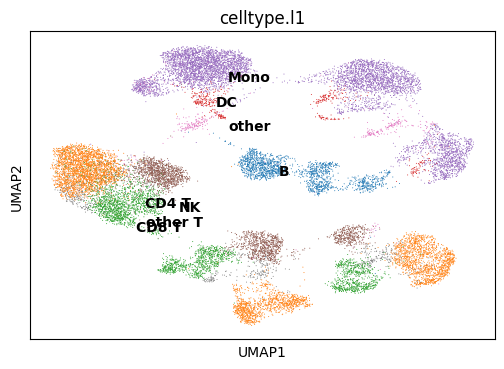

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


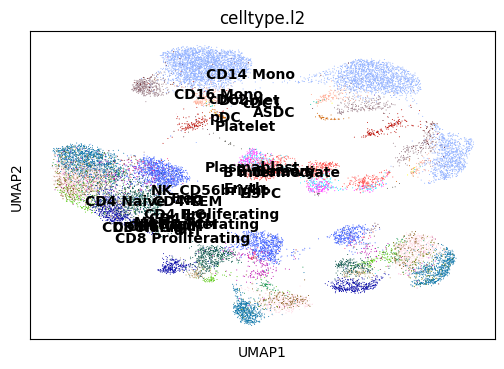

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


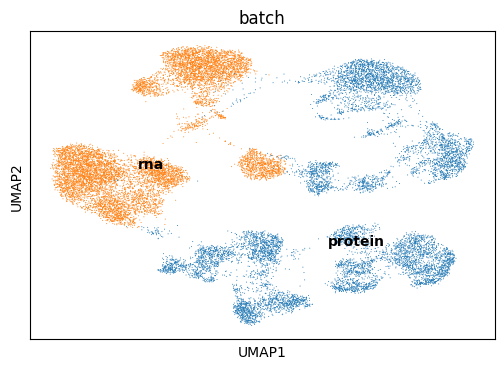

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.608,
lv2 matching acc: 0.341.
For All matchings: FOSCTTM score: 0.33661744, 
Knn Alignment score: [0.0013 0.002  0.0024 0.0029 0.0038 0.0047 0.0051 0.0055 0.0062 0.0071
 0.008  0.0084 0.0088 0.0097 0.01   0.0104 0.0108 0.0111 0.0118 0.0123
 0.0126 0.013  0.0134 0.014  0.0145]
For All matchings: Silhouette F1 score for lv1: 0.43223167600778495, 
Silhouette F1 score for lv2: 0.42126915963233835



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  5.367473840713501
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.704,
lv2 matching acc: 0.420.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.713,
lv2 matching acc: 0.447.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


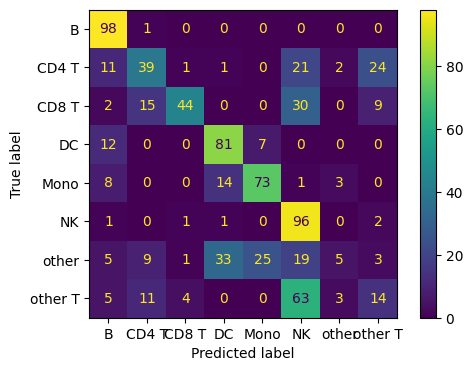

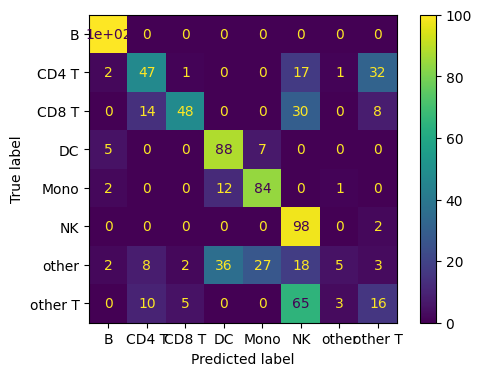

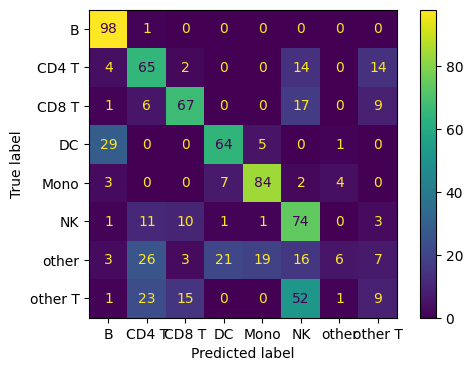

Epoch: 100: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 100: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.6945, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4513, Protein Recon Loss: 0.5019, Protein KL Div Back Pro: 0.9162, Protein KL Div Z: 0.7332, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6431, Shared Recon Loss Gene: 0.2803, Shared Recon Loss Protein: 1.8593 Cross Loss Protein: 0.5497


Epoch: 101: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.7126, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4508, Protein Recon Loss: 0.5016, Protein KL Div Back Pro: 0.9168, Protein KL Div Z: 0.7346, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6460, Shared Recon Loss Gene: 0.2805, Shared Recon Loss Protein: 1.8576 Cross Loss Protein: 0.5483


Epoch: 102: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.6764, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4514, Protein Recon Loss: 0.5006, Protein KL Div Back Pro: 0.9145, Protein KL Div Z: 0.7353, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6465, Shared Recon Loss Gene: 0.2801, Shared Recon Loss Protein: 1.8584 Cross Loss Protein: 0.5489


Epoch: 103: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.9155, RNA KL Div L: 0.0176, RNA KL Div Z: 0.4515, Protein Recon Loss: 0.5022, Protein KL Div Back Pro: 0.9122, Protein KL Div Z: 0.7346, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6467, Shared Recon Loss Gene: 0.2810, Shared Recon Loss Protein: 1.8594 Cross Loss Protein: 0.5491


Epoch: 104: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.7044, RNA KL Div L: 0.0177, RNA KL Div Z: 0.4519, Protein Recon Loss: 0.5001, Protein KL Div Back Pro: 0.9066, Protein KL Div Z: 0.7331, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6454, Shared Recon Loss Gene: 0.2793, Shared Recon Loss Protein: 1.8562 Cross Loss Protein: 0.5487


Epoch: 105: 40it [00:08,  4.59it/s]


RNA Recon Loss: 2.6964, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4507, Protein Recon Loss: 0.4995, Protein KL Div Back Pro: 0.9077, Protein KL Div Z: 0.7359, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6452, Shared Recon Loss Gene: 0.2794, Shared Recon Loss Protein: 1.8540 Cross Loss Protein: 0.5489


Epoch: 106: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.6498, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4522, Protein Recon Loss: 0.5017, Protein KL Div Back Pro: 0.9125, Protein KL Div Z: 0.7365, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6452, Shared Recon Loss Gene: 0.2793, Shared Recon Loss Protein: 1.8528 Cross Loss Protein: 0.5490


Epoch: 107: 40it [00:09,  4.34it/s]


RNA Recon Loss: 2.6495, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4504, Protein Recon Loss: 0.5009, Protein KL Div Back Pro: 0.9140, Protein KL Div Z: 0.7370, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6442, Shared Recon Loss Gene: 0.2788, Shared Recon Loss Protein: 1.8563 Cross Loss Protein: 0.5491


Epoch: 108: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.7021, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4515, Protein Recon Loss: 0.4990, Protein KL Div Back Pro: 0.9102, Protein KL Div Z: 0.7366, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6461, Shared Recon Loss Gene: 0.2800, Shared Recon Loss Protein: 1.8523 Cross Loss Protein: 0.5479


Epoch: 109: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.6514, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4513, Protein Recon Loss: 0.4992, Protein KL Div Back Pro: 0.9113, Protein KL Div Z: 0.7397, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6460, Shared Recon Loss Gene: 0.2790, Shared Recon Loss Protein: 1.8511 Cross Loss Protein: 0.5475


Epoch: 110: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.6512, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4524, Protein Recon Loss: 0.5007, Protein KL Div Back Pro: 0.9107, Protein KL Div Z: 0.7376, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6437, Shared Recon Loss Gene: 0.2787, Shared Recon Loss Protein: 1.8503 Cross Loss Protein: 0.5483


Epoch: 111: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.6386, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4516, Protein Recon Loss: 0.5029, Protein KL Div Back Pro: 0.9091, Protein KL Div Z: 0.7370, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6416, Shared Recon Loss Gene: 0.2789, Shared Recon Loss Protein: 1.8559 Cross Loss Protein: 0.5502


Epoch: 112: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.6192, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4512, Protein Recon Loss: 0.5001, Protein KL Div Back Pro: 0.9098, Protein KL Div Z: 0.7349, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6410, Shared Recon Loss Gene: 0.2768, Shared Recon Loss Protein: 1.8515 Cross Loss Protein: 0.5485


Epoch: 113: 40it [00:09,  4.37it/s]


RNA Recon Loss: 2.6210, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4506, Protein Recon Loss: 0.4998, Protein KL Div Back Pro: 0.9124, Protein KL Div Z: 0.7384, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6420, Shared Recon Loss Gene: 0.2780, Shared Recon Loss Protein: 1.8522 Cross Loss Protein: 0.5488


Epoch: 114: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.5751, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4516, Protein Recon Loss: 0.4994, Protein KL Div Back Pro: 0.9130, Protein KL Div Z: 0.7380, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6410, Shared Recon Loss Gene: 0.2774, Shared Recon Loss Protein: 1.8509 Cross Loss Protein: 0.5479


Epoch: 115: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.6736, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4508, Protein Recon Loss: 0.4988, Protein KL Div Back Pro: 0.9117, Protein KL Div Z: 0.7386, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6399, Shared Recon Loss Gene: 0.2778, Shared Recon Loss Protein: 1.8504 Cross Loss Protein: 0.5478


Epoch: 116: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.6129, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4510, Protein Recon Loss: 0.4984, Protein KL Div Back Pro: 0.9094, Protein KL Div Z: 0.7363, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6401, Shared Recon Loss Gene: 0.2776, Shared Recon Loss Protein: 1.8497 Cross Loss Protein: 0.5479


Epoch: 117: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.6221, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4511, Protein Recon Loss: 0.4987, Protein KL Div Back Pro: 0.9038, Protein KL Div Z: 0.7362, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6406, Shared Recon Loss Gene: 0.2776, Shared Recon Loss Protein: 1.8496 Cross Loss Protein: 0.5484


Epoch: 118: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.7669, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4507, Protein Recon Loss: 0.4987, Protein KL Div Back Pro: 0.9053, Protein KL Div Z: 0.7387, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6400, Shared Recon Loss Gene: 0.2779, Shared Recon Loss Protein: 1.8469 Cross Loss Protein: 0.5478


Epoch: 119: 40it [00:09,  4.43it/s]


RNA Recon Loss: 2.6826, RNA KL Div L: 0.0174, RNA KL Div Z: 0.4502, Protein Recon Loss: 0.5006, Protein KL Div Back Pro: 0.9054, Protein KL Div Z: 0.7361, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6375, Shared Recon Loss Gene: 0.2776, Shared Recon Loss Protein: 1.8552 Cross Loss Protein: 0.5488


Epoch: 120: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.5799, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4503, Protein Recon Loss: 0.5042, Protein KL Div Back Pro: 0.9115, Protein KL Div Z: 0.7352, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6394, Shared Recon Loss Gene: 0.2793, Shared Recon Loss Protein: 1.8548 Cross Loss Protein: 0.5511


Epoch: 121: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.6086, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4498, Protein Recon Loss: 0.4990, Protein KL Div Back Pro: 0.9033, Protein KL Div Z: 0.7337, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6365, Shared Recon Loss Gene: 0.2770, Shared Recon Loss Protein: 1.8484 Cross Loss Protein: 0.5482


Epoch: 122: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.6381, RNA KL Div L: 0.0173, RNA KL Div Z: 0.4500, Protein Recon Loss: 0.4993, Protein KL Div Back Pro: 0.9065, Protein KL Div Z: 0.7379, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6379, Shared Recon Loss Gene: 0.2767, Shared Recon Loss Protein: 1.8491 Cross Loss Protein: 0.5485


Epoch: 123: 40it [00:09,  4.35it/s]


RNA Recon Loss: 2.6397, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4508, Protein Recon Loss: 0.4992, Protein KL Div Back Pro: 0.9013, Protein KL Div Z: 0.7343, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6382, Shared Recon Loss Gene: 0.2779, Shared Recon Loss Protein: 1.8441 Cross Loss Protein: 0.5477


Epoch: 124: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.7278, RNA KL Div L: 0.0176, RNA KL Div Z: 0.4511, Protein Recon Loss: 0.5015, Protein KL Div Back Pro: 0.9025, Protein KL Div Z: 0.7344, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6365, Shared Recon Loss Gene: 0.2767, Shared Recon Loss Protein: 1.8502 Cross Loss Protein: 0.5497


Epoch: 125: 40it [00:09,  4.38it/s]


RNA Recon Loss: 2.7707, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4510, Protein Recon Loss: 0.5004, Protein KL Div Back Pro: 0.9054, Protein KL Div Z: 0.7347, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6382, Shared Recon Loss Gene: 0.2765, Shared Recon Loss Protein: 1.8463 Cross Loss Protein: 0.5481


Epoch: 126: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.6273, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4506, Protein Recon Loss: 0.4988, Protein KL Div Back Pro: 0.9035, Protein KL Div Z: 0.7336, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6371, Shared Recon Loss Gene: 0.2759, Shared Recon Loss Protein: 1.8439 Cross Loss Protein: 0.5475


Epoch: 127: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.6163, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4499, Protein Recon Loss: 0.4990, Protein KL Div Back Pro: 0.8965, Protein KL Div Z: 0.7306, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6366, Shared Recon Loss Gene: 0.2774, Shared Recon Loss Protein: 1.8484 Cross Loss Protein: 0.5483


Epoch: 128: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.5833, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4503, Protein Recon Loss: 0.4984, Protein KL Div Back Pro: 0.8928, Protein KL Div Z: 0.7330, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6383, Shared Recon Loss Gene: 0.2750, Shared Recon Loss Protein: 1.8416 Cross Loss Protein: 0.5467


Epoch: 129: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.7990, RNA KL Div L: 0.0173, RNA KL Div Z: 0.4492, Protein Recon Loss: 0.4981, Protein KL Div Back Pro: 0.9013, Protein KL Div Z: 0.7335, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6360, Shared Recon Loss Gene: 0.2754, Shared Recon Loss Protein: 1.8408 Cross Loss Protein: 0.5467


Epoch: 130: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.9178, RNA KL Div L: 0.0176, RNA KL Div Z: 0.4493, Protein Recon Loss: 0.5024, Protein KL Div Back Pro: 0.9037, Protein KL Div Z: 0.7358, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6368, Shared Recon Loss Gene: 0.2769, Shared Recon Loss Protein: 1.8415 Cross Loss Protein: 0.5478


Epoch: 131: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.6781, RNA KL Div L: 0.0174, RNA KL Div Z: 0.4503, Protein Recon Loss: 0.4978, Protein KL Div Back Pro: 0.8956, Protein KL Div Z: 0.7319, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6368, Shared Recon Loss Gene: 0.2754, Shared Recon Loss Protein: 1.8430 Cross Loss Protein: 0.5469


Epoch: 132: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.6199, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4496, Protein Recon Loss: 0.4983, Protein KL Div Back Pro: 0.8964, Protein KL Div Z: 0.7344, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6372, Shared Recon Loss Gene: 0.2761, Shared Recon Loss Protein: 1.8408 Cross Loss Protein: 0.5475


Epoch: 133: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.6386, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4497, Protein Recon Loss: 0.4971, Protein KL Div Back Pro: 0.9015, Protein KL Div Z: 0.7337, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6356, Shared Recon Loss Gene: 0.2762, Shared Recon Loss Protein: 1.8384 Cross Loss Protein: 0.5463


Epoch: 134: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.5953, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4508, Protein Recon Loss: 0.4977, Protein KL Div Back Pro: 0.8985, Protein KL Div Z: 0.7318, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6361, Shared Recon Loss Gene: 0.2763, Shared Recon Loss Protein: 1.8389 Cross Loss Protein: 0.5468


Epoch: 135: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.6713, RNA KL Div L: 0.0173, RNA KL Div Z: 0.4504, Protein Recon Loss: 0.4974, Protein KL Div Back Pro: 0.9021, Protein KL Div Z: 0.7339, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6362, Shared Recon Loss Gene: 0.2749, Shared Recon Loss Protein: 1.8395 Cross Loss Protein: 0.5466


Epoch: 136: 40it [00:09,  4.27it/s]


RNA Recon Loss: 2.6956, RNA KL Div L: 0.0173, RNA KL Div Z: 0.4499, Protein Recon Loss: 0.4980, Protein KL Div Back Pro: 0.8938, Protein KL Div Z: 0.7349, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6360, Shared Recon Loss Gene: 0.2748, Shared Recon Loss Protein: 1.8411 Cross Loss Protein: 0.5465


Epoch: 137: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.5921, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4503, Protein Recon Loss: 0.4976, Protein KL Div Back Pro: 0.8975, Protein KL Div Z: 0.7317, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6330, Shared Recon Loss Gene: 0.2762, Shared Recon Loss Protein: 1.8453 Cross Loss Protein: 0.5481


Epoch: 138: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.6046, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4501, Protein Recon Loss: 0.4984, Protein KL Div Back Pro: 0.8898, Protein KL Div Z: 0.7317, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6341, Shared Recon Loss Gene: 0.2761, Shared Recon Loss Protein: 1.8407 Cross Loss Protein: 0.5477


Epoch: 139: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.6014, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4498, Protein Recon Loss: 0.4984, Protein KL Div Back Pro: 0.8966, Protein KL Div Z: 0.7332, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6327, Shared Recon Loss Gene: 0.2753, Shared Recon Loss Protein: 1.8424 Cross Loss Protein: 0.5482


Epoch: 140: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.5518, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4506, Protein Recon Loss: 0.4993, Protein KL Div Back Pro: 0.8912, Protein KL Div Z: 0.7276, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6337, Shared Recon Loss Gene: 0.2743, Shared Recon Loss Protein: 1.8382 Cross Loss Protein: 0.5466


Epoch: 141: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.5792, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4505, Protein Recon Loss: 0.4993, Protein KL Div Back Pro: 0.8902, Protein KL Div Z: 0.7282, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6333, Shared Recon Loss Gene: 0.2743, Shared Recon Loss Protein: 1.8374 Cross Loss Protein: 0.5468


Epoch: 142: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.5800, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4500, Protein Recon Loss: 0.4995, Protein KL Div Back Pro: 0.8904, Protein KL Div Z: 0.7279, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6332, Shared Recon Loss Gene: 0.2753, Shared Recon Loss Protein: 1.8434 Cross Loss Protein: 0.5480


Epoch: 143: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.5565, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4499, Protein Recon Loss: 0.4975, Protein KL Div Back Pro: 0.8937, Protein KL Div Z: 0.7287, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6322, Shared Recon Loss Gene: 0.2746, Shared Recon Loss Protein: 1.8373 Cross Loss Protein: 0.5467


Epoch: 144: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5380, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4494, Protein Recon Loss: 0.4969, Protein KL Div Back Pro: 0.8955, Protein KL Div Z: 0.7295, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6332, Shared Recon Loss Gene: 0.2746, Shared Recon Loss Protein: 1.8401 Cross Loss Protein: 0.5474


Epoch: 145: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.5896, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4500, Protein Recon Loss: 0.4984, Protein KL Div Back Pro: 0.8965, Protein KL Div Z: 0.7283, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6325, Shared Recon Loss Gene: 0.2744, Shared Recon Loss Protein: 1.8433 Cross Loss Protein: 0.5473


Epoch: 146: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.6887, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4452, Protein Recon Loss: 0.4987, Protein KL Div Back Pro: 0.9040, Protein KL Div Z: 0.7265, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6305, Shared Recon Loss Gene: 0.2744, Shared Recon Loss Protein: 1.8396 Cross Loss Protein: 0.5476


Epoch: 147: 40it [00:08,  4.44it/s]


RNA Recon Loss: 2.6043, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4529, Protein Recon Loss: 0.4973, Protein KL Div Back Pro: 0.8982, Protein KL Div Z: 0.7254, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6288, Shared Recon Loss Gene: 0.2755, Shared Recon Loss Protein: 1.8341 Cross Loss Protein: 0.5464


Epoch: 148: 40it [00:09,  4.29it/s]


RNA Recon Loss: 2.6848, RNA KL Div L: 0.0174, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4965, Protein KL Div Back Pro: 0.8959, Protein KL Div Z: 0.7261, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6305, Shared Recon Loss Gene: 0.2738, Shared Recon Loss Protein: 1.8345 Cross Loss Protein: 0.5460


Epoch: 149: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.6371, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4538, Protein Recon Loss: 0.5011, Protein KL Div Back Pro: 0.8899, Protein KL Div Z: 0.7256, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6291, Shared Recon Loss Gene: 0.2744, Shared Recon Loss Protein: 1.8533 Cross Loss Protein: 0.5490


Epoch: 150: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.6145, RNA KL Div L: 0.0173, RNA KL Div Z: 0.4538, Protein Recon Loss: 0.5017, Protein KL Div Back Pro: 0.8957, Protein KL Div Z: 0.7222, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6245, Shared Recon Loss Gene: 0.2828, Shared Recon Loss Protein: 1.8702 Cross Loss Protein: 0.5548


Epoch: 151: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.5541, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4546, Protein Recon Loss: 0.4986, Protein KL Div Back Pro: 0.8853, Protein KL Div Z: 0.7234, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6243, Shared Recon Loss Gene: 0.2770, Shared Recon Loss Protein: 1.8409 Cross Loss Protein: 0.5488


Epoch: 152: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.5936, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4542, Protein Recon Loss: 0.4995, Protein KL Div Back Pro: 0.8867, Protein KL Div Z: 0.7226, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6244, Shared Recon Loss Gene: 0.2752, Shared Recon Loss Protein: 1.8416 Cross Loss Protein: 0.5482


Epoch: 153: 40it [00:09,  4.37it/s]


RNA Recon Loss: 2.5737, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4541, Protein Recon Loss: 0.4970, Protein KL Div Back Pro: 0.8894, Protein KL Div Z: 0.7220, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6245, Shared Recon Loss Gene: 0.2750, Shared Recon Loss Protein: 1.8325 Cross Loss Protein: 0.5462


Epoch: 154: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5892, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4538, Protein Recon Loss: 0.4963, Protein KL Div Back Pro: 0.8896, Protein KL Div Z: 0.7223, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6243, Shared Recon Loss Gene: 0.2738, Shared Recon Loss Protein: 1.8343 Cross Loss Protein: 0.5457


Epoch: 155: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.5777, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4547, Protein Recon Loss: 0.4964, Protein KL Div Back Pro: 0.8899, Protein KL Div Z: 0.7252, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6266, Shared Recon Loss Gene: 0.2737, Shared Recon Loss Protein: 1.8338 Cross Loss Protein: 0.5464


Epoch: 156: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5177, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4546, Protein Recon Loss: 0.4980, Protein KL Div Back Pro: 0.8888, Protein KL Div Z: 0.7257, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6237, Shared Recon Loss Gene: 0.2738, Shared Recon Loss Protein: 1.8360 Cross Loss Protein: 0.5471


Epoch: 157: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.5237, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4543, Protein Recon Loss: 0.4976, Protein KL Div Back Pro: 0.8867, Protein KL Div Z: 0.7242, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6240, Shared Recon Loss Gene: 0.2733, Shared Recon Loss Protein: 1.8444 Cross Loss Protein: 0.5470


Epoch: 158: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.5731, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4526, Protein Recon Loss: 0.4994, Protein KL Div Back Pro: 0.8816, Protein KL Div Z: 0.7196, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6255, Shared Recon Loss Gene: 0.2777, Shared Recon Loss Protein: 1.8450 Cross Loss Protein: 0.5490


Epoch: 159: 40it [00:09,  4.39it/s]


RNA Recon Loss: 2.5553, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4534, Protein Recon Loss: 0.4983, Protein KL Div Back Pro: 0.8827, Protein KL Div Z: 0.7191, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6245, Shared Recon Loss Gene: 0.2737, Shared Recon Loss Protein: 1.8342 Cross Loss Protein: 0.5468


Epoch: 160: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5152, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4963, Protein KL Div Back Pro: 0.8875, Protein KL Div Z: 0.7201, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6242, Shared Recon Loss Gene: 0.2737, Shared Recon Loss Protein: 1.8357 Cross Loss Protein: 0.5470


Epoch: 161: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.5752, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4515, Protein Recon Loss: 0.4955, Protein KL Div Back Pro: 0.8878, Protein KL Div Z: 0.7209, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6231, Shared Recon Loss Gene: 0.2729, Shared Recon Loss Protein: 1.8324 Cross Loss Protein: 0.5459


Epoch: 162: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.5855, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4527, Protein Recon Loss: 0.4978, Protein KL Div Back Pro: 0.8843, Protein KL Div Z: 0.7207, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6240, Shared Recon Loss Gene: 0.2733, Shared Recon Loss Protein: 1.8315 Cross Loss Protein: 0.5460


Epoch: 163: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5711, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4550, Protein Recon Loss: 0.4957, Protein KL Div Back Pro: 0.8838, Protein KL Div Z: 0.7205, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6235, Shared Recon Loss Gene: 0.2746, Shared Recon Loss Protein: 1.8298 Cross Loss Protein: 0.5459


Epoch: 164: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.5530, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4958, Protein KL Div Back Pro: 0.8840, Protein KL Div Z: 0.7194, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6247, Shared Recon Loss Gene: 0.2729, Shared Recon Loss Protein: 1.8310 Cross Loss Protein: 0.5464


Epoch: 165: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5862, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4563, Protein Recon Loss: 0.4956, Protein KL Div Back Pro: 0.8868, Protein KL Div Z: 0.7200, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6228, Shared Recon Loss Gene: 0.2740, Shared Recon Loss Protein: 1.8272 Cross Loss Protein: 0.5450


Epoch: 166: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.5106, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4603, Protein Recon Loss: 0.4968, Protein KL Div Back Pro: 0.8870, Protein KL Div Z: 0.7188, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6230, Shared Recon Loss Gene: 0.2723, Shared Recon Loss Protein: 1.8280 Cross Loss Protein: 0.5452


Epoch: 167: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5738, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4629, Protein Recon Loss: 0.4950, Protein KL Div Back Pro: 0.8801, Protein KL Div Z: 0.7181, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6245, Shared Recon Loss Gene: 0.2738, Shared Recon Loss Protein: 1.8291 Cross Loss Protein: 0.5452


Epoch: 168: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.5484, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4633, Protein Recon Loss: 0.4972, Protein KL Div Back Pro: 0.8841, Protein KL Div Z: 0.7180, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6235, Shared Recon Loss Gene: 0.2732, Shared Recon Loss Protein: 1.8294 Cross Loss Protein: 0.5459


Epoch: 169: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.5264, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4626, Protein Recon Loss: 0.4952, Protein KL Div Back Pro: 0.8828, Protein KL Div Z: 0.7179, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6219, Shared Recon Loss Gene: 0.2728, Shared Recon Loss Protein: 1.8307 Cross Loss Protein: 0.5454


Epoch: 170: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.4914, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4630, Protein Recon Loss: 0.4958, Protein KL Div Back Pro: 0.8807, Protein KL Div Z: 0.7174, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6223, Shared Recon Loss Gene: 0.2723, Shared Recon Loss Protein: 1.8300 Cross Loss Protein: 0.5453


Epoch: 171: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.4926, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4633, Protein Recon Loss: 0.4970, Protein KL Div Back Pro: 0.8849, Protein KL Div Z: 0.7182, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6220, Shared Recon Loss Gene: 0.2729, Shared Recon Loss Protein: 1.8335 Cross Loss Protein: 0.5464


Epoch: 172: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.4899, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4614, Protein Recon Loss: 0.4954, Protein KL Div Back Pro: 0.8825, Protein KL Div Z: 0.7179, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6213, Shared Recon Loss Gene: 0.2727, Shared Recon Loss Protein: 1.8298 Cross Loss Protein: 0.5455


Epoch: 173: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.5161, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4610, Protein Recon Loss: 0.4961, Protein KL Div Back Pro: 0.8813, Protein KL Div Z: 0.7166, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6216, Shared Recon Loss Gene: 0.2733, Shared Recon Loss Protein: 1.8271 Cross Loss Protein: 0.5460


Epoch: 174: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.5658, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4604, Protein Recon Loss: 0.4979, Protein KL Div Back Pro: 0.8827, Protein KL Div Z: 0.7166, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6209, Shared Recon Loss Gene: 0.2719, Shared Recon Loss Protein: 1.8271 Cross Loss Protein: 0.5459


Epoch: 175: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.6189, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4599, Protein Recon Loss: 0.4975, Protein KL Div Back Pro: 0.8830, Protein KL Div Z: 0.7126, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6223, Shared Recon Loss Gene: 0.2724, Shared Recon Loss Protein: 1.8265 Cross Loss Protein: 0.5456


Epoch: 176: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.4894, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4601, Protein Recon Loss: 0.4957, Protein KL Div Back Pro: 0.8805, Protein KL Div Z: 0.7139, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6220, Shared Recon Loss Gene: 0.2722, Shared Recon Loss Protein: 1.8279 Cross Loss Protein: 0.5454


Epoch: 177: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.5079, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4594, Protein Recon Loss: 0.4972, Protein KL Div Back Pro: 0.8803, Protein KL Div Z: 0.7097, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6200, Shared Recon Loss Gene: 0.2728, Shared Recon Loss Protein: 1.8342 Cross Loss Protein: 0.5468


Epoch: 178: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.5088, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4595, Protein Recon Loss: 0.4952, Protein KL Div Back Pro: 0.8808, Protein KL Div Z: 0.7116, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6196, Shared Recon Loss Gene: 0.2716, Shared Recon Loss Protein: 1.8264 Cross Loss Protein: 0.5451


Epoch: 179: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.4789, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4600, Protein Recon Loss: 0.4952, Protein KL Div Back Pro: 0.8766, Protein KL Div Z: 0.7095, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6182, Shared Recon Loss Gene: 0.2715, Shared Recon Loss Protein: 1.8259 Cross Loss Protein: 0.5452


Epoch: 180: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.5015, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4596, Protein Recon Loss: 0.4945, Protein KL Div Back Pro: 0.8776, Protein KL Div Z: 0.7112, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6175, Shared Recon Loss Gene: 0.2728, Shared Recon Loss Protein: 1.8281 Cross Loss Protein: 0.5452


Epoch: 181: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.5013, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4587, Protein Recon Loss: 0.4948, Protein KL Div Back Pro: 0.8873, Protein KL Div Z: 0.7109, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6181, Shared Recon Loss Gene: 0.2720, Shared Recon Loss Protein: 1.8289 Cross Loss Protein: 0.5451


Epoch: 182: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.5051, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4586, Protein Recon Loss: 0.4945, Protein KL Div Back Pro: 0.8807, Protein KL Div Z: 0.7125, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6192, Shared Recon Loss Gene: 0.2722, Shared Recon Loss Protein: 1.8254 Cross Loss Protein: 0.5445


Epoch: 183: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.5246, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4594, Protein Recon Loss: 0.4986, Protein KL Div Back Pro: 0.8755, Protein KL Div Z: 0.7088, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6176, Shared Recon Loss Gene: 0.2720, Shared Recon Loss Protein: 1.8298 Cross Loss Protein: 0.5468


Epoch: 184: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.4984, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4584, Protein Recon Loss: 0.5006, Protein KL Div Back Pro: 0.8806, Protein KL Div Z: 0.7096, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6174, Shared Recon Loss Gene: 0.2720, Shared Recon Loss Protein: 1.8302 Cross Loss Protein: 0.5474


Epoch: 185: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.5045, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4580, Protein Recon Loss: 0.4949, Protein KL Div Back Pro: 0.8776, Protein KL Div Z: 0.7066, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6169, Shared Recon Loss Gene: 0.2726, Shared Recon Loss Protein: 1.8259 Cross Loss Protein: 0.5458


Epoch: 186: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5720, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4569, Protein Recon Loss: 0.4970, Protein KL Div Back Pro: 0.8763, Protein KL Div Z: 0.7030, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6148, Shared Recon Loss Gene: 0.2725, Shared Recon Loss Protein: 1.8272 Cross Loss Protein: 0.5452


Epoch: 187: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.6948, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4563, Protein Recon Loss: 0.4963, Protein KL Div Back Pro: 0.8812, Protein KL Div Z: 0.7046, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6149, Shared Recon Loss Gene: 0.2715, Shared Recon Loss Protein: 1.8340 Cross Loss Protein: 0.5457


Epoch: 188: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.5324, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4566, Protein Recon Loss: 0.4960, Protein KL Div Back Pro: 0.8738, Protein KL Div Z: 0.7028, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6172, Shared Recon Loss Gene: 0.2716, Shared Recon Loss Protein: 1.8286 Cross Loss Protein: 0.5457


Epoch: 189: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.4996, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4565, Protein Recon Loss: 0.4951, Protein KL Div Back Pro: 0.8782, Protein KL Div Z: 0.7044, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6146, Shared Recon Loss Gene: 0.2709, Shared Recon Loss Protein: 1.8255 Cross Loss Protein: 0.5453


Epoch: 190: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.4893, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4566, Protein Recon Loss: 0.4960, Protein KL Div Back Pro: 0.8768, Protein KL Div Z: 0.7040, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6144, Shared Recon Loss Gene: 0.2714, Shared Recon Loss Protein: 1.8262 Cross Loss Protein: 0.5459


Epoch: 191: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.4790, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4572, Protein Recon Loss: 0.4958, Protein KL Div Back Pro: 0.8783, Protein KL Div Z: 0.7047, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6148, Shared Recon Loss Gene: 0.2729, Shared Recon Loss Protein: 1.8258 Cross Loss Protein: 0.5452


Epoch: 192: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.4810, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4564, Protein Recon Loss: 0.4959, Protein KL Div Back Pro: 0.8722, Protein KL Div Z: 0.7029, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6135, Shared Recon Loss Gene: 0.2715, Shared Recon Loss Protein: 1.8260 Cross Loss Protein: 0.5452


Epoch: 193: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.4864, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4563, Protein Recon Loss: 0.4973, Protein KL Div Back Pro: 0.8782, Protein KL Div Z: 0.7029, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6129, Shared Recon Loss Gene: 0.2714, Shared Recon Loss Protein: 1.8311 Cross Loss Protein: 0.5464


Epoch: 194: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.4800, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4553, Protein Recon Loss: 0.4968, Protein KL Div Back Pro: 0.8726, Protein KL Div Z: 0.6988, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6061, Shared Recon Loss Gene: 0.2732, Shared Recon Loss Protein: 1.8388 Cross Loss Protein: 0.5481


Epoch: 195: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.5214, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4534, Protein Recon Loss: 0.4948, Protein KL Div Back Pro: 0.8721, Protein KL Div Z: 0.7000, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6076, Shared Recon Loss Gene: 0.2716, Shared Recon Loss Protein: 1.8256 Cross Loss Protein: 0.5450


Epoch: 196: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.4798, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4601, Protein Recon Loss: 0.4962, Protein KL Div Back Pro: 0.8683, Protein KL Div Z: 0.6989, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6088, Shared Recon Loss Gene: 0.2717, Shared Recon Loss Protein: 1.8242 Cross Loss Protein: 0.5446


Epoch: 197: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.4949, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4592, Protein Recon Loss: 0.4966, Protein KL Div Back Pro: 0.8733, Protein KL Div Z: 0.7000, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6091, Shared Recon Loss Gene: 0.2715, Shared Recon Loss Protein: 1.8275 Cross Loss Protein: 0.5459


Epoch: 198: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5259, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4593, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.8750, Protein KL Div Z: 0.6987, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6092, Shared Recon Loss Gene: 0.2729, Shared Recon Loss Protein: 1.8262 Cross Loss Protein: 0.5455


Epoch: 199: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.5278, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4536, Protein Recon Loss: 0.4976, Protein KL Div Back Pro: 0.8736, Protein KL Div Z: 0.7002, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6084, Shared Recon Loss Gene: 0.2709, Shared Recon Loss Protein: 1.8303 Cross Loss Protein: 0.5466


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


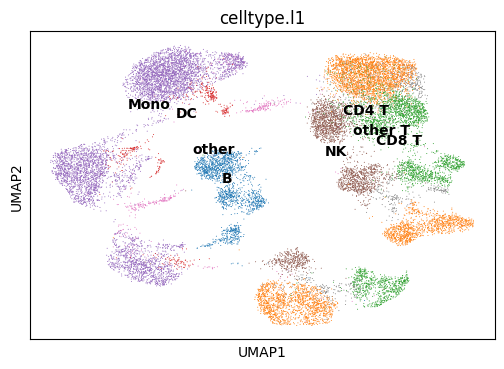

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


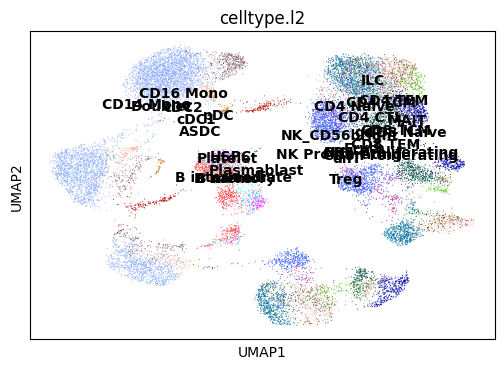

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


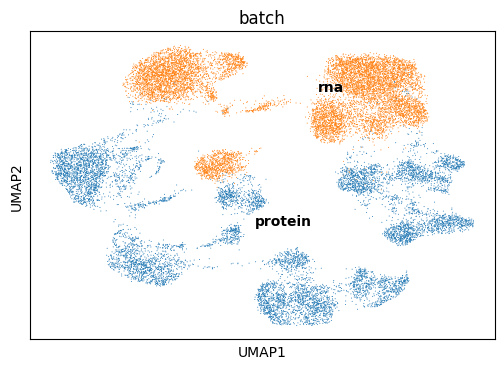

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.666,
lv2 matching acc: 0.451.
For All matchings: FOSCTTM score: 0.31632782, 
Knn Alignment score: [0.0008 0.0016 0.002  0.0024 0.0031 0.004  0.0048 0.0056 0.0067 0.0074
 0.008  0.0085 0.0092 0.0097 0.0101 0.0103 0.0113 0.0118 0.0127 0.0135
 0.0137 0.0144 0.0153 0.0163 0.0168]
For All matchings: Silhouette F1 score for lv1: 0.4548314932753338, 
Silhouette F1 score for lv2: 0.44365993655157565



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  4.936165809631348
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.769,
lv2 matching acc: 0.506.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.745,
lv2 matching acc: 0.525.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


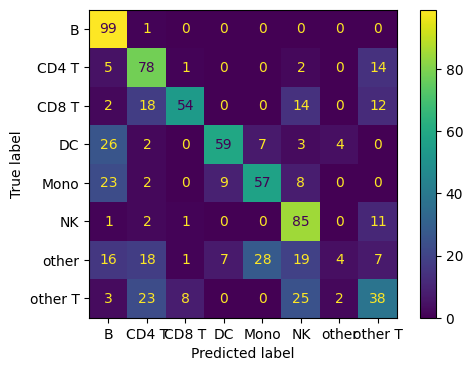

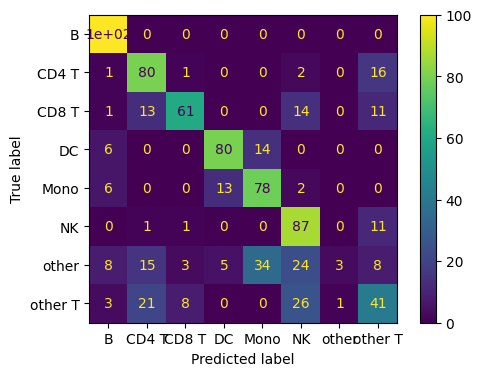

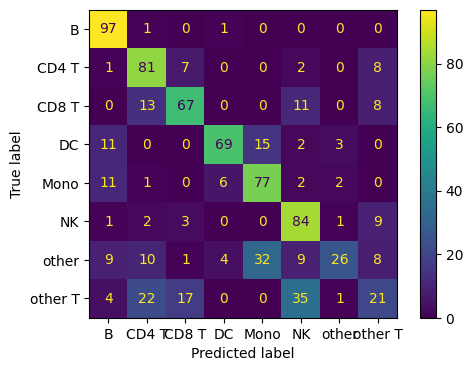

Epoch: 200: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 200: 40it [00:09,  4.26it/s]


RNA Recon Loss: 2.4637, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4574, Protein Recon Loss: 0.4968, Protein KL Div Back Pro: 0.8749, Protein KL Div Z: 0.6986, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6106, Shared Recon Loss Gene: 0.2720, Shared Recon Loss Protein: 1.8287 Cross Loss Protein: 0.5458


Epoch: 201: 40it [00:09,  4.20it/s]


RNA Recon Loss: 2.4815, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4592, Protein Recon Loss: 0.4965, Protein KL Div Back Pro: 0.8704, Protein KL Div Z: 0.6992, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6114, Shared Recon Loss Gene: 0.2713, Shared Recon Loss Protein: 1.8229 Cross Loss Protein: 0.5448


Epoch: 202: 40it [00:09,  4.15it/s]


RNA Recon Loss: 2.4517, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4600, Protein Recon Loss: 0.4948, Protein KL Div Back Pro: 0.8705, Protein KL Div Z: 0.6962, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6098, Shared Recon Loss Gene: 0.2715, Shared Recon Loss Protein: 1.8241 Cross Loss Protein: 0.5447


Epoch: 203: 40it [00:09,  4.16it/s]


RNA Recon Loss: 2.4475, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4599, Protein Recon Loss: 0.4962, Protein KL Div Back Pro: 0.8752, Protein KL Div Z: 0.6978, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6086, Shared Recon Loss Gene: 0.2708, Shared Recon Loss Protein: 1.8242 Cross Loss Protein: 0.5457


Epoch: 204: 40it [00:09,  4.14it/s]


RNA Recon Loss: 2.5059, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4602, Protein Recon Loss: 0.4968, Protein KL Div Back Pro: 0.8695, Protein KL Div Z: 0.6980, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6090, Shared Recon Loss Gene: 0.2710, Shared Recon Loss Protein: 1.8239 Cross Loss Protein: 0.5455


Epoch: 205: 40it [00:09,  4.20it/s]


RNA Recon Loss: 2.4850, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4609, Protein Recon Loss: 0.4951, Protein KL Div Back Pro: 0.8723, Protein KL Div Z: 0.6961, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6087, Shared Recon Loss Gene: 0.2712, Shared Recon Loss Protein: 1.8232 Cross Loss Protein: 0.5447


Epoch: 206: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.4503, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4597, Protein Recon Loss: 0.4956, Protein KL Div Back Pro: 0.8709, Protein KL Div Z: 0.6936, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6075, Shared Recon Loss Gene: 0.2695, Shared Recon Loss Protein: 1.8220 Cross Loss Protein: 0.5446


Epoch: 207: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.4653, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4592, Protein Recon Loss: 0.4962, Protein KL Div Back Pro: 0.8697, Protein KL Div Z: 0.6920, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6065, Shared Recon Loss Gene: 0.2707, Shared Recon Loss Protein: 1.8218 Cross Loss Protein: 0.5446


Epoch: 208: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.4557, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4596, Protein Recon Loss: 0.4941, Protein KL Div Back Pro: 0.8701, Protein KL Div Z: 0.6948, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6062, Shared Recon Loss Gene: 0.2712, Shared Recon Loss Protein: 1.8263 Cross Loss Protein: 0.5445


Epoch: 209: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.4805, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4596, Protein Recon Loss: 0.4973, Protein KL Div Back Pro: 0.8679, Protein KL Div Z: 0.6891, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6068, Shared Recon Loss Gene: 0.2712, Shared Recon Loss Protein: 1.8267 Cross Loss Protein: 0.5449


Epoch: 210: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.4746, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4596, Protein Recon Loss: 0.4949, Protein KL Div Back Pro: 0.8739, Protein KL Div Z: 0.6926, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6044, Shared Recon Loss Gene: 0.2724, Shared Recon Loss Protein: 1.8273 Cross Loss Protein: 0.5459


Epoch: 211: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.4532, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4586, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.8676, Protein KL Div Z: 0.6925, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6055, Shared Recon Loss Gene: 0.2705, Shared Recon Loss Protein: 1.8231 Cross Loss Protein: 0.5444


Epoch: 212: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.4224, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4585, Protein Recon Loss: 0.4938, Protein KL Div Back Pro: 0.8704, Protein KL Div Z: 0.6943, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6055, Shared Recon Loss Gene: 0.2698, Shared Recon Loss Protein: 1.8239 Cross Loss Protein: 0.5444


Epoch: 213: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.4263, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4596, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.8618, Protein KL Div Z: 0.6919, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6055, Shared Recon Loss Gene: 0.2699, Shared Recon Loss Protein: 1.8219 Cross Loss Protein: 0.5446


Epoch: 214: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.4448, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4582, Protein Recon Loss: 0.4953, Protein KL Div Back Pro: 0.8612, Protein KL Div Z: 0.6927, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6050, Shared Recon Loss Gene: 0.2699, Shared Recon Loss Protein: 1.8272 Cross Loss Protein: 0.5456


Epoch: 215: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.4297, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4587, Protein Recon Loss: 0.4990, Protein KL Div Back Pro: 0.8647, Protein KL Div Z: 0.6896, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6050, Shared Recon Loss Gene: 0.2707, Shared Recon Loss Protein: 1.8278 Cross Loss Protein: 0.5472


Epoch: 216: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.4199, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4583, Protein Recon Loss: 0.4986, Protein KL Div Back Pro: 0.8673, Protein KL Div Z: 0.6879, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6028, Shared Recon Loss Gene: 0.2702, Shared Recon Loss Protein: 1.8269 Cross Loss Protein: 0.5461


Epoch: 217: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.4256, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4582, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.8755, Protein KL Div Z: 0.6859, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6042, Shared Recon Loss Gene: 0.2700, Shared Recon Loss Protein: 1.8252 Cross Loss Protein: 0.5453


Epoch: 218: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.4286, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4584, Protein Recon Loss: 0.4956, Protein KL Div Back Pro: 0.8702, Protein KL Div Z: 0.6857, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6027, Shared Recon Loss Gene: 0.2695, Shared Recon Loss Protein: 1.8199 Cross Loss Protein: 0.5437


Epoch: 219: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.3942, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4586, Protein Recon Loss: 0.4953, Protein KL Div Back Pro: 0.8655, Protein KL Div Z: 0.6865, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6035, Shared Recon Loss Gene: 0.2702, Shared Recon Loss Protein: 1.8251 Cross Loss Protein: 0.5456


Epoch: 220: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.4489, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4569, Protein Recon Loss: 0.4942, Protein KL Div Back Pro: 0.8658, Protein KL Div Z: 0.6877, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6028, Shared Recon Loss Gene: 0.2708, Shared Recon Loss Protein: 1.8272 Cross Loss Protein: 0.5448


Epoch: 221: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.4225, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4574, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.8629, Protein KL Div Z: 0.6861, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6028, Shared Recon Loss Gene: 0.2701, Shared Recon Loss Protein: 1.8233 Cross Loss Protein: 0.5446


Epoch: 222: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.4050, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4567, Protein Recon Loss: 0.4951, Protein KL Div Back Pro: 0.8603, Protein KL Div Z: 0.6841, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6007, Shared Recon Loss Gene: 0.2696, Shared Recon Loss Protein: 1.8218 Cross Loss Protein: 0.5443


Epoch: 223: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.3996, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4563, Protein Recon Loss: 0.4956, Protein KL Div Back Pro: 0.8616, Protein KL Div Z: 0.6818, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6029, Shared Recon Loss Gene: 0.2691, Shared Recon Loss Protein: 1.8231 Cross Loss Protein: 0.5456


Epoch: 224: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.4205, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4561, Protein Recon Loss: 0.4944, Protein KL Div Back Pro: 0.8628, Protein KL Div Z: 0.6854, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6014, Shared Recon Loss Gene: 0.2690, Shared Recon Loss Protein: 1.8209 Cross Loss Protein: 0.5442


Epoch: 225: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.4118, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4565, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.8615, Protein KL Div Z: 0.6830, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6021, Shared Recon Loss Gene: 0.2698, Shared Recon Loss Protein: 1.8226 Cross Loss Protein: 0.5438


Epoch: 226: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.4203, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4567, Protein Recon Loss: 0.4947, Protein KL Div Back Pro: 0.8631, Protein KL Div Z: 0.6843, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5988, Shared Recon Loss Gene: 0.2714, Shared Recon Loss Protein: 1.8298 Cross Loss Protein: 0.5465


Epoch: 227: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.4616, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4556, Protein Recon Loss: 0.4950, Protein KL Div Back Pro: 0.8587, Protein KL Div Z: 0.6846, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5982, Shared Recon Loss Gene: 0.2698, Shared Recon Loss Protein: 1.8232 Cross Loss Protein: 0.5454


Epoch: 228: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.5366, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4543, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.8587, Protein KL Div Z: 0.6838, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5988, Shared Recon Loss Gene: 0.2700, Shared Recon Loss Protein: 1.8233 Cross Loss Protein: 0.5449


Epoch: 229: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.4586, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4547, Protein Recon Loss: 0.4940, Protein KL Div Back Pro: 0.8624, Protein KL Div Z: 0.6845, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5997, Shared Recon Loss Gene: 0.2699, Shared Recon Loss Protein: 1.8318 Cross Loss Protein: 0.5460


Epoch: 230: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.4224, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4562, Protein Recon Loss: 0.4947, Protein KL Div Back Pro: 0.8616, Protein KL Div Z: 0.6830, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5994, Shared Recon Loss Gene: 0.2715, Shared Recon Loss Protein: 1.8315 Cross Loss Protein: 0.5466


Epoch: 231: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3986, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4561, Protein Recon Loss: 0.4941, Protein KL Div Back Pro: 0.8614, Protein KL Div Z: 0.6815, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5999, Shared Recon Loss Gene: 0.2703, Shared Recon Loss Protein: 1.8208 Cross Loss Protein: 0.5443


Epoch: 232: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.4438, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4565, Protein Recon Loss: 0.4976, Protein KL Div Back Pro: 0.8602, Protein KL Div Z: 0.6806, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5992, Shared Recon Loss Gene: 0.2709, Shared Recon Loss Protein: 1.8238 Cross Loss Protein: 0.5453


Epoch: 233: 40it [00:09,  4.39it/s]


RNA Recon Loss: 2.4427, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4560, Protein Recon Loss: 0.4968, Protein KL Div Back Pro: 0.8650, Protein KL Div Z: 0.6777, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6026, Shared Recon Loss Gene: 0.2705, Shared Recon Loss Protein: 1.8265 Cross Loss Protein: 0.5459


Epoch: 234: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.3991, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4559, Protein Recon Loss: 0.4949, Protein KL Div Back Pro: 0.8637, Protein KL Div Z: 0.6787, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5991, Shared Recon Loss Gene: 0.2698, Shared Recon Loss Protein: 1.8220 Cross Loss Protein: 0.5451


Epoch: 235: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.4130, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4561, Protein Recon Loss: 0.4944, Protein KL Div Back Pro: 0.8598, Protein KL Div Z: 0.6760, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5990, Shared Recon Loss Gene: 0.2696, Shared Recon Loss Protein: 1.8208 Cross Loss Protein: 0.5446


Epoch: 236: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.4013, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4554, Protein Recon Loss: 0.4942, Protein KL Div Back Pro: 0.8600, Protein KL Div Z: 0.6778, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5978, Shared Recon Loss Gene: 0.2699, Shared Recon Loss Protein: 1.8219 Cross Loss Protein: 0.5442


Epoch: 237: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3859, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4553, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.8602, Protein KL Div Z: 0.6792, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5984, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8189 Cross Loss Protein: 0.5440


Epoch: 238: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3850, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4549, Protein Recon Loss: 0.4945, Protein KL Div Back Pro: 0.8576, Protein KL Div Z: 0.6791, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5977, Shared Recon Loss Gene: 0.2687, Shared Recon Loss Protein: 1.8264 Cross Loss Protein: 0.5453


Epoch: 239: 40it [00:09,  4.41it/s]


RNA Recon Loss: 2.4142, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4550, Protein Recon Loss: 0.4950, Protein KL Div Back Pro: 0.8631, Protein KL Div Z: 0.6803, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6008, Shared Recon Loss Gene: 0.2703, Shared Recon Loss Protein: 1.8252 Cross Loss Protein: 0.5454


Epoch: 240: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.4184, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4546, Protein Recon Loss: 0.4935, Protein KL Div Back Pro: 0.8572, Protein KL Div Z: 0.6765, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5976, Shared Recon Loss Gene: 0.2685, Shared Recon Loss Protein: 1.8183 Cross Loss Protein: 0.5439


Epoch: 241: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.3784, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4549, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.8620, Protein KL Div Z: 0.6774, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5977, Shared Recon Loss Gene: 0.2687, Shared Recon Loss Protein: 1.8215 Cross Loss Protein: 0.5447


Epoch: 242: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.3937, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4542, Protein Recon Loss: 0.4937, Protein KL Div Back Pro: 0.8593, Protein KL Div Z: 0.6774, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5965, Shared Recon Loss Gene: 0.2699, Shared Recon Loss Protein: 1.8212 Cross Loss Protein: 0.5447


Epoch: 243: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.4009, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4552, Protein Recon Loss: 0.4929, Protein KL Div Back Pro: 0.8552, Protein KL Div Z: 0.6762, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5953, Shared Recon Loss Gene: 0.2696, Shared Recon Loss Protein: 1.8211 Cross Loss Protein: 0.5443


Epoch: 244: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.4015, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4542, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8610, Protein KL Div Z: 0.6766, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5952, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8191 Cross Loss Protein: 0.5441


Epoch: 245: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.3907, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4549, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8599, Protein KL Div Z: 0.6759, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5952, Shared Recon Loss Gene: 0.2708, Shared Recon Loss Protein: 1.8214 Cross Loss Protein: 0.5451


Epoch: 246: 40it [00:09,  4.40it/s]


RNA Recon Loss: 2.4046, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4930, Protein KL Div Back Pro: 0.8569, Protein KL Div Z: 0.6730, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5928, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8187 Cross Loss Protein: 0.5440


Epoch: 247: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.4064, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4546, Protein Recon Loss: 0.4953, Protein KL Div Back Pro: 0.8632, Protein KL Div Z: 0.6710, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5927, Shared Recon Loss Gene: 0.2701, Shared Recon Loss Protein: 1.8243 Cross Loss Protein: 0.5455


Epoch: 248: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3996, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4943, Protein KL Div Back Pro: 0.8602, Protein KL Div Z: 0.6687, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5946, Shared Recon Loss Gene: 0.2687, Shared Recon Loss Protein: 1.8187 Cross Loss Protein: 0.5443


Epoch: 249: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3713, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4541, Protein Recon Loss: 0.4943, Protein KL Div Back Pro: 0.8555, Protein KL Div Z: 0.6702, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5916, Shared Recon Loss Gene: 0.2688, Shared Recon Loss Protein: 1.8214 Cross Loss Protein: 0.5451


Epoch: 250: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3739, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4538, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.8534, Protein KL Div Z: 0.6711, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5931, Shared Recon Loss Gene: 0.2695, Shared Recon Loss Protein: 1.8191 Cross Loss Protein: 0.5444


Epoch: 251: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.3801, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4547, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8529, Protein KL Div Z: 0.6715, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5915, Shared Recon Loss Gene: 0.2686, Shared Recon Loss Protein: 1.8177 Cross Loss Protein: 0.5438


Epoch: 252: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.4061, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.8546, Protein KL Div Z: 0.6712, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5922, Shared Recon Loss Gene: 0.2696, Shared Recon Loss Protein: 1.8151 Cross Loss Protein: 0.5433


Epoch: 253: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3844, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.8559, Protein KL Div Z: 0.6678, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5929, Shared Recon Loss Gene: 0.2706, Shared Recon Loss Protein: 1.8176 Cross Loss Protein: 0.5436


Epoch: 254: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.3886, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4527, Protein Recon Loss: 0.4937, Protein KL Div Back Pro: 0.8549, Protein KL Div Z: 0.6670, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5920, Shared Recon Loss Gene: 0.2704, Shared Recon Loss Protein: 1.8244 Cross Loss Protein: 0.5445


Epoch: 255: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.3754, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4529, Protein Recon Loss: 0.4966, Protein KL Div Back Pro: 0.8507, Protein KL Div Z: 0.6671, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5919, Shared Recon Loss Gene: 0.2700, Shared Recon Loss Protein: 1.8216 Cross Loss Protein: 0.5450


Epoch: 256: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.3592, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4523, Protein Recon Loss: 0.4937, Protein KL Div Back Pro: 0.8534, Protein KL Div Z: 0.6652, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5917, Shared Recon Loss Gene: 0.2691, Shared Recon Loss Protein: 1.8194 Cross Loss Protein: 0.5447


Epoch: 257: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.3890, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4525, Protein Recon Loss: 0.4934, Protein KL Div Back Pro: 0.8493, Protein KL Div Z: 0.6672, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5911, Shared Recon Loss Gene: 0.2693, Shared Recon Loss Protein: 1.8154 Cross Loss Protein: 0.5434


Epoch: 258: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.4113, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4524, Protein Recon Loss: 0.4945, Protein KL Div Back Pro: 0.8496, Protein KL Div Z: 0.6653, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5911, Shared Recon Loss Gene: 0.2682, Shared Recon Loss Protein: 1.8182 Cross Loss Protein: 0.5449


Epoch: 259: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.3735, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4526, Protein Recon Loss: 0.4930, Protein KL Div Back Pro: 0.8513, Protein KL Div Z: 0.6649, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5907, Shared Recon Loss Gene: 0.2687, Shared Recon Loss Protein: 1.8145 Cross Loss Protein: 0.5436


Epoch: 260: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3650, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4527, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.8542, Protein KL Div Z: 0.6656, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5915, Shared Recon Loss Gene: 0.2685, Shared Recon Loss Protein: 1.8144 Cross Loss Protein: 0.5439


Epoch: 261: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.3614, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4527, Protein Recon Loss: 0.4935, Protein KL Div Back Pro: 0.8549, Protein KL Div Z: 0.6650, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5917, Shared Recon Loss Gene: 0.2688, Shared Recon Loss Protein: 1.8174 Cross Loss Protein: 0.5439


Epoch: 262: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3583, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4521, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8555, Protein KL Div Z: 0.6636, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5900, Shared Recon Loss Gene: 0.2691, Shared Recon Loss Protein: 1.8177 Cross Loss Protein: 0.5435


Epoch: 263: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.3464, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4525, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8529, Protein KL Div Z: 0.6628, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5888, Shared Recon Loss Gene: 0.2685, Shared Recon Loss Protein: 1.8160 Cross Loss Protein: 0.5435


Epoch: 264: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.3727, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4524, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.8513, Protein KL Div Z: 0.6631, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5881, Shared Recon Loss Gene: 0.2681, Shared Recon Loss Protein: 1.8160 Cross Loss Protein: 0.5438


Epoch: 265: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3702, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4520, Protein Recon Loss: 0.4938, Protein KL Div Back Pro: 0.8539, Protein KL Div Z: 0.6622, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5890, Shared Recon Loss Gene: 0.2690, Shared Recon Loss Protein: 1.8140 Cross Loss Protein: 0.5436


Epoch: 266: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.3713, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4524, Protein Recon Loss: 0.4954, Protein KL Div Back Pro: 0.8526, Protein KL Div Z: 0.6635, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5878, Shared Recon Loss Gene: 0.2691, Shared Recon Loss Protein: 1.8185 Cross Loss Protein: 0.5447


Epoch: 267: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3479, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4523, Protein Recon Loss: 0.4932, Protein KL Div Back Pro: 0.8490, Protein KL Div Z: 0.6618, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5886, Shared Recon Loss Gene: 0.2682, Shared Recon Loss Protein: 1.8181 Cross Loss Protein: 0.5438


Epoch: 268: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.3598, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4515, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.8468, Protein KL Div Z: 0.6609, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5879, Shared Recon Loss Gene: 0.2678, Shared Recon Loss Protein: 1.8145 Cross Loss Protein: 0.5437


Epoch: 269: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.3497, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4521, Protein Recon Loss: 0.4931, Protein KL Div Back Pro: 0.8510, Protein KL Div Z: 0.6617, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5883, Shared Recon Loss Gene: 0.2678, Shared Recon Loss Protein: 1.8191 Cross Loss Protein: 0.5443


Epoch: 270: 40it [00:09,  4.43it/s]


RNA Recon Loss: 2.3411, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4514, Protein Recon Loss: 0.4940, Protein KL Div Back Pro: 0.8519, Protein KL Div Z: 0.6588, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5859, Shared Recon Loss Gene: 0.2672, Shared Recon Loss Protein: 1.8213 Cross Loss Protein: 0.5441


Epoch: 271: 40it [00:10,  3.97it/s]


RNA Recon Loss: 2.3624, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4515, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8470, Protein KL Div Z: 0.6592, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5863, Shared Recon Loss Gene: 0.2688, Shared Recon Loss Protein: 1.8154 Cross Loss Protein: 0.5436


Epoch: 272: 40it [00:09,  4.37it/s]


RNA Recon Loss: 2.3794, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4520, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8472, Protein KL Div Z: 0.6592, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5853, Shared Recon Loss Gene: 0.2681, Shared Recon Loss Protein: 1.8179 Cross Loss Protein: 0.5437


Epoch: 273: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.3770, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4517, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8422, Protein KL Div Z: 0.6599, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5847, Shared Recon Loss Gene: 0.2696, Shared Recon Loss Protein: 1.8191 Cross Loss Protein: 0.5444


Epoch: 274: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.3650, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4514, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.8421, Protein KL Div Z: 0.6574, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5851, Shared Recon Loss Gene: 0.2681, Shared Recon Loss Protein: 1.8159 Cross Loss Protein: 0.5432


Epoch: 275: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3436, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4516, Protein Recon Loss: 0.4942, Protein KL Div Back Pro: 0.8458, Protein KL Div Z: 0.6564, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5841, Shared Recon Loss Gene: 0.2682, Shared Recon Loss Protein: 1.8168 Cross Loss Protein: 0.5442


Epoch: 276: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.3785, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4517, Protein Recon Loss: 0.4926, Protein KL Div Back Pro: 0.8497, Protein KL Div Z: 0.6538, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5835, Shared Recon Loss Gene: 0.2693, Shared Recon Loss Protein: 1.8190 Cross Loss Protein: 0.5440


Epoch: 277: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.3821, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4508, Protein Recon Loss: 0.4945, Protein KL Div Back Pro: 0.8515, Protein KL Div Z: 0.6549, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5812, Shared Recon Loss Gene: 0.2700, Shared Recon Loss Protein: 1.8262 Cross Loss Protein: 0.5450


Epoch: 278: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3980, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4519, Protein Recon Loss: 0.4937, Protein KL Div Back Pro: 0.8558, Protein KL Div Z: 0.6533, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5823, Shared Recon Loss Gene: 0.2696, Shared Recon Loss Protein: 1.8276 Cross Loss Protein: 0.5457


Epoch: 279: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.3604, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4542, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.8526, Protein KL Div Z: 0.6534, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5819, Shared Recon Loss Gene: 0.2678, Shared Recon Loss Protein: 1.8172 Cross Loss Protein: 0.5438


Epoch: 280: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.3427, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8469, Protein KL Div Z: 0.6542, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5820, Shared Recon Loss Gene: 0.2679, Shared Recon Loss Protein: 1.8170 Cross Loss Protein: 0.5442


Epoch: 281: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.3310, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4528, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.8413, Protein KL Div Z: 0.6520, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5825, Shared Recon Loss Gene: 0.2673, Shared Recon Loss Protein: 1.8191 Cross Loss Protein: 0.5437


Epoch: 282: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.3515, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4532, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8406, Protein KL Div Z: 0.6508, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5814, Shared Recon Loss Gene: 0.2680, Shared Recon Loss Protein: 1.8130 Cross Loss Protein: 0.5428


Epoch: 283: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3542, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4534, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.8489, Protein KL Div Z: 0.6533, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5802, Shared Recon Loss Gene: 0.2677, Shared Recon Loss Protein: 1.8186 Cross Loss Protein: 0.5450


Epoch: 284: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.3405, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4521, Protein Recon Loss: 0.4929, Protein KL Div Back Pro: 0.8473, Protein KL Div Z: 0.6517, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5802, Shared Recon Loss Gene: 0.2678, Shared Recon Loss Protein: 1.8225 Cross Loss Protein: 0.5452


Epoch: 285: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.3375, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4525, Protein Recon Loss: 0.4934, Protein KL Div Back Pro: 0.8484, Protein KL Div Z: 0.6498, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5793, Shared Recon Loss Gene: 0.2680, Shared Recon Loss Protein: 1.8188 Cross Loss Protein: 0.5451


Epoch: 286: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3195, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4529, Protein Recon Loss: 0.4943, Protein KL Div Back Pro: 0.8518, Protein KL Div Z: 0.6485, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5800, Shared Recon Loss Gene: 0.2686, Shared Recon Loss Protein: 1.8213 Cross Loss Protein: 0.5455


Epoch: 287: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3279, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4956, Protein KL Div Back Pro: 0.8497, Protein KL Div Z: 0.6473, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5777, Shared Recon Loss Gene: 0.2680, Shared Recon Loss Protein: 1.8187 Cross Loss Protein: 0.5442


Epoch: 288: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3431, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4521, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8508, Protein KL Div Z: 0.6467, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5783, Shared Recon Loss Gene: 0.2672, Shared Recon Loss Protein: 1.8143 Cross Loss Protein: 0.5426


Epoch: 289: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.3505, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4517, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8465, Protein KL Div Z: 0.6468, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5782, Shared Recon Loss Gene: 0.2675, Shared Recon Loss Protein: 1.8164 Cross Loss Protein: 0.5434


Epoch: 290: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.3458, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4526, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8446, Protein KL Div Z: 0.6483, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5793, Shared Recon Loss Gene: 0.2682, Shared Recon Loss Protein: 1.8177 Cross Loss Protein: 0.5436


Epoch: 291: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.3436, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4522, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8478, Protein KL Div Z: 0.6477, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5789, Shared Recon Loss Gene: 0.2680, Shared Recon Loss Protein: 1.8146 Cross Loss Protein: 0.5434


Epoch: 292: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.3325, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4520, Protein Recon Loss: 0.4937, Protein KL Div Back Pro: 0.8464, Protein KL Div Z: 0.6474, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5781, Shared Recon Loss Gene: 0.2676, Shared Recon Loss Protein: 1.8162 Cross Loss Protein: 0.5443


Epoch: 293: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.3375, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4530, Protein Recon Loss: 0.4924, Protein KL Div Back Pro: 0.8411, Protein KL Div Z: 0.6483, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5778, Shared Recon Loss Gene: 0.2672, Shared Recon Loss Protein: 1.8148 Cross Loss Protein: 0.5437


Epoch: 294: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.3665, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4522, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.8433, Protein KL Div Z: 0.6468, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5771, Shared Recon Loss Gene: 0.2670, Shared Recon Loss Protein: 1.8152 Cross Loss Protein: 0.5435


Epoch: 295: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.3311, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4534, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.8452, Protein KL Div Z: 0.6439, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5768, Shared Recon Loss Gene: 0.2672, Shared Recon Loss Protein: 1.8132 Cross Loss Protein: 0.5437


Epoch: 296: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.3301, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4525, Protein Recon Loss: 0.4944, Protein KL Div Back Pro: 0.8482, Protein KL Div Z: 0.6439, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5781, Shared Recon Loss Gene: 0.2670, Shared Recon Loss Protein: 1.8139 Cross Loss Protein: 0.5441


Epoch: 297: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.3334, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4530, Protein Recon Loss: 0.4929, Protein KL Div Back Pro: 0.8415, Protein KL Div Z: 0.6454, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5776, Shared Recon Loss Gene: 0.2660, Shared Recon Loss Protein: 1.8132 Cross Loss Protein: 0.5440


Epoch: 298: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3484, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4532, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.8370, Protein KL Div Z: 0.6437, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5769, Shared Recon Loss Gene: 0.2676, Shared Recon Loss Protein: 1.8141 Cross Loss Protein: 0.5434


Epoch: 299: 40it [00:09,  4.35it/s]


RNA Recon Loss: 2.3274, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4544, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.8353, Protein KL Div Z: 0.6423, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5770, Shared Recon Loss Gene: 0.2673, Shared Recon Loss Protein: 1.8149 Cross Loss Protein: 0.5437


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


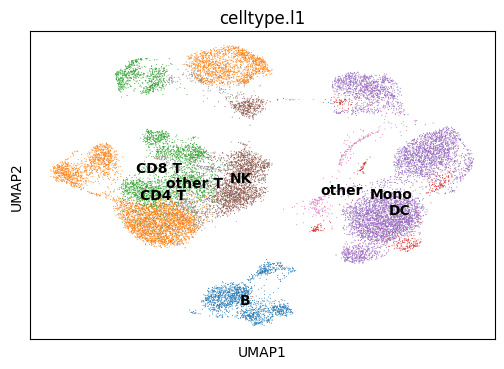

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


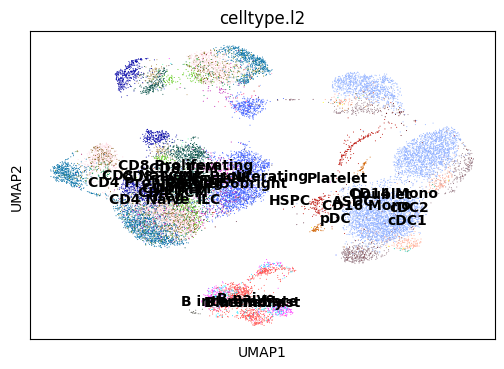

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


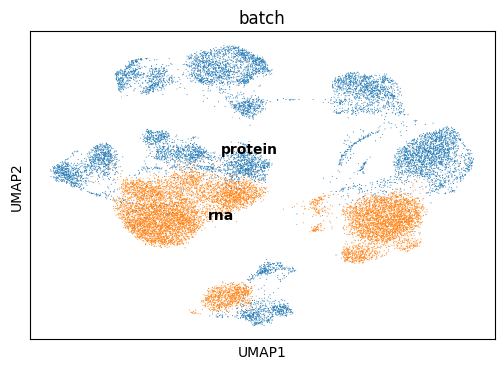

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.699,
lv2 matching acc: 0.501.
For All matchings: FOSCTTM score: 0.27195403, 
Knn Alignment score: [0.0011 0.0026 0.0035 0.0045 0.005  0.006  0.0066 0.0073 0.0082 0.0093
 0.0103 0.0109 0.0115 0.0124 0.0131 0.0144 0.0148 0.0156 0.0163 0.0167
 0.0172 0.0184 0.0193 0.02   0.0205]
For All matchings: Silhouette F1 score for lv1: 0.48458525560046434, 
Silhouette F1 score for lv2: 0.4723497870842919



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  4.059007883071899
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.799,
lv2 matching acc: 0.580.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.784,
lv2 matching acc: 0.561.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


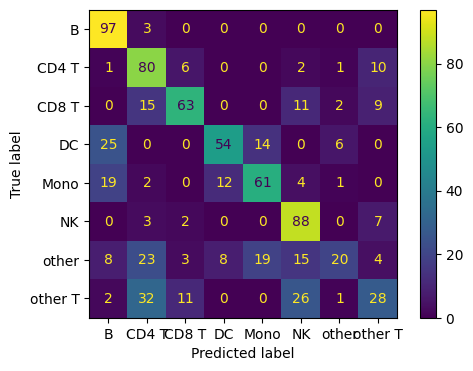

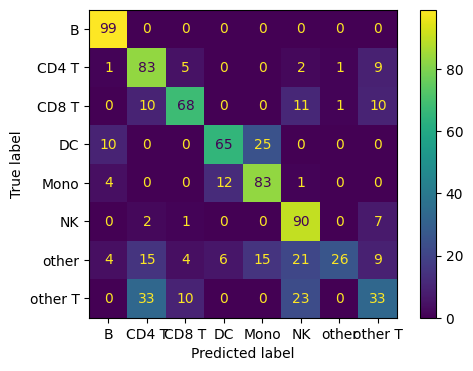

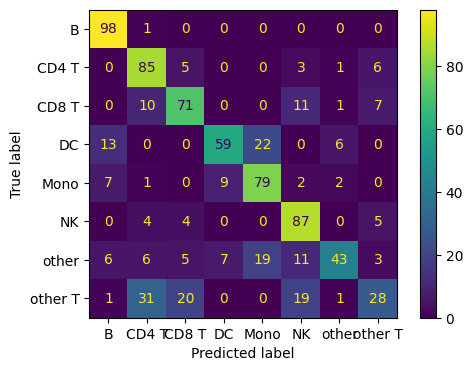

Epoch: 300: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 300: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.3287, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4538, Protein Recon Loss: 0.4931, Protein KL Div Back Pro: 0.8448, Protein KL Div Z: 0.6410, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5755, Shared Recon Loss Gene: 0.2671, Shared Recon Loss Protein: 1.8191 Cross Loss Protein: 0.5438


Epoch: 301: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.3137, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4539, Protein Recon Loss: 0.4941, Protein KL Div Back Pro: 0.8542, Protein KL Div Z: 0.6449, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5750, Shared Recon Loss Gene: 0.2674, Shared Recon Loss Protein: 1.8165 Cross Loss Protein: 0.5434


Epoch: 302: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.3101, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4966, Protein KL Div Back Pro: 0.8448, Protein KL Div Z: 0.6381, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5739, Shared Recon Loss Gene: 0.2677, Shared Recon Loss Protein: 1.8166 Cross Loss Protein: 0.5444


Epoch: 303: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.3397, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8442, Protein KL Div Z: 0.6379, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5747, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8147 Cross Loss Protein: 0.5433


Epoch: 304: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3129, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4533, Protein Recon Loss: 0.4926, Protein KL Div Back Pro: 0.8398, Protein KL Div Z: 0.6366, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5748, Shared Recon Loss Gene: 0.2672, Shared Recon Loss Protein: 1.8151 Cross Loss Protein: 0.5433


Epoch: 305: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.3260, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4536, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8408, Protein KL Div Z: 0.6394, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5743, Shared Recon Loss Gene: 0.2673, Shared Recon Loss Protein: 1.8132 Cross Loss Protein: 0.5437


Epoch: 306: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.3382, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8430, Protein KL Div Z: 0.6391, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5731, Shared Recon Loss Gene: 0.2673, Shared Recon Loss Protein: 1.8149 Cross Loss Protein: 0.5429


Epoch: 307: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.3137, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4536, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.8442, Protein KL Div Z: 0.6397, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5736, Shared Recon Loss Gene: 0.2668, Shared Recon Loss Protein: 1.8141 Cross Loss Protein: 0.5426


Epoch: 308: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.3146, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8444, Protein KL Div Z: 0.6383, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5718, Shared Recon Loss Gene: 0.2674, Shared Recon Loss Protein: 1.8173 Cross Loss Protein: 0.5435


Epoch: 309: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.3186, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4526, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8440, Protein KL Div Z: 0.6395, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5700, Shared Recon Loss Gene: 0.2667, Shared Recon Loss Protein: 1.8149 Cross Loss Protein: 0.5441


Epoch: 310: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.3165, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4530, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.8405, Protein KL Div Z: 0.6386, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5724, Shared Recon Loss Gene: 0.2676, Shared Recon Loss Protein: 1.8156 Cross Loss Protein: 0.5439


Epoch: 311: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.3141, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4524, Protein Recon Loss: 0.4940, Protein KL Div Back Pro: 0.8413, Protein KL Div Z: 0.6360, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5697, Shared Recon Loss Gene: 0.2679, Shared Recon Loss Protein: 1.8153 Cross Loss Protein: 0.5442


Epoch: 312: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3409, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4525, Protein Recon Loss: 0.4934, Protein KL Div Back Pro: 0.8363, Protein KL Div Z: 0.6373, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5695, Shared Recon Loss Gene: 0.2678, Shared Recon Loss Protein: 1.8138 Cross Loss Protein: 0.5432


Epoch: 313: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3112, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8383, Protein KL Div Z: 0.6364, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5707, Shared Recon Loss Gene: 0.2670, Shared Recon Loss Protein: 1.8144 Cross Loss Protein: 0.5438


Epoch: 314: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.3029, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4538, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.8423, Protein KL Div Z: 0.6351, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5709, Shared Recon Loss Gene: 0.2671, Shared Recon Loss Protein: 1.8156 Cross Loss Protein: 0.5435


Epoch: 315: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.3167, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4524, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8416, Protein KL Div Z: 0.6335, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5689, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8142 Cross Loss Protein: 0.5432


Epoch: 316: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2978, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4545, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8383, Protein KL Div Z: 0.6334, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5699, Shared Recon Loss Gene: 0.2668, Shared Recon Loss Protein: 1.8135 Cross Loss Protein: 0.5434


Epoch: 317: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2907, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4540, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.8328, Protein KL Div Z: 0.6322, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5681, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8151 Cross Loss Protein: 0.5434


Epoch: 318: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2979, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4538, Protein Recon Loss: 0.4930, Protein KL Div Back Pro: 0.8372, Protein KL Div Z: 0.6336, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5689, Shared Recon Loss Gene: 0.2669, Shared Recon Loss Protein: 1.8170 Cross Loss Protein: 0.5443


Epoch: 319: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.2938, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4535, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8372, Protein KL Div Z: 0.6325, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5685, Shared Recon Loss Gene: 0.2667, Shared Recon Loss Protein: 1.8143 Cross Loss Protein: 0.5435


Epoch: 320: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.3055, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4529, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8371, Protein KL Div Z: 0.6318, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5670, Shared Recon Loss Gene: 0.2669, Shared Recon Loss Protein: 1.8116 Cross Loss Protein: 0.5423


Epoch: 321: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.3030, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4954, Protein KL Div Back Pro: 0.8383, Protein KL Div Z: 0.6281, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5668, Shared Recon Loss Gene: 0.2674, Shared Recon Loss Protein: 1.8146 Cross Loss Protein: 0.5440


Epoch: 322: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2949, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4534, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8383, Protein KL Div Z: 0.6295, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5691, Shared Recon Loss Gene: 0.2661, Shared Recon Loss Protein: 1.8147 Cross Loss Protein: 0.5434


Epoch: 323: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2972, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4539, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.8431, Protein KL Div Z: 0.6308, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5674, Shared Recon Loss Gene: 0.2673, Shared Recon Loss Protein: 1.8125 Cross Loss Protein: 0.5430


Epoch: 324: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.2951, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4932, Protein KL Div Back Pro: 0.8361, Protein KL Div Z: 0.6292, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5681, Shared Recon Loss Gene: 0.2664, Shared Recon Loss Protein: 1.8132 Cross Loss Protein: 0.5435


Epoch: 325: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.2872, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4532, Protein Recon Loss: 0.4929, Protein KL Div Back Pro: 0.8401, Protein KL Div Z: 0.6278, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5677, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8139 Cross Loss Protein: 0.5433


Epoch: 326: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2913, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4534, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.8349, Protein KL Div Z: 0.6279, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5668, Shared Recon Loss Gene: 0.2668, Shared Recon Loss Protein: 1.8158 Cross Loss Protein: 0.5434


Epoch: 327: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2870, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8369, Protein KL Div Z: 0.6272, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5674, Shared Recon Loss Gene: 0.2657, Shared Recon Loss Protein: 1.8173 Cross Loss Protein: 0.5431


Epoch: 328: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3015, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4527, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8390, Protein KL Div Z: 0.6298, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5645, Shared Recon Loss Gene: 0.2670, Shared Recon Loss Protein: 1.8128 Cross Loss Protein: 0.5437


Epoch: 329: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.3138, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4536, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.8380, Protein KL Div Z: 0.6300, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5651, Shared Recon Loss Gene: 0.2671, Shared Recon Loss Protein: 1.8129 Cross Loss Protein: 0.5430


Epoch: 330: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.3085, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4529, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8365, Protein KL Div Z: 0.6284, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5628, Shared Recon Loss Gene: 0.2675, Shared Recon Loss Protein: 1.8151 Cross Loss Protein: 0.5447


Epoch: 331: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.3161, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4540, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.8348, Protein KL Div Z: 0.6273, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5644, Shared Recon Loss Gene: 0.2673, Shared Recon Loss Protein: 1.8155 Cross Loss Protein: 0.5444


Epoch: 332: 40it [00:09,  4.37it/s]


RNA Recon Loss: 2.2897, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4543, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.8359, Protein KL Div Z: 0.6251, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5625, Shared Recon Loss Gene: 0.2669, Shared Recon Loss Protein: 1.8146 Cross Loss Protein: 0.5441


Epoch: 333: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.2919, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4539, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8380, Protein KL Div Z: 0.6267, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5627, Shared Recon Loss Gene: 0.2671, Shared Recon Loss Protein: 1.8142 Cross Loss Protein: 0.5436


Epoch: 334: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2881, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4546, Protein Recon Loss: 0.4944, Protein KL Div Back Pro: 0.8348, Protein KL Div Z: 0.6262, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5623, Shared Recon Loss Gene: 0.2666, Shared Recon Loss Protein: 1.8158 Cross Loss Protein: 0.5443


Epoch: 335: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2798, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4545, Protein Recon Loss: 0.4932, Protein KL Div Back Pro: 0.8312, Protein KL Div Z: 0.6222, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5616, Shared Recon Loss Gene: 0.2675, Shared Recon Loss Protein: 1.8217 Cross Loss Protein: 0.5443


Epoch: 336: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2854, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4539, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8368, Protein KL Div Z: 0.6225, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5608, Shared Recon Loss Gene: 0.2658, Shared Recon Loss Protein: 1.8120 Cross Loss Protein: 0.5436


Epoch: 337: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2910, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4541, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8375, Protein KL Div Z: 0.6213, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5616, Shared Recon Loss Gene: 0.2666, Shared Recon Loss Protein: 1.8152 Cross Loss Protein: 0.5438


Epoch: 338: 40it [00:09,  4.28it/s]


RNA Recon Loss: 2.2910, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4544, Protein Recon Loss: 0.4926, Protein KL Div Back Pro: 0.8366, Protein KL Div Z: 0.6210, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5607, Shared Recon Loss Gene: 0.2675, Shared Recon Loss Protein: 1.8136 Cross Loss Protein: 0.5428


Epoch: 339: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.2779, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4539, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8330, Protein KL Div Z: 0.6191, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5600, Shared Recon Loss Gene: 0.2660, Shared Recon Loss Protein: 1.8129 Cross Loss Protein: 0.5432


Epoch: 340: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2710, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4546, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8373, Protein KL Div Z: 0.6213, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5603, Shared Recon Loss Gene: 0.2651, Shared Recon Loss Protein: 1.8144 Cross Loss Protein: 0.5433


Epoch: 341: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2810, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4539, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8387, Protein KL Div Z: 0.6223, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5593, Shared Recon Loss Gene: 0.2666, Shared Recon Loss Protein: 1.8143 Cross Loss Protein: 0.5434


Epoch: 342: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2789, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8313, Protein KL Div Z: 0.6211, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5583, Shared Recon Loss Gene: 0.2670, Shared Recon Loss Protein: 1.8122 Cross Loss Protein: 0.5427


Epoch: 343: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2776, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4545, Protein Recon Loss: 0.4955, Protein KL Div Back Pro: 0.8353, Protein KL Div Z: 0.6200, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5582, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8137 Cross Loss Protein: 0.5444


Epoch: 344: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2987, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4549, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.8342, Protein KL Div Z: 0.6178, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5590, Shared Recon Loss Gene: 0.2666, Shared Recon Loss Protein: 1.8116 Cross Loss Protein: 0.5423


Epoch: 345: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2740, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4542, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.8389, Protein KL Div Z: 0.6179, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5565, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8154 Cross Loss Protein: 0.5444


Epoch: 346: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.2739, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4540, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8328, Protein KL Div Z: 0.6183, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5575, Shared Recon Loss Gene: 0.2658, Shared Recon Loss Protein: 1.8111 Cross Loss Protein: 0.5421


Epoch: 347: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2772, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4540, Protein Recon Loss: 0.4934, Protein KL Div Back Pro: 0.8359, Protein KL Div Z: 0.6167, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5564, Shared Recon Loss Gene: 0.2662, Shared Recon Loss Protein: 1.8145 Cross Loss Protein: 0.5437


Epoch: 348: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2885, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4543, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8339, Protein KL Div Z: 0.6176, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5562, Shared Recon Loss Gene: 0.2667, Shared Recon Loss Protein: 1.8134 Cross Loss Protein: 0.5432


Epoch: 349: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2887, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4548, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8351, Protein KL Div Z: 0.6165, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5559, Shared Recon Loss Gene: 0.2653, Shared Recon Loss Protein: 1.8099 Cross Loss Protein: 0.5421


Epoch: 350: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2693, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4543, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8289, Protein KL Div Z: 0.6181, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5561, Shared Recon Loss Gene: 0.2648, Shared Recon Loss Protein: 1.8127 Cross Loss Protein: 0.5436


Epoch: 351: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2755, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4542, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8292, Protein KL Div Z: 0.6179, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5551, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8144 Cross Loss Protein: 0.5433


Epoch: 352: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2761, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4548, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8341, Protein KL Div Z: 0.6189, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5545, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8105 Cross Loss Protein: 0.5429


Epoch: 353: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2708, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4550, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8330, Protein KL Div Z: 0.6166, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5557, Shared Recon Loss Gene: 0.2664, Shared Recon Loss Protein: 1.8103 Cross Loss Protein: 0.5429


Epoch: 354: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2758, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4546, Protein Recon Loss: 0.4924, Protein KL Div Back Pro: 0.8379, Protein KL Div Z: 0.6173, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5552, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8107 Cross Loss Protein: 0.5428


Epoch: 355: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2705, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4546, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8337, Protein KL Div Z: 0.6164, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5547, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8114 Cross Loss Protein: 0.5433


Epoch: 356: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2840, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4545, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.8309, Protein KL Div Z: 0.6152, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5542, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8100 Cross Loss Protein: 0.5421


Epoch: 357: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2726, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4545, Protein Recon Loss: 0.4909, Protein KL Div Back Pro: 0.8317, Protein KL Div Z: 0.6162, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5533, Shared Recon Loss Gene: 0.2656, Shared Recon Loss Protein: 1.8134 Cross Loss Protein: 0.5429


Epoch: 358: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2692, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4544, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.8330, Protein KL Div Z: 0.6141, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5537, Shared Recon Loss Gene: 0.2674, Shared Recon Loss Protein: 1.8133 Cross Loss Protein: 0.5429


Epoch: 359: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2698, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4541, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.8311, Protein KL Div Z: 0.6136, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5537, Shared Recon Loss Gene: 0.2655, Shared Recon Loss Protein: 1.8104 Cross Loss Protein: 0.5427


Epoch: 360: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.3272, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4546, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8284, Protein KL Div Z: 0.6133, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5525, Shared Recon Loss Gene: 0.2663, Shared Recon Loss Protein: 1.8116 Cross Loss Protein: 0.5436


Epoch: 361: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.2904, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4569, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.8345, Protein KL Div Z: 0.6135, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5534, Shared Recon Loss Gene: 0.2664, Shared Recon Loss Protein: 1.8136 Cross Loss Protein: 0.5436


Epoch: 362: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2750, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4576, Protein Recon Loss: 0.4929, Protein KL Div Back Pro: 0.8293, Protein KL Div Z: 0.6132, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5535, Shared Recon Loss Gene: 0.2664, Shared Recon Loss Protein: 1.8131 Cross Loss Protein: 0.5436


Epoch: 363: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2714, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4579, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.8295, Protein KL Div Z: 0.6118, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5521, Shared Recon Loss Gene: 0.2653, Shared Recon Loss Protein: 1.8111 Cross Loss Protein: 0.5431


Epoch: 364: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2628, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4580, Protein Recon Loss: 0.4918, Protein KL Div Back Pro: 0.8345, Protein KL Div Z: 0.6107, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5529, Shared Recon Loss Gene: 0.2651, Shared Recon Loss Protein: 1.8116 Cross Loss Protein: 0.5421


Epoch: 365: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2784, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4580, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8336, Protein KL Div Z: 0.6110, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5515, Shared Recon Loss Gene: 0.2670, Shared Recon Loss Protein: 1.8124 Cross Loss Protein: 0.5434


Epoch: 366: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2591, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4582, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8306, Protein KL Div Z: 0.6098, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5512, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8143 Cross Loss Protein: 0.5433


Epoch: 367: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2802, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4583, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8274, Protein KL Div Z: 0.6090, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5522, Shared Recon Loss Gene: 0.2656, Shared Recon Loss Protein: 1.8122 Cross Loss Protein: 0.5424


Epoch: 368: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2714, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4590, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8278, Protein KL Div Z: 0.6107, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5511, Shared Recon Loss Gene: 0.2662, Shared Recon Loss Protein: 1.8107 Cross Loss Protein: 0.5430


Epoch: 369: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2608, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4597, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8293, Protein KL Div Z: 0.6094, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5501, Shared Recon Loss Gene: 0.2663, Shared Recon Loss Protein: 1.8127 Cross Loss Protein: 0.5430


Epoch: 370: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2528, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4589, Protein Recon Loss: 0.4918, Protein KL Div Back Pro: 0.8278, Protein KL Div Z: 0.6102, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5501, Shared Recon Loss Gene: 0.2661, Shared Recon Loss Protein: 1.8174 Cross Loss Protein: 0.5436


Epoch: 371: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2544, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4589, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.8309, Protein KL Div Z: 0.6100, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5497, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8120 Cross Loss Protein: 0.5424


Epoch: 372: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2563, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4583, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.8306, Protein KL Div Z: 0.6067, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5506, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8132 Cross Loss Protein: 0.5433


Epoch: 373: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2445, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4591, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8320, Protein KL Div Z: 0.6074, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5486, Shared Recon Loss Gene: 0.2653, Shared Recon Loss Protein: 1.8125 Cross Loss Protein: 0.5427


Epoch: 374: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2515, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4578, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8314, Protein KL Div Z: 0.6083, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5476, Shared Recon Loss Gene: 0.2653, Shared Recon Loss Protein: 1.8148 Cross Loss Protein: 0.5436


Epoch: 375: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2566, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4584, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8292, Protein KL Div Z: 0.6080, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5478, Shared Recon Loss Gene: 0.2666, Shared Recon Loss Protein: 1.8122 Cross Loss Protein: 0.5426


Epoch: 376: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2518, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4583, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8277, Protein KL Div Z: 0.6072, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5476, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8102 Cross Loss Protein: 0.5425


Epoch: 377: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.2584, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4581, Protein Recon Loss: 0.4929, Protein KL Div Back Pro: 0.8303, Protein KL Div Z: 0.6065, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5479, Shared Recon Loss Gene: 0.2655, Shared Recon Loss Protein: 1.8127 Cross Loss Protein: 0.5435


Epoch: 378: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2730, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4590, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.8294, Protein KL Div Z: 0.6056, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5478, Shared Recon Loss Gene: 0.2662, Shared Recon Loss Protein: 1.8137 Cross Loss Protein: 0.5431


Epoch: 379: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2674, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4585, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8328, Protein KL Div Z: 0.6052, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5460, Shared Recon Loss Gene: 0.2657, Shared Recon Loss Protein: 1.8152 Cross Loss Protein: 0.5436


Epoch: 380: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2996, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4592, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8323, Protein KL Div Z: 0.6044, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5459, Shared Recon Loss Gene: 0.2672, Shared Recon Loss Protein: 1.8148 Cross Loss Protein: 0.5429


Epoch: 381: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2582, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4593, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8308, Protein KL Div Z: 0.6052, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5451, Shared Recon Loss Gene: 0.2658, Shared Recon Loss Protein: 1.8111 Cross Loss Protein: 0.5426


Epoch: 382: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2616, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4596, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8274, Protein KL Div Z: 0.6032, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5457, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8098 Cross Loss Protein: 0.5431


Epoch: 383: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2405, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4584, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.8289, Protein KL Div Z: 0.6018, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5443, Shared Recon Loss Gene: 0.2645, Shared Recon Loss Protein: 1.8106 Cross Loss Protein: 0.5430


Epoch: 384: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2494, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4587, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8323, Protein KL Div Z: 0.6007, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5450, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8096 Cross Loss Protein: 0.5424


Epoch: 385: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2485, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4578, Protein Recon Loss: 0.4909, Protein KL Div Back Pro: 0.8298, Protein KL Div Z: 0.6012, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5450, Shared Recon Loss Gene: 0.2650, Shared Recon Loss Protein: 1.8115 Cross Loss Protein: 0.5426


Epoch: 386: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2417, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4589, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8292, Protein KL Div Z: 0.6008, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5442, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8124 Cross Loss Protein: 0.5430


Epoch: 387: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.2329, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4582, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8344, Protein KL Div Z: 0.6003, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5438, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8097 Cross Loss Protein: 0.5415


Epoch: 388: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2411, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4590, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8303, Protein KL Div Z: 0.5988, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5424, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8075 Cross Loss Protein: 0.5432


Epoch: 389: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2528, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4579, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.8295, Protein KL Div Z: 0.6007, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5428, Shared Recon Loss Gene: 0.2655, Shared Recon Loss Protein: 1.8115 Cross Loss Protein: 0.5434


Epoch: 390: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2435, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4584, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8241, Protein KL Div Z: 0.5962, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5433, Shared Recon Loss Gene: 0.2651, Shared Recon Loss Protein: 1.8113 Cross Loss Protein: 0.5425


Epoch: 391: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2366, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4578, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8286, Protein KL Div Z: 0.5984, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5424, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8097 Cross Loss Protein: 0.5420


Epoch: 392: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2367, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4578, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8289, Protein KL Div Z: 0.5980, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5434, Shared Recon Loss Gene: 0.2645, Shared Recon Loss Protein: 1.8108 Cross Loss Protein: 0.5427


Epoch: 393: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.2469, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4583, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.8329, Protein KL Div Z: 0.6009, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5419, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8099 Cross Loss Protein: 0.5425


Epoch: 394: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2314, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4577, Protein Recon Loss: 0.4962, Protein KL Div Back Pro: 0.8261, Protein KL Div Z: 0.5960, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5410, Shared Recon Loss Gene: 0.2655, Shared Recon Loss Protein: 1.8157 Cross Loss Protein: 0.5439


Epoch: 395: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2478, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4579, Protein Recon Loss: 0.4934, Protein KL Div Back Pro: 0.8259, Protein KL Div Z: 0.5932, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5417, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8135 Cross Loss Protein: 0.5434


Epoch: 396: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2372, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4586, Protein Recon Loss: 0.4934, Protein KL Div Back Pro: 0.8275, Protein KL Div Z: 0.5944, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5407, Shared Recon Loss Gene: 0.2645, Shared Recon Loss Protein: 1.8108 Cross Loss Protein: 0.5436


Epoch: 397: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2232, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4582, Protein Recon Loss: 0.4935, Protein KL Div Back Pro: 0.8300, Protein KL Div Z: 0.5920, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5402, Shared Recon Loss Gene: 0.2639, Shared Recon Loss Protein: 1.8112 Cross Loss Protein: 0.5427


Epoch: 398: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2312, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4589, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.8256, Protein KL Div Z: 0.5933, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5398, Shared Recon Loss Gene: 0.2653, Shared Recon Loss Protein: 1.8118 Cross Loss Protein: 0.5428


Epoch: 399: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2431, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4589, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.8251, Protein KL Div Z: 0.5923, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5406, Shared Recon Loss Gene: 0.2658, Shared Recon Loss Protein: 1.8112 Cross Loss Protein: 0.5433


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


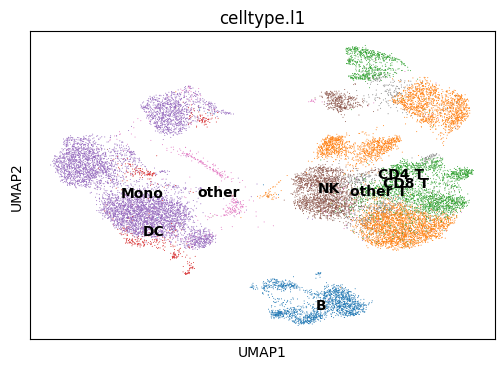

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


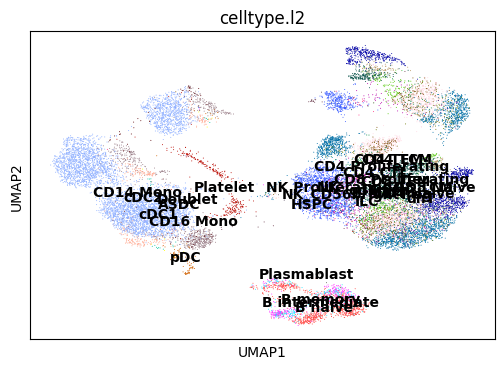

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


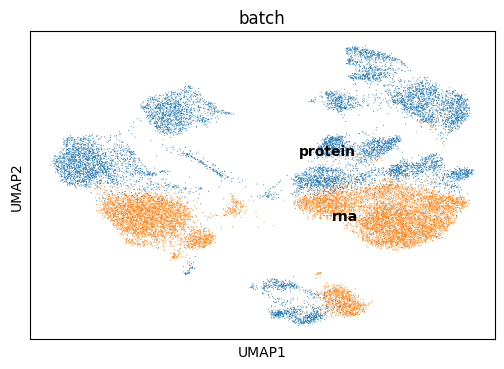

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.783,
lv2 matching acc: 0.534.
For All matchings: FOSCTTM score: 0.25920742, 
Knn Alignment score: [0.001  0.0023 0.0031 0.0043 0.0051 0.0058 0.0064 0.0079 0.0089 0.0094
 0.0109 0.0118 0.0128 0.0134 0.0142 0.0149 0.0156 0.0162 0.0173 0.0175
 0.0182 0.0187 0.0195 0.0205 0.0212]
For All matchings: Silhouette F1 score for lv1: 0.49219991917337474, 
Silhouette F1 score for lv2: 0.4795919257093205



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  3.6765958070755005
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.843,
lv2 matching acc: 0.588.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.823,
lv2 matching acc: 0.571.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


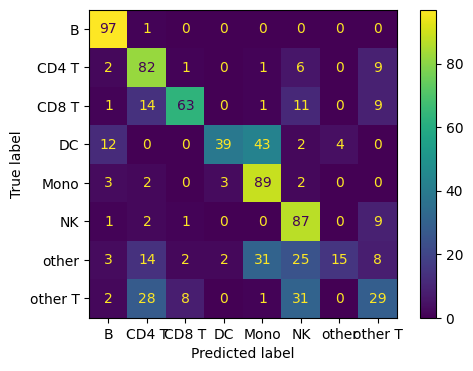

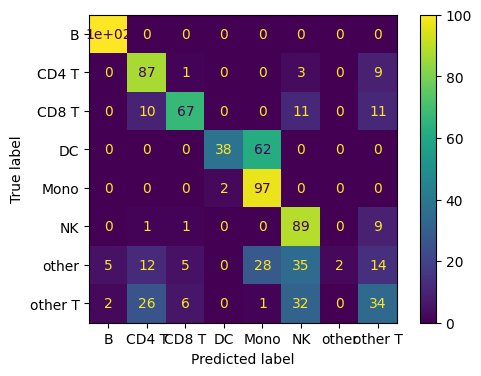

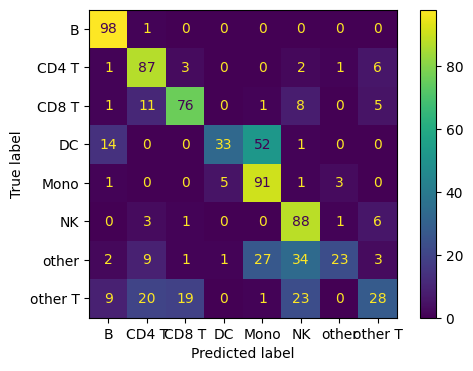

Epoch: 400: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 400: 40it [00:08,  4.59it/s]


RNA Recon Loss: 2.2316, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4593, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8268, Protein KL Div Z: 0.5932, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5413, Shared Recon Loss Gene: 0.2650, Shared Recon Loss Protein: 1.8089 Cross Loss Protein: 0.5420


Epoch: 401: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.2384, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4590, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8254, Protein KL Div Z: 0.5940, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5402, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8122 Cross Loss Protein: 0.5428


Epoch: 402: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.2356, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4587, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.8240, Protein KL Div Z: 0.5939, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5392, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8126 Cross Loss Protein: 0.5433


Epoch: 403: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2380, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4591, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.8240, Protein KL Div Z: 0.5933, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5411, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8129 Cross Loss Protein: 0.5430


Epoch: 404: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.2501, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4588, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8266, Protein KL Div Z: 0.5943, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5389, Shared Recon Loss Gene: 0.2668, Shared Recon Loss Protein: 1.8136 Cross Loss Protein: 0.5441


Epoch: 405: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2303, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4589, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.8300, Protein KL Div Z: 0.5958, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5392, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8249 Cross Loss Protein: 0.5458


Epoch: 406: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2344, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4585, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.8232, Protein KL Div Z: 0.5940, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5385, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8122 Cross Loss Protein: 0.5426


Epoch: 407: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2416, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4591, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8225, Protein KL Div Z: 0.5915, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5369, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8098 Cross Loss Protein: 0.5421


Epoch: 408: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2401, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4586, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8266, Protein KL Div Z: 0.5938, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5371, Shared Recon Loss Gene: 0.2644, Shared Recon Loss Protein: 1.8110 Cross Loss Protein: 0.5427


Epoch: 409: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2343, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4594, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8290, Protein KL Div Z: 0.5913, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5371, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8083 Cross Loss Protein: 0.5422


Epoch: 410: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.2337, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4586, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8317, Protein KL Div Z: 0.5915, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5366, Shared Recon Loss Gene: 0.2648, Shared Recon Loss Protein: 1.8082 Cross Loss Protein: 0.5420


Epoch: 411: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2315, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4598, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8237, Protein KL Div Z: 0.5882, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5359, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8088 Cross Loss Protein: 0.5418


Epoch: 412: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2247, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4591, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.8248, Protein KL Div Z: 0.5880, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5352, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8086 Cross Loss Protein: 0.5421


Epoch: 413: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2274, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4590, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.8221, Protein KL Div Z: 0.5891, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5363, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8072 Cross Loss Protein: 0.5420


Epoch: 414: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2443, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4589, Protein Recon Loss: 0.4938, Protein KL Div Back Pro: 0.8264, Protein KL Div Z: 0.5879, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5358, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8120 Cross Loss Protein: 0.5433


Epoch: 415: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2294, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4594, Protein Recon Loss: 0.4931, Protein KL Div Back Pro: 0.8238, Protein KL Div Z: 0.5864, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5356, Shared Recon Loss Gene: 0.2655, Shared Recon Loss Protein: 1.8150 Cross Loss Protein: 0.5439


Epoch: 416: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2274, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4596, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.8198, Protein KL Div Z: 0.5861, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5352, Shared Recon Loss Gene: 0.2650, Shared Recon Loss Protein: 1.8091 Cross Loss Protein: 0.5414


Epoch: 417: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2220, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4594, Protein Recon Loss: 0.4930, Protein KL Div Back Pro: 0.8242, Protein KL Div Z: 0.5876, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5355, Shared Recon Loss Gene: 0.2644, Shared Recon Loss Protein: 1.8137 Cross Loss Protein: 0.5437


Epoch: 418: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2090, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4600, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8258, Protein KL Div Z: 0.5849, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5344, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8104 Cross Loss Protein: 0.5432


Epoch: 419: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.2231, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4598, Protein Recon Loss: 0.4932, Protein KL Div Back Pro: 0.8265, Protein KL Div Z: 0.5858, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5341, Shared Recon Loss Gene: 0.2648, Shared Recon Loss Protein: 1.8117 Cross Loss Protein: 0.5435


Epoch: 420: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.2168, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4585, Protein Recon Loss: 0.4934, Protein KL Div Back Pro: 0.8272, Protein KL Div Z: 0.5829, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5346, Shared Recon Loss Gene: 0.2636, Shared Recon Loss Protein: 1.8115 Cross Loss Protein: 0.5439


Epoch: 421: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2200, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4592, Protein Recon Loss: 0.4903, Protein KL Div Back Pro: 0.8229, Protein KL Div Z: 0.5815, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5333, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8113 Cross Loss Protein: 0.5422


Epoch: 422: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2256, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4597, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8237, Protein KL Div Z: 0.5840, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5343, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8104 Cross Loss Protein: 0.5421


Epoch: 423: 40it [00:09,  4.43it/s]


RNA Recon Loss: 2.2534, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4597, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8214, Protein KL Div Z: 0.5838, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5337, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8101 Cross Loss Protein: 0.5424


Epoch: 424: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2259, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4591, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.8242, Protein KL Div Z: 0.5858, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5320, Shared Recon Loss Gene: 0.2648, Shared Recon Loss Protein: 1.8072 Cross Loss Protein: 0.5428


Epoch: 425: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.2304, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4593, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8232, Protein KL Div Z: 0.5835, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5326, Shared Recon Loss Gene: 0.2639, Shared Recon Loss Protein: 1.8087 Cross Loss Protein: 0.5426


Epoch: 426: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2207, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4593, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8219, Protein KL Div Z: 0.5855, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5319, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8109 Cross Loss Protein: 0.5429


Epoch: 427: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2335, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4595, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8184, Protein KL Div Z: 0.5832, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5319, Shared Recon Loss Gene: 0.2639, Shared Recon Loss Protein: 1.8116 Cross Loss Protein: 0.5424


Epoch: 428: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2352, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4589, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8217, Protein KL Div Z: 0.5843, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5311, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8091 Cross Loss Protein: 0.5429


Epoch: 429: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2387, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4598, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8229, Protein KL Div Z: 0.5843, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5323, Shared Recon Loss Gene: 0.2645, Shared Recon Loss Protein: 1.8103 Cross Loss Protein: 0.5425


Epoch: 430: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2290, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4587, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.8247, Protein KL Div Z: 0.5835, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5317, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8099 Cross Loss Protein: 0.5434


Epoch: 431: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2210, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4593, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8193, Protein KL Div Z: 0.5831, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5312, Shared Recon Loss Gene: 0.2648, Shared Recon Loss Protein: 1.8159 Cross Loss Protein: 0.5437


Epoch: 432: 40it [00:09,  4.41it/s]


RNA Recon Loss: 2.2140, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4590, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.8263, Protein KL Div Z: 0.5805, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5316, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8141 Cross Loss Protein: 0.5431


Epoch: 433: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2276, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4601, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8205, Protein KL Div Z: 0.5796, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5304, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8097 Cross Loss Protein: 0.5425


Epoch: 434: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2334, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4597, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8232, Protein KL Div Z: 0.5820, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5319, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8096 Cross Loss Protein: 0.5422


Epoch: 435: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2464, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4611, Protein Recon Loss: 0.4909, Protein KL Div Back Pro: 0.8204, Protein KL Div Z: 0.5809, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5300, Shared Recon Loss Gene: 0.2661, Shared Recon Loss Protein: 1.8132 Cross Loss Protein: 0.5435


Epoch: 436: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2381, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4619, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8242, Protein KL Div Z: 0.5816, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5307, Shared Recon Loss Gene: 0.2657, Shared Recon Loss Protein: 1.8124 Cross Loss Protein: 0.5435


Epoch: 437: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2197, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4627, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8166, Protein KL Div Z: 0.5815, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5292, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8086 Cross Loss Protein: 0.5420


Epoch: 438: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2161, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4624, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8209, Protein KL Div Z: 0.5798, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5303, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8099 Cross Loss Protein: 0.5431


Epoch: 439: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2038, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4628, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8184, Protein KL Div Z: 0.5782, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5290, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8114 Cross Loss Protein: 0.5427


Epoch: 440: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2171, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4633, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8153, Protein KL Div Z: 0.5785, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5293, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8057 Cross Loss Protein: 0.5422


Epoch: 441: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2167, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4623, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.8158, Protein KL Div Z: 0.5793, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5283, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8065 Cross Loss Protein: 0.5425


Epoch: 442: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2036, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4627, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.8161, Protein KL Div Z: 0.5764, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5285, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8088 Cross Loss Protein: 0.5417


Epoch: 443: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2010, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4625, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8193, Protein KL Div Z: 0.5783, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5274, Shared Recon Loss Gene: 0.2633, Shared Recon Loss Protein: 1.8083 Cross Loss Protein: 0.5423


Epoch: 444: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2185, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4625, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.8229, Protein KL Div Z: 0.5779, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5279, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8130 Cross Loss Protein: 0.5429


Epoch: 445: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2121, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4621, Protein Recon Loss: 0.4924, Protein KL Div Back Pro: 0.8244, Protein KL Div Z: 0.5771, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5270, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8142 Cross Loss Protein: 0.5435


Epoch: 446: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.2105, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4627, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8247, Protein KL Div Z: 0.5770, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5297, Shared Recon Loss Gene: 0.2645, Shared Recon Loss Protein: 1.8116 Cross Loss Protein: 0.5425


Epoch: 447: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2190, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4620, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8219, Protein KL Div Z: 0.5759, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5253, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8077 Cross Loss Protein: 0.5431


Epoch: 448: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2102, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4620, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8243, Protein KL Div Z: 0.5770, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5263, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8051 Cross Loss Protein: 0.5408


Epoch: 449: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2174, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4623, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.8250, Protein KL Div Z: 0.5762, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5254, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8141 Cross Loss Protein: 0.5434


Epoch: 450: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2098, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4631, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8249, Protein KL Div Z: 0.5776, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5265, Shared Recon Loss Gene: 0.2651, Shared Recon Loss Protein: 1.8126 Cross Loss Protein: 0.5431


Epoch: 451: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2279, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4626, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8223, Protein KL Div Z: 0.5768, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5267, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8092 Cross Loss Protein: 0.5422


Epoch: 452: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2094, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4627, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8198, Protein KL Div Z: 0.5751, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5246, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8079 Cross Loss Protein: 0.5424


Epoch: 453: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.2161, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4629, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8170, Protein KL Div Z: 0.5749, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5244, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8079 Cross Loss Protein: 0.5425


Epoch: 454: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2206, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4619, Protein Recon Loss: 0.4935, Protein KL Div Back Pro: 0.8183, Protein KL Div Z: 0.5748, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5246, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8102 Cross Loss Protein: 0.5435


Epoch: 455: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2214, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4627, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.8221, Protein KL Div Z: 0.5750, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5250, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8105 Cross Loss Protein: 0.5448


Epoch: 456: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2126, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4644, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8164, Protein KL Div Z: 0.5715, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5241, Shared Recon Loss Gene: 0.2648, Shared Recon Loss Protein: 1.8104 Cross Loss Protein: 0.5425


Epoch: 457: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2103, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4625, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8156, Protein KL Div Z: 0.5717, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5225, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8108 Cross Loss Protein: 0.5425


Epoch: 458: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2005, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4636, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.8182, Protein KL Div Z: 0.5734, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5241, Shared Recon Loss Gene: 0.2633, Shared Recon Loss Protein: 1.8078 Cross Loss Protein: 0.5412


Epoch: 459: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.2021, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4632, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8172, Protein KL Div Z: 0.5717, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5211, Shared Recon Loss Gene: 0.2648, Shared Recon Loss Protein: 1.8135 Cross Loss Protein: 0.5437


Epoch: 460: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.2032, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4629, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.8175, Protein KL Div Z: 0.5720, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5219, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8064 Cross Loss Protein: 0.5424


Epoch: 461: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.2034, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4634, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8182, Protein KL Div Z: 0.5710, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5215, Shared Recon Loss Gene: 0.2634, Shared Recon Loss Protein: 1.8108 Cross Loss Protein: 0.5423


Epoch: 462: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.2188, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4635, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8206, Protein KL Div Z: 0.5722, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5212, Shared Recon Loss Gene: 0.2653, Shared Recon Loss Protein: 1.8127 Cross Loss Protein: 0.5431


Epoch: 463: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.2033, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4630, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8189, Protein KL Div Z: 0.5705, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5211, Shared Recon Loss Gene: 0.2634, Shared Recon Loss Protein: 1.8082 Cross Loss Protein: 0.5420


Epoch: 464: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1997, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4623, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8184, Protein KL Div Z: 0.5716, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5205, Shared Recon Loss Gene: 0.2633, Shared Recon Loss Protein: 1.8086 Cross Loss Protein: 0.5415


Epoch: 465: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2037, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4628, Protein Recon Loss: 0.4931, Protein KL Div Back Pro: 0.8181, Protein KL Div Z: 0.5687, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5215, Shared Recon Loss Gene: 0.2644, Shared Recon Loss Protein: 1.8163 Cross Loss Protein: 0.5429


Epoch: 466: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1916, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4623, Protein Recon Loss: 0.4909, Protein KL Div Back Pro: 0.8205, Protein KL Div Z: 0.5689, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5220, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8146 Cross Loss Protein: 0.5431


Epoch: 467: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2036, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4634, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8152, Protein KL Div Z: 0.5680, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5201, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8085 Cross Loss Protein: 0.5430


Epoch: 468: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2029, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4640, Protein Recon Loss: 0.4918, Protein KL Div Back Pro: 0.8183, Protein KL Div Z: 0.5696, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5204, Shared Recon Loss Gene: 0.2634, Shared Recon Loss Protein: 1.8064 Cross Loss Protein: 0.5422


Epoch: 469: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.1901, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4634, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.8138, Protein KL Div Z: 0.5680, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5204, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8141 Cross Loss Protein: 0.5432


Epoch: 470: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1955, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4631, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8146, Protein KL Div Z: 0.5663, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5195, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8065 Cross Loss Protein: 0.5418


Epoch: 471: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1991, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4632, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8163, Protein KL Div Z: 0.5676, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5200, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8110 Cross Loss Protein: 0.5427


Epoch: 472: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2044, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4634, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.8186, Protein KL Div Z: 0.5684, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5169, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8147 Cross Loss Protein: 0.5435


Epoch: 473: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.2001, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4633, Protein Recon Loss: 0.4918, Protein KL Div Back Pro: 0.8158, Protein KL Div Z: 0.5668, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5180, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8123 Cross Loss Protein: 0.5424


Epoch: 474: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2052, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4639, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.8134, Protein KL Div Z: 0.5676, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5195, Shared Recon Loss Gene: 0.2645, Shared Recon Loss Protein: 1.8084 Cross Loss Protein: 0.5417


Epoch: 475: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2068, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4635, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8107, Protein KL Div Z: 0.5670, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5190, Shared Recon Loss Gene: 0.2632, Shared Recon Loss Protein: 1.8079 Cross Loss Protein: 0.5421


Epoch: 476: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2013, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4644, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8140, Protein KL Div Z: 0.5668, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5177, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8063 Cross Loss Protein: 0.5416


Epoch: 477: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.2096, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4634, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8135, Protein KL Div Z: 0.5675, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5179, Shared Recon Loss Gene: 0.2639, Shared Recon Loss Protein: 1.8113 Cross Loss Protein: 0.5432


Epoch: 478: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2014, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4640, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8165, Protein KL Div Z: 0.5638, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5169, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8103 Cross Loss Protein: 0.5422


Epoch: 479: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1963, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4642, Protein Recon Loss: 0.4909, Protein KL Div Back Pro: 0.8145, Protein KL Div Z: 0.5641, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5175, Shared Recon Loss Gene: 0.2633, Shared Recon Loss Protein: 1.8056 Cross Loss Protein: 0.5420


Epoch: 480: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2059, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4636, Protein Recon Loss: 0.4903, Protein KL Div Back Pro: 0.8151, Protein KL Div Z: 0.5643, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5175, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8082 Cross Loss Protein: 0.5420


Epoch: 481: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2007, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4643, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8203, Protein KL Div Z: 0.5653, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5154, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8062 Cross Loss Protein: 0.5422


Epoch: 482: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1937, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4643, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.8167, Protein KL Div Z: 0.5616, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5169, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8068 Cross Loss Protein: 0.5415


Epoch: 483: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1942, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4639, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8164, Protein KL Div Z: 0.5610, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5171, Shared Recon Loss Gene: 0.2634, Shared Recon Loss Protein: 1.8069 Cross Loss Protein: 0.5419


Epoch: 484: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1978, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4644, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.8118, Protein KL Div Z: 0.5596, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5155, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8103 Cross Loss Protein: 0.5424


Epoch: 485: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.2084, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4642, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8186, Protein KL Div Z: 0.5624, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5158, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8076 Cross Loss Protein: 0.5416


Epoch: 486: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1877, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4640, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.8143, Protein KL Div Z: 0.5604, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5156, Shared Recon Loss Gene: 0.2633, Shared Recon Loss Protein: 1.8093 Cross Loss Protein: 0.5425


Epoch: 487: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1995, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4645, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8157, Protein KL Div Z: 0.5612, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5162, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8056 Cross Loss Protein: 0.5425


Epoch: 488: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1974, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4650, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8133, Protein KL Div Z: 0.5604, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5152, Shared Recon Loss Gene: 0.2634, Shared Recon Loss Protein: 1.8063 Cross Loss Protein: 0.5416


Epoch: 489: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.2056, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4641, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8157, Protein KL Div Z: 0.5618, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5148, Shared Recon Loss Gene: 0.2632, Shared Recon Loss Protein: 1.8063 Cross Loss Protein: 0.5421


Epoch: 490: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1886, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4646, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8155, Protein KL Div Z: 0.5623, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5141, Shared Recon Loss Gene: 0.2625, Shared Recon Loss Protein: 1.8063 Cross Loss Protein: 0.5417


Epoch: 491: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.2029, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4648, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8139, Protein KL Div Z: 0.5605, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5128, Shared Recon Loss Gene: 0.2636, Shared Recon Loss Protein: 1.8106 Cross Loss Protein: 0.5415


Epoch: 492: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1977, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4641, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8128, Protein KL Div Z: 0.5608, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5143, Shared Recon Loss Gene: 0.2633, Shared Recon Loss Protein: 1.8075 Cross Loss Protein: 0.5418


Epoch: 493: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1914, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4637, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.8125, Protein KL Div Z: 0.5602, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5137, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8047 Cross Loss Protein: 0.5414


Epoch: 494: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1897, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4644, Protein Recon Loss: 0.4905, Protein KL Div Back Pro: 0.8150, Protein KL Div Z: 0.5600, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5151, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8057 Cross Loss Protein: 0.5417


Epoch: 495: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1930, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4634, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.8135, Protein KL Div Z: 0.5595, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5128, Shared Recon Loss Gene: 0.2625, Shared Recon Loss Protein: 1.8110 Cross Loss Protein: 0.5430


Epoch: 496: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1894, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4638, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8184, Protein KL Div Z: 0.5611, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5121, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8086 Cross Loss Protein: 0.5411


Epoch: 497: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1886, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4640, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8159, Protein KL Div Z: 0.5602, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5136, Shared Recon Loss Gene: 0.2636, Shared Recon Loss Protein: 1.8084 Cross Loss Protein: 0.5420


Epoch: 498: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1919, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4650, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.8142, Protein KL Div Z: 0.5591, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5127, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8072 Cross Loss Protein: 0.5419


Epoch: 499: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1964, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4648, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8153, Protein KL Div Z: 0.5602, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5131, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8111 Cross Loss Protein: 0.5429


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


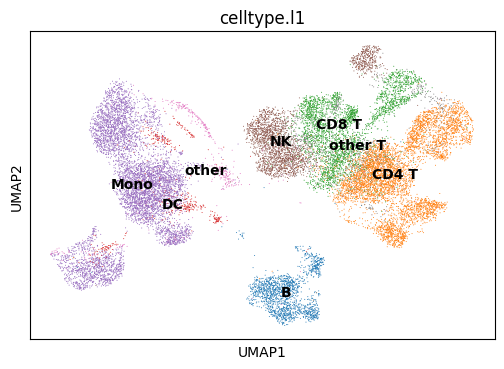

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


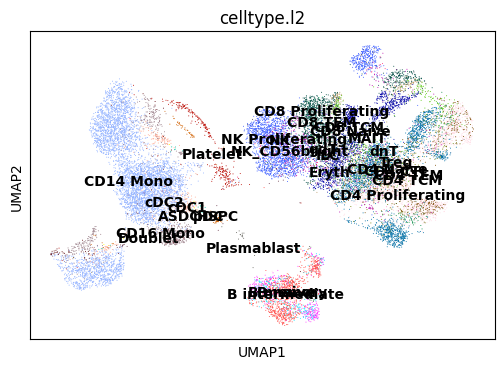

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


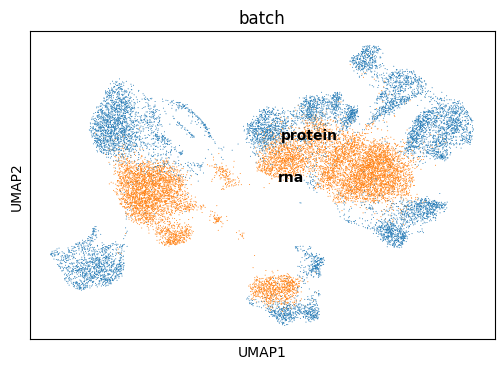

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.770,
lv2 matching acc: 0.554.
For All matchings: FOSCTTM score: 0.24461115, 
Knn Alignment score: [0.0021 0.0035 0.0041 0.005  0.0059 0.0073 0.0082 0.009  0.0096 0.0109
 0.0116 0.0124 0.0134 0.0142 0.0158 0.0165 0.0176 0.0185 0.0194 0.0201
 0.021  0.0218 0.0219 0.0225 0.0235]
For All matchings: Silhouette F1 score for lv1: 0.49925415161374115, 
Silhouette F1 score for lv2: 0.4861142418711652


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])





Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  3.3938357830047607
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.860,
lv2 matching acc: 0.640.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.795,
lv2 matching acc: 0.568.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


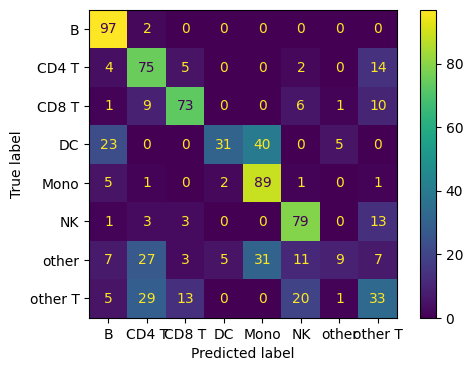

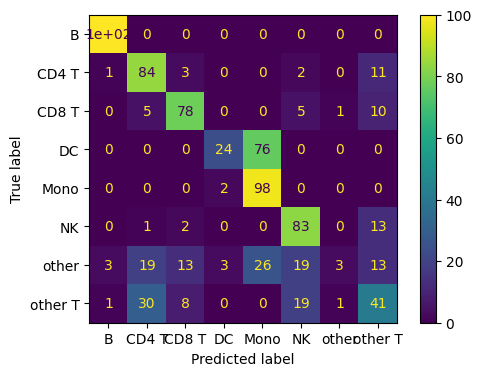

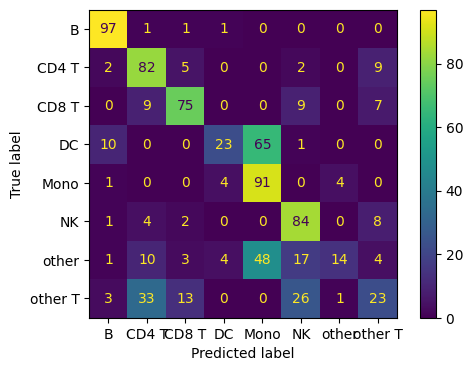

Epoch: 500: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 500: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.1927, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4656, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8189, Protein KL Div Z: 0.5596, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5105, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8086 Cross Loss Protein: 0.5423


Epoch: 501: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.2003, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4672, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8141, Protein KL Div Z: 0.5574, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5112, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8078 Cross Loss Protein: 0.5419


Epoch: 502: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.1875, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4662, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8174, Protein KL Div Z: 0.5597, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5119, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8069 Cross Loss Protein: 0.5422


Epoch: 503: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1918, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4662, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8165, Protein KL Div Z: 0.5585, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5125, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8091 Cross Loss Protein: 0.5424


Epoch: 504: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.1920, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4666, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8162, Protein KL Div Z: 0.5595, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5122, Shared Recon Loss Gene: 0.2636, Shared Recon Loss Protein: 1.8056 Cross Loss Protein: 0.5416


Epoch: 505: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1797, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4665, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8126, Protein KL Div Z: 0.5592, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5119, Shared Recon Loss Gene: 0.2632, Shared Recon Loss Protein: 1.8042 Cross Loss Protein: 0.5412


Epoch: 506: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1825, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4662, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8091, Protein KL Div Z: 0.5581, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5112, Shared Recon Loss Gene: 0.2625, Shared Recon Loss Protein: 1.8081 Cross Loss Protein: 0.5421


Epoch: 507: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1881, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4664, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8107, Protein KL Div Z: 0.5579, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5099, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8096 Cross Loss Protein: 0.5426


Epoch: 508: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1835, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4659, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8087, Protein KL Div Z: 0.5557, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5099, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8055 Cross Loss Protein: 0.5412


Epoch: 509: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1798, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4663, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8140, Protein KL Div Z: 0.5592, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5105, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8076 Cross Loss Protein: 0.5425


Epoch: 510: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1840, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4664, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8104, Protein KL Div Z: 0.5600, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5103, Shared Recon Loss Gene: 0.2618, Shared Recon Loss Protein: 1.8042 Cross Loss Protein: 0.5412


Epoch: 511: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1905, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4661, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.8094, Protein KL Div Z: 0.5561, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5093, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8058 Cross Loss Protein: 0.5424


Epoch: 512: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1753, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4670, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8110, Protein KL Div Z: 0.5544, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5089, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8075 Cross Loss Protein: 0.5421


Epoch: 513: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1742, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4673, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8135, Protein KL Div Z: 0.5569, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5106, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8063 Cross Loss Protein: 0.5422


Epoch: 514: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1785, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4669, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.8125, Protein KL Div Z: 0.5524, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5087, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8083 Cross Loss Protein: 0.5436


Epoch: 515: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1982, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4681, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8223, Protein KL Div Z: 0.5548, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5090, Shared Recon Loss Gene: 0.2650, Shared Recon Loss Protein: 1.8094 Cross Loss Protein: 0.5434


Epoch: 516: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1845, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4670, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8096, Protein KL Div Z: 0.5530, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5077, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8092 Cross Loss Protein: 0.5418


Epoch: 517: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1846, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4663, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8093, Protein KL Div Z: 0.5523, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5078, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8072 Cross Loss Protein: 0.5422


Epoch: 518: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1857, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4670, Protein Recon Loss: 0.4905, Protein KL Div Back Pro: 0.8101, Protein KL Div Z: 0.5544, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5079, Shared Recon Loss Gene: 0.2632, Shared Recon Loss Protein: 1.8060 Cross Loss Protein: 0.5418


Epoch: 519: 40it [00:09,  4.43it/s]


RNA Recon Loss: 2.1790, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4663, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8080, Protein KL Div Z: 0.5531, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5065, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8069 Cross Loss Protein: 0.5429


Epoch: 520: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1937, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4673, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.8102, Protein KL Div Z: 0.5533, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5074, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8069 Cross Loss Protein: 0.5426


Epoch: 521: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1803, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4667, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.8114, Protein KL Div Z: 0.5541, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5074, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8045 Cross Loss Protein: 0.5417


Epoch: 522: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1809, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4669, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8127, Protein KL Div Z: 0.5525, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5070, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8052 Cross Loss Protein: 0.5413


Epoch: 523: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1928, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4685, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.8133, Protein KL Div Z: 0.5535, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5060, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8051 Cross Loss Protein: 0.5411


Epoch: 524: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.2030, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4675, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8057, Protein KL Div Z: 0.5519, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5063, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8049 Cross Loss Protein: 0.5419


Epoch: 525: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1884, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4678, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8089, Protein KL Div Z: 0.5505, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5068, Shared Recon Loss Gene: 0.2625, Shared Recon Loss Protein: 1.8073 Cross Loss Protein: 0.5420


Epoch: 526: 40it [00:09,  4.40it/s]


RNA Recon Loss: 2.1763, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4692, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8102, Protein KL Div Z: 0.5522, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5059, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8078 Cross Loss Protein: 0.5418


Epoch: 527: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1818, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4684, Protein Recon Loss: 0.4909, Protein KL Div Back Pro: 0.8083, Protein KL Div Z: 0.5510, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5053, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8081 Cross Loss Protein: 0.5429


Epoch: 528: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1857, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4681, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8100, Protein KL Div Z: 0.5517, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5063, Shared Recon Loss Gene: 0.2632, Shared Recon Loss Protein: 1.8061 Cross Loss Protein: 0.5424


Epoch: 529: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1766, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4689, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8105, Protein KL Div Z: 0.5512, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5058, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8064 Cross Loss Protein: 0.5416


Epoch: 530: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1733, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4681, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8111, Protein KL Div Z: 0.5512, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5050, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8040 Cross Loss Protein: 0.5410


Epoch: 531: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1795, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4685, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8171, Protein KL Div Z: 0.5510, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5034, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8053 Cross Loss Protein: 0.5421


Epoch: 532: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1733, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4687, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8128, Protein KL Div Z: 0.5524, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5034, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8085 Cross Loss Protein: 0.5426


Epoch: 533: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1917, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4677, Protein Recon Loss: 0.4929, Protein KL Div Back Pro: 0.8165, Protein KL Div Z: 0.5481, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5030, Shared Recon Loss Gene: 0.2632, Shared Recon Loss Protein: 1.8102 Cross Loss Protein: 0.5429


Epoch: 534: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1948, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4694, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8100, Protein KL Div Z: 0.5463, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5022, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8075 Cross Loss Protein: 0.5410


Epoch: 535: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1757, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4686, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8086, Protein KL Div Z: 0.5468, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5007, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8092 Cross Loss Protein: 0.5418


Epoch: 536: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1752, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4691, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8096, Protein KL Div Z: 0.5445, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5023, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8056 Cross Loss Protein: 0.5415


Epoch: 537: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1878, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4691, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8162, Protein KL Div Z: 0.5487, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5019, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8084 Cross Loss Protein: 0.5423


Epoch: 538: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1897, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4701, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8127, Protein KL Div Z: 0.5469, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5020, Shared Recon Loss Gene: 0.2633, Shared Recon Loss Protein: 1.8047 Cross Loss Protein: 0.5417


Epoch: 539: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1822, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4699, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8126, Protein KL Div Z: 0.5476, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5003, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8048 Cross Loss Protein: 0.5406


Epoch: 540: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1674, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4700, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.8132, Protein KL Div Z: 0.5454, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5011, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8053 Cross Loss Protein: 0.5421


Epoch: 541: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1674, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4700, Protein Recon Loss: 0.4918, Protein KL Div Back Pro: 0.8102, Protein KL Div Z: 0.5439, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5012, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8080 Cross Loss Protein: 0.5429


Epoch: 542: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1635, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4708, Protein Recon Loss: 0.4929, Protein KL Div Back Pro: 0.8159, Protein KL Div Z: 0.5439, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5016, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8047 Cross Loss Protein: 0.5422


Epoch: 543: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1663, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4708, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8122, Protein KL Div Z: 0.5442, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5006, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8060 Cross Loss Protein: 0.5421


Epoch: 544: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1682, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4707, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8138, Protein KL Div Z: 0.5443, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5011, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8070 Cross Loss Protein: 0.5417


Epoch: 545: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1752, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4710, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.8101, Protein KL Div Z: 0.5433, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4998, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8050 Cross Loss Protein: 0.5413


Epoch: 546: 40it [00:09,  4.37it/s]


RNA Recon Loss: 2.1701, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4702, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.8113, Protein KL Div Z: 0.5420, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5009, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8045 Cross Loss Protein: 0.5408


Epoch: 547: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1790, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4698, Protein Recon Loss: 0.4918, Protein KL Div Back Pro: 0.8108, Protein KL Div Z: 0.5400, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5001, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8089 Cross Loss Protein: 0.5425


Epoch: 548: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1707, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4698, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8108, Protein KL Div Z: 0.5420, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4992, Shared Recon Loss Gene: 0.2618, Shared Recon Loss Protein: 1.8043 Cross Loss Protein: 0.5411


Epoch: 549: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1672, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4695, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8087, Protein KL Div Z: 0.5422, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4988, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8070 Cross Loss Protein: 0.5411


Epoch: 550: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1704, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4695, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8136, Protein KL Div Z: 0.5430, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5012, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8080 Cross Loss Protein: 0.5423


Epoch: 551: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1706, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4697, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8084, Protein KL Div Z: 0.5392, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4973, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8084 Cross Loss Protein: 0.5425


Epoch: 552: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1652, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4698, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8101, Protein KL Div Z: 0.5392, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4982, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8043 Cross Loss Protein: 0.5406


Epoch: 553: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1642, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4703, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8081, Protein KL Div Z: 0.5395, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4975, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8061 Cross Loss Protein: 0.5415


Epoch: 554: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1684, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4702, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8051, Protein KL Div Z: 0.5391, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4958, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8106 Cross Loss Protein: 0.5424


Epoch: 555: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1640, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4701, Protein Recon Loss: 0.4905, Protein KL Div Back Pro: 0.8054, Protein KL Div Z: 0.5401, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4963, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8073 Cross Loss Protein: 0.5426


Epoch: 556: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1706, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4710, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.8068, Protein KL Div Z: 0.5417, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4955, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8093 Cross Loss Protein: 0.5430


Epoch: 557: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1666, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4706, Protein Recon Loss: 0.4931, Protein KL Div Back Pro: 0.8091, Protein KL Div Z: 0.5383, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4964, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8094 Cross Loss Protein: 0.5427


Epoch: 558: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1835, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4710, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8111, Protein KL Div Z: 0.5370, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4970, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8128 Cross Loss Protein: 0.5432


Epoch: 559: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1970, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4711, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8068, Protein KL Div Z: 0.5361, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4964, Shared Recon Loss Gene: 0.2636, Shared Recon Loss Protein: 1.8062 Cross Loss Protein: 0.5417


Epoch: 560: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1772, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4718, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8087, Protein KL Div Z: 0.5389, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4962, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8095 Cross Loss Protein: 0.5415


Epoch: 561: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1767, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4722, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8081, Protein KL Div Z: 0.5387, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4956, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8083 Cross Loss Protein: 0.5413


Epoch: 562: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1612, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4717, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8058, Protein KL Div Z: 0.5399, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4970, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8084 Cross Loss Protein: 0.5420


Epoch: 563: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1606, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4717, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8060, Protein KL Div Z: 0.5403, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4970, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8041 Cross Loss Protein: 0.5412


Epoch: 564: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1666, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4713, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8044, Protein KL Div Z: 0.5392, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4955, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8063 Cross Loss Protein: 0.5420


Epoch: 565: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1724, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4704, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8005, Protein KL Div Z: 0.5377, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4961, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8037 Cross Loss Protein: 0.5414


Epoch: 566: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1698, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4721, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8071, Protein KL Div Z: 0.5410, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4955, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8055 Cross Loss Protein: 0.5417


Epoch: 567: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1647, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4712, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8048, Protein KL Div Z: 0.5396, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4954, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8034 Cross Loss Protein: 0.5410


Epoch: 568: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1725, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4724, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8042, Protein KL Div Z: 0.5387, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4956, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8044 Cross Loss Protein: 0.5413


Epoch: 569: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1638, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4726, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8055, Protein KL Div Z: 0.5407, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4951, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8067 Cross Loss Protein: 0.5420


Epoch: 570: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1777, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4721, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8018, Protein KL Div Z: 0.5371, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4948, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8033 Cross Loss Protein: 0.5417


Epoch: 571: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1652, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4729, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8031, Protein KL Div Z: 0.5378, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4939, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8047 Cross Loss Protein: 0.5420


Epoch: 572: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1685, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4720, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8077, Protein KL Div Z: 0.5361, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4939, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8039 Cross Loss Protein: 0.5416


Epoch: 573: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1593, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4716, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8081, Protein KL Div Z: 0.5375, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4935, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8029 Cross Loss Protein: 0.5416


Epoch: 574: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1623, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4713, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8046, Protein KL Div Z: 0.5369, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4931, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8031 Cross Loss Protein: 0.5411


Epoch: 575: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1604, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4723, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8057, Protein KL Div Z: 0.5367, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4929, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8092 Cross Loss Protein: 0.5433


Epoch: 576: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1880, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4712, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8040, Protein KL Div Z: 0.5345, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4939, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8136 Cross Loss Protein: 0.5428


Epoch: 577: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1899, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4729, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8070, Protein KL Div Z: 0.5360, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4926, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8058 Cross Loss Protein: 0.5412


Epoch: 578: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1661, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4722, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8089, Protein KL Div Z: 0.5354, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4925, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8040 Cross Loss Protein: 0.5414


Epoch: 579: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1648, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4721, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8067, Protein KL Div Z: 0.5357, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4929, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8031 Cross Loss Protein: 0.5414


Epoch: 580: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1614, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4724, Protein Recon Loss: 0.4909, Protein KL Div Back Pro: 0.8072, Protein KL Div Z: 0.5346, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4929, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8101 Cross Loss Protein: 0.5429


Epoch: 581: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1683, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4728, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8050, Protein KL Div Z: 0.5333, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4926, Shared Recon Loss Gene: 0.2618, Shared Recon Loss Protein: 1.8045 Cross Loss Protein: 0.5415


Epoch: 582: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1682, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4720, Protein Recon Loss: 0.4964, Protein KL Div Back Pro: 0.8034, Protein KL Div Z: 0.5339, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4915, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8061 Cross Loss Protein: 0.5459


Epoch: 583: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1670, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4728, Protein Recon Loss: 0.4963, Protein KL Div Back Pro: 0.8137, Protein KL Div Z: 0.5316, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4910, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8060 Cross Loss Protein: 0.5429


Epoch: 584: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1808, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4731, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8057, Protein KL Div Z: 0.5298, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4895, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8077 Cross Loss Protein: 0.5425


Epoch: 585: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1654, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4727, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8070, Protein KL Div Z: 0.5290, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4902, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8047 Cross Loss Protein: 0.5416


Epoch: 586: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1596, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4729, Protein Recon Loss: 0.4905, Protein KL Div Back Pro: 0.8078, Protein KL Div Z: 0.5313, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4884, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8044 Cross Loss Protein: 0.5414


Epoch: 587: 40it [00:09,  4.43it/s]


RNA Recon Loss: 2.1609, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4736, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8080, Protein KL Div Z: 0.5313, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4887, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8033 Cross Loss Protein: 0.5409


Epoch: 588: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1571, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4744, Protein Recon Loss: 0.4903, Protein KL Div Back Pro: 0.8086, Protein KL Div Z: 0.5300, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4895, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5408


Epoch: 589: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1652, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4739, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8057, Protein KL Div Z: 0.5296, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4891, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8043 Cross Loss Protein: 0.5417


Epoch: 590: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1597, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4734, Protein Recon Loss: 0.4918, Protein KL Div Back Pro: 0.8085, Protein KL Div Z: 0.5315, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4884, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8057 Cross Loss Protein: 0.5425


Epoch: 591: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1623, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4733, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.8113, Protein KL Div Z: 0.5294, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4885, Shared Recon Loss Gene: 0.2618, Shared Recon Loss Protein: 1.8066 Cross Loss Protein: 0.5425


Epoch: 592: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1522, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4739, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8079, Protein KL Div Z: 0.5292, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4889, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8037 Cross Loss Protein: 0.5412


Epoch: 593: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1609, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4729, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8093, Protein KL Div Z: 0.5294, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4890, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8087 Cross Loss Protein: 0.5420


Epoch: 594: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1668, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4737, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8097, Protein KL Div Z: 0.5285, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4879, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8046 Cross Loss Protein: 0.5410


Epoch: 595: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1556, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4735, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8071, Protein KL Div Z: 0.5290, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4868, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8051 Cross Loss Protein: 0.5424


Epoch: 596: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1628, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4730, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8092, Protein KL Div Z: 0.5298, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4869, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8172 Cross Loss Protein: 0.5428


Epoch: 597: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1622, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4738, Protein Recon Loss: 0.4905, Protein KL Div Back Pro: 0.8098, Protein KL Div Z: 0.5283, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4867, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8211 Cross Loss Protein: 0.5447


Epoch: 598: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1596, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4733, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8110, Protein KL Div Z: 0.5291, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4875, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8040 Cross Loss Protein: 0.5409


Epoch: 599: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1754, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4726, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8093, Protein KL Div Z: 0.5288, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4880, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8045 Cross Loss Protein: 0.5419


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


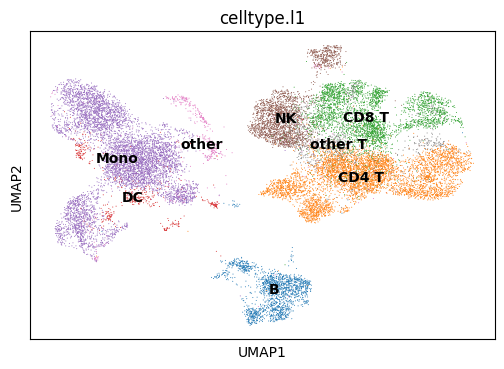

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


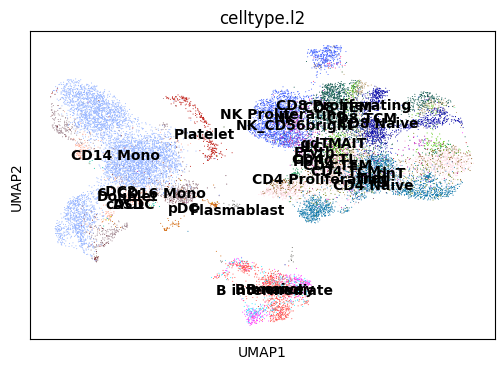

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


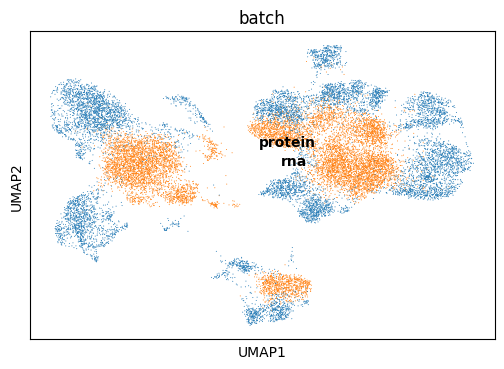

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.772,
lv2 matching acc: 0.578.
For All matchings: FOSCTTM score: 0.23175622000000004, 
Knn Alignment score: [0.0013 0.0029 0.0039 0.0049 0.0056 0.0068 0.0079 0.0088 0.0095 0.0104
 0.0111 0.0123 0.0129 0.0135 0.0143 0.0149 0.0158 0.017  0.0175 0.0188
 0.0199 0.0209 0.0218 0.0227 0.0235]
For All matchings: Silhouette F1 score for lv1: 0.5061654044004626, 
Silhouette F1 score for lv2: 0.49305975824968257



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  3.109065055847168
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.844,
lv2 matching acc: 0.650.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.798,
lv2 matching acc: 0.579.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


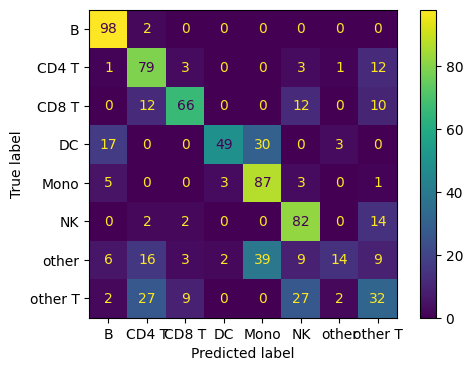

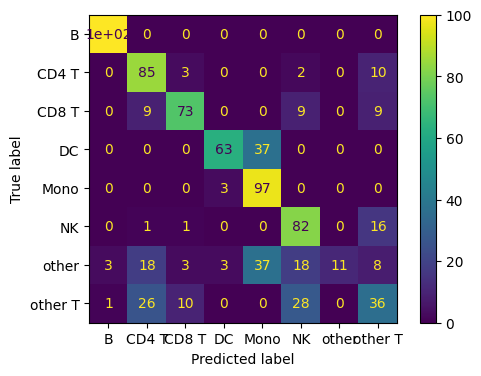

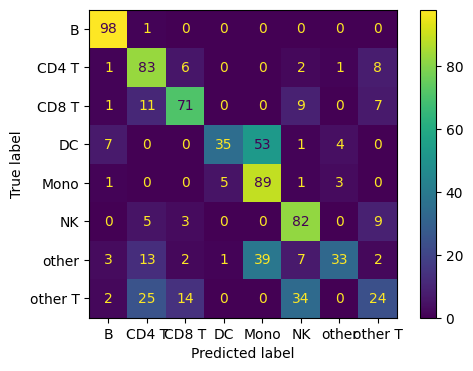

Epoch: 600: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 600: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1558, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4744, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8095, Protein KL Div Z: 0.5288, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4872, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8027 Cross Loss Protein: 0.5407


Epoch: 601: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1669, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4740, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8087, Protein KL Div Z: 0.5280, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4865, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8070 Cross Loss Protein: 0.5420


Epoch: 602: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1623, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4758, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8183, Protein KL Div Z: 0.5278, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4883, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8064 Cross Loss Protein: 0.5417


Epoch: 603: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1490, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4740, Protein Recon Loss: 0.4903, Protein KL Div Back Pro: 0.8109, Protein KL Div Z: 0.5263, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4869, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5407


Epoch: 604: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1585, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4753, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8089, Protein KL Div Z: 0.5260, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4870, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8026 Cross Loss Protein: 0.5416


Epoch: 605: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1505, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4753, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8038, Protein KL Div Z: 0.5247, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4869, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5410


Epoch: 606: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1548, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4753, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8097, Protein KL Div Z: 0.5257, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4864, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8055 Cross Loss Protein: 0.5428


Epoch: 607: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1552, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4755, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.8097, Protein KL Div Z: 0.5251, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4876, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8027 Cross Loss Protein: 0.5420


Epoch: 608: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1625, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4757, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8023, Protein KL Div Z: 0.5231, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4858, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8044 Cross Loss Protein: 0.5414


Epoch: 609: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1703, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4754, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8048, Protein KL Div Z: 0.5226, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4883, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8056 Cross Loss Protein: 0.5409


Epoch: 610: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1583, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4768, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8080, Protein KL Div Z: 0.5236, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4865, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8027 Cross Loss Protein: 0.5408


Epoch: 611: 40it [00:09,  4.40it/s]


RNA Recon Loss: 2.1681, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4757, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8073, Protein KL Div Z: 0.5233, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4863, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8021 Cross Loss Protein: 0.5410


Epoch: 612: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1652, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4756, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8104, Protein KL Div Z: 0.5246, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4848, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8026 Cross Loss Protein: 0.5410


Epoch: 613: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1494, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4753, Protein Recon Loss: 0.4903, Protein KL Div Back Pro: 0.8075, Protein KL Div Z: 0.5229, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4852, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8017 Cross Loss Protein: 0.5409


Epoch: 614: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1523, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4749, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8052, Protein KL Div Z: 0.5213, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4845, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8058 Cross Loss Protein: 0.5411


Epoch: 615: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1494, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4754, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8097, Protein KL Div Z: 0.5251, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4854, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8055 Cross Loss Protein: 0.5418


Epoch: 616: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1630, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4757, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8070, Protein KL Div Z: 0.5239, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4855, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8058 Cross Loss Protein: 0.5422


Epoch: 617: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1566, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4757, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8037, Protein KL Div Z: 0.5216, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4847, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8039 Cross Loss Protein: 0.5414


Epoch: 618: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1611, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4756, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8071, Protein KL Div Z: 0.5227, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4840, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8005 Cross Loss Protein: 0.5405


Epoch: 619: 40it [00:09,  4.38it/s]


RNA Recon Loss: 2.1512, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4755, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8082, Protein KL Div Z: 0.5221, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4842, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8048 Cross Loss Protein: 0.5419


Epoch: 620: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1600, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4762, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8058, Protein KL Div Z: 0.5228, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4839, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8036 Cross Loss Protein: 0.5408


Epoch: 621: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1657, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4759, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8059, Protein KL Div Z: 0.5228, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4829, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8037 Cross Loss Protein: 0.5417


Epoch: 622: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1635, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4773, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8014, Protein KL Div Z: 0.5208, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4825, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8030 Cross Loss Protein: 0.5414


Epoch: 623: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1546, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4761, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8047, Protein KL Div Z: 0.5226, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4818, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8058 Cross Loss Protein: 0.5411


Epoch: 624: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1574, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4751, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8055, Protein KL Div Z: 0.5222, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4830, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8035 Cross Loss Protein: 0.5414


Epoch: 625: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1503, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4769, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.8045, Protein KL Div Z: 0.5204, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4823, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8038 Cross Loss Protein: 0.5417


Epoch: 626: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1498, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4758, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8056, Protein KL Div Z: 0.5198, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4828, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8022 Cross Loss Protein: 0.5412


Epoch: 627: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1494, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4768, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8054, Protein KL Div Z: 0.5198, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4827, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8018 Cross Loss Protein: 0.5407


Epoch: 628: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1631, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4766, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8064, Protein KL Div Z: 0.5215, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4822, Shared Recon Loss Gene: 0.2625, Shared Recon Loss Protein: 1.8072 Cross Loss Protein: 0.5421


Epoch: 629: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1495, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4769, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8038, Protein KL Div Z: 0.5210, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4798, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8093 Cross Loss Protein: 0.5424


Epoch: 630: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1484, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4772, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.8053, Protein KL Div Z: 0.5206, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4806, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8068 Cross Loss Protein: 0.5423


Epoch: 631: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1481, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4774, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8069, Protein KL Div Z: 0.5170, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4809, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8037 Cross Loss Protein: 0.5413


Epoch: 632: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1583, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4765, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8036, Protein KL Div Z: 0.5178, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4813, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8038 Cross Loss Protein: 0.5409


Epoch: 633: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1569, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4770, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8023, Protein KL Div Z: 0.5191, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4803, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.7994 Cross Loss Protein: 0.5403


Epoch: 634: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1893, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4769, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.8045, Protein KL Div Z: 0.5176, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4809, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8050 Cross Loss Protein: 0.5417


Epoch: 635: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1575, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4773, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8035, Protein KL Div Z: 0.5153, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4798, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8063 Cross Loss Protein: 0.5417


Epoch: 636: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1516, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4774, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8069, Protein KL Div Z: 0.5158, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4802, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8042 Cross Loss Protein: 0.5415


Epoch: 637: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1489, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4771, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8055, Protein KL Div Z: 0.5144, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4799, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8022 Cross Loss Protein: 0.5413


Epoch: 638: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1458, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4775, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8058, Protein KL Div Z: 0.5137, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4796, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8067 Cross Loss Protein: 0.5419


Epoch: 639: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1542, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4776, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8119, Protein KL Div Z: 0.5136, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4801, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8085 Cross Loss Protein: 0.5424


Epoch: 640: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1604, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4771, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8085, Protein KL Div Z: 0.5131, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4795, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8014 Cross Loss Protein: 0.5407


Epoch: 641: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1538, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4776, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8015, Protein KL Div Z: 0.5140, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4778, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5412


Epoch: 642: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1495, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4770, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8064, Protein KL Div Z: 0.5146, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4807, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8046 Cross Loss Protein: 0.5422


Epoch: 643: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1457, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4783, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8034, Protein KL Div Z: 0.5124, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4783, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8035 Cross Loss Protein: 0.5408


Epoch: 644: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1471, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4778, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8030, Protein KL Div Z: 0.5130, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4788, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8076 Cross Loss Protein: 0.5424


Epoch: 645: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1460, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4779, Protein Recon Loss: 0.4903, Protein KL Div Back Pro: 0.8061, Protein KL Div Z: 0.5149, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4776, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8063 Cross Loss Protein: 0.5422


Epoch: 646: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1585, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4781, Protein Recon Loss: 0.4903, Protein KL Div Back Pro: 0.8127, Protein KL Div Z: 0.5127, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4781, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8048 Cross Loss Protein: 0.5413


Epoch: 647: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1605, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4788, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8107, Protein KL Div Z: 0.5121, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4767, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8037 Cross Loss Protein: 0.5417


Epoch: 648: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1535, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4789, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8074, Protein KL Div Z: 0.5108, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4773, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8030 Cross Loss Protein: 0.5418


Epoch: 649: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1549, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4794, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8025, Protein KL Div Z: 0.5122, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4779, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8046 Cross Loss Protein: 0.5420


Epoch: 650: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1463, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.7974, Protein KL Div Z: 0.5122, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4767, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8039 Cross Loss Protein: 0.5406


Epoch: 651: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1465, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4792, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8047, Protein KL Div Z: 0.5120, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4776, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5406


Epoch: 652: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1558, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4791, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8061, Protein KL Div Z: 0.5125, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4765, Shared Recon Loss Gene: 0.2618, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5411


Epoch: 653: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1458, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4792, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8022, Protein KL Div Z: 0.5117, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4772, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8013 Cross Loss Protein: 0.5409


Epoch: 654: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1429, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.7998, Protein KL Div Z: 0.5109, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4770, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8038 Cross Loss Protein: 0.5417


Epoch: 655: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1424, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4800, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.8070, Protein KL Div Z: 0.5076, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4764, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8029 Cross Loss Protein: 0.5414


Epoch: 656: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1391, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4794, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8048, Protein KL Div Z: 0.5084, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4760, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8035 Cross Loss Protein: 0.5417


Epoch: 657: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1393, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8093, Protein KL Div Z: 0.5095, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4767, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8023 Cross Loss Protein: 0.5412


Epoch: 658: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1424, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4799, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8051, Protein KL Div Z: 0.5114, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4755, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8029 Cross Loss Protein: 0.5419


Epoch: 659: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1447, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4795, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8076, Protein KL Div Z: 0.5117, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4753, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8029 Cross Loss Protein: 0.5412


Epoch: 660: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1522, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8066, Protein KL Div Z: 0.5102, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4749, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8017 Cross Loss Protein: 0.5410


Epoch: 661: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1468, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4786, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8047, Protein KL Div Z: 0.5094, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4737, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8044 Cross Loss Protein: 0.5411


Epoch: 662: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1427, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4788, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8070, Protein KL Div Z: 0.5101, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4748, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8010 Cross Loss Protein: 0.5403


Epoch: 663: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1478, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4789, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8075, Protein KL Div Z: 0.5102, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4735, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8073 Cross Loss Protein: 0.5415


Epoch: 664: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1490, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4798, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8077, Protein KL Div Z: 0.5097, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4737, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8048 Cross Loss Protein: 0.5419


Epoch: 665: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1407, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4802, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8040, Protein KL Div Z: 0.5111, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4731, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8005 Cross Loss Protein: 0.5410


Epoch: 666: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1407, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4807, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8036, Protein KL Div Z: 0.5102, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4731, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8049 Cross Loss Protein: 0.5416


Epoch: 667: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1427, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4794, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8052, Protein KL Div Z: 0.5098, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4730, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8041 Cross Loss Protein: 0.5412


Epoch: 668: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1474, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4804, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8036, Protein KL Div Z: 0.5110, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4722, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8004 Cross Loss Protein: 0.5406


Epoch: 669: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1436, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4790, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8049, Protein KL Div Z: 0.5108, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4724, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5406


Epoch: 670: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1403, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4807, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8040, Protein KL Div Z: 0.5089, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4723, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5405


Epoch: 671: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1497, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4792, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8035, Protein KL Div Z: 0.5105, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4725, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8022 Cross Loss Protein: 0.5420


Epoch: 672: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1430, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8039, Protein KL Div Z: 0.5102, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4722, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8021 Cross Loss Protein: 0.5417


Epoch: 673: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1492, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4815, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.7991, Protein KL Div Z: 0.5078, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4719, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8044 Cross Loss Protein: 0.5412


Epoch: 674: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1365, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4814, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8017, Protein KL Div Z: 0.5071, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4714, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8040 Cross Loss Protein: 0.5408


Epoch: 675: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1515, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4806, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8032, Protein KL Div Z: 0.5085, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4708, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8069 Cross Loss Protein: 0.5420


Epoch: 676: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1504, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4817, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8018, Protein KL Div Z: 0.5066, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4712, Shared Recon Loss Gene: 0.2625, Shared Recon Loss Protein: 1.8003 Cross Loss Protein: 0.5406


Epoch: 677: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1545, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4818, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8034, Protein KL Div Z: 0.5063, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4711, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8068 Cross Loss Protein: 0.5419


Epoch: 678: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1495, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4831, Protein Recon Loss: 0.4964, Protein KL Div Back Pro: 0.8031, Protein KL Div Z: 0.5058, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4691, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5456


Epoch: 679: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1497, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4835, Protein Recon Loss: 0.4942, Protein KL Div Back Pro: 0.8106, Protein KL Div Z: 0.5059, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4704, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8032 Cross Loss Protein: 0.5417


Epoch: 680: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1555, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4836, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8006, Protein KL Div Z: 0.5032, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4697, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8000 Cross Loss Protein: 0.5411


Epoch: 681: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1490, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4841, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.8016, Protein KL Div Z: 0.5026, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4703, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8043 Cross Loss Protein: 0.5416


Epoch: 682: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1396, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4843, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8021, Protein KL Div Z: 0.5021, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4691, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8008 Cross Loss Protein: 0.5407


Epoch: 683: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1420, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4839, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8026, Protein KL Div Z: 0.5026, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4689, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8006 Cross Loss Protein: 0.5408


Epoch: 684: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1465, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4830, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8047, Protein KL Div Z: 0.5027, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4695, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8045 Cross Loss Protein: 0.5410


Epoch: 685: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1506, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4832, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8057, Protein KL Div Z: 0.5026, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4705, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8012 Cross Loss Protein: 0.5404


Epoch: 686: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1421, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4836, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8049, Protein KL Div Z: 0.5020, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4696, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8019 Cross Loss Protein: 0.5405


Epoch: 687: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1543, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4827, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8029, Protein KL Div Z: 0.4993, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4689, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5420


Epoch: 688: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1551, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4832, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8108, Protein KL Div Z: 0.4994, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4695, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8049 Cross Loss Protein: 0.5420


Epoch: 689: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1431, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4852, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8092, Protein KL Div Z: 0.5004, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4692, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8026 Cross Loss Protein: 0.5421


Epoch: 690: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1416, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4855, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8047, Protein KL Div Z: 0.5007, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4694, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8014 Cross Loss Protein: 0.5409


Epoch: 691: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1342, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4853, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8062, Protein KL Div Z: 0.5001, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4683, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8035 Cross Loss Protein: 0.5422


Epoch: 692: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1387, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4856, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8044, Protein KL Div Z: 0.5003, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4687, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8038 Cross Loss Protein: 0.5416


Epoch: 693: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1342, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4847, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.8044, Protein KL Div Z: 0.4979, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4685, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8029 Cross Loss Protein: 0.5411


Epoch: 694: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1368, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4849, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8042, Protein KL Div Z: 0.5008, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4682, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8032 Cross Loss Protein: 0.5415


Epoch: 695: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1470, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4851, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8041, Protein KL Div Z: 0.4992, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4679, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5408


Epoch: 696: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1486, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4853, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8028, Protein KL Div Z: 0.4978, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4666, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8022 Cross Loss Protein: 0.5408


Epoch: 697: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1439, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4855, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8063, Protein KL Div Z: 0.4999, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4671, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5406


Epoch: 698: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1385, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4849, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8036, Protein KL Div Z: 0.4994, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4668, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8049 Cross Loss Protein: 0.5415


Epoch: 699: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1319, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4852, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8049, Protein KL Div Z: 0.5009, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4668, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8023 Cross Loss Protein: 0.5409


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


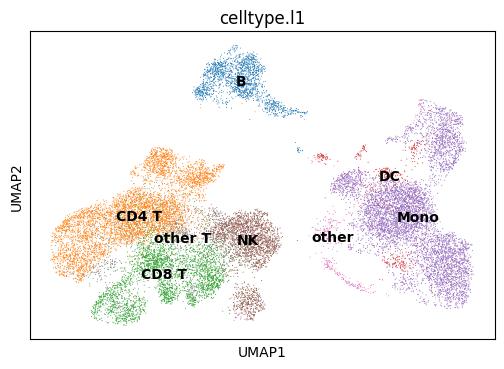

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


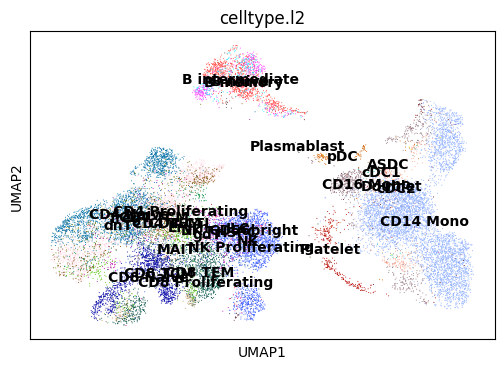

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


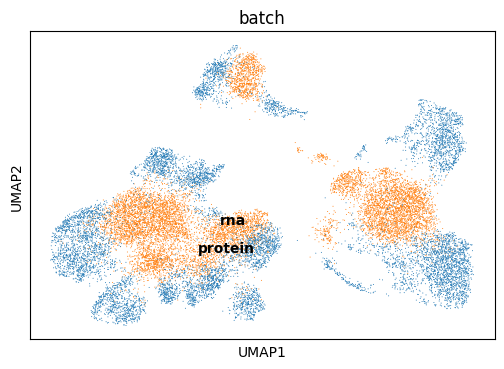

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.773,
lv2 matching acc: 0.540.
For All matchings: FOSCTTM score: 0.22337988, 
Knn Alignment score: [0.0011 0.0026 0.0035 0.0042 0.0055 0.0064 0.0076 0.0092 0.0103 0.0111
 0.012  0.0127 0.0135 0.0147 0.0156 0.0164 0.0173 0.018  0.0186 0.0195
 0.0202 0.0209 0.0224 0.0232 0.0239]
For All matchings: Silhouette F1 score for lv1: 0.5107961125349301, 
Silhouette F1 score for lv2: 0.49728956587715073



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  2.9509745836257935
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.839,
lv2 matching acc: 0.610.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.796,
lv2 matching acc: 0.570.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


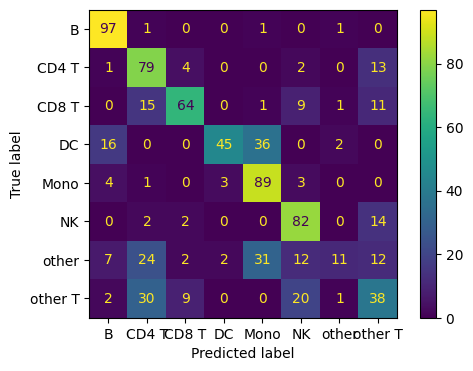

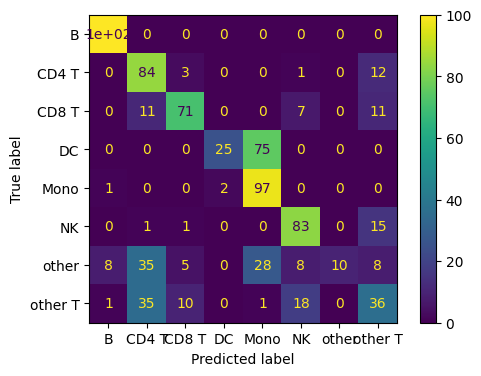

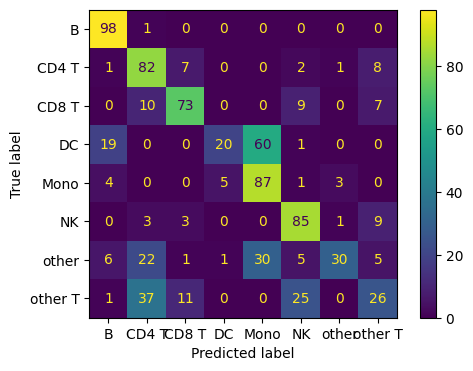

Epoch: 700: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 700: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.1465, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4848, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8044, Protein KL Div Z: 0.4990, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4656, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8029 Cross Loss Protein: 0.5410


Epoch: 701: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.1410, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4863, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8036, Protein KL Div Z: 0.4998, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4655, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8052 Cross Loss Protein: 0.5422


Epoch: 702: 40it [00:08,  4.59it/s]


RNA Recon Loss: 2.1338, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4859, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8024, Protein KL Div Z: 0.4986, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4666, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8035 Cross Loss Protein: 0.5416


Epoch: 703: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1491, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4866, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8024, Protein KL Div Z: 0.4981, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4662, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8028 Cross Loss Protein: 0.5406


Epoch: 704: 40it [00:09,  4.35it/s]


RNA Recon Loss: 2.1350, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4855, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8041, Protein KL Div Z: 0.4990, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4658, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5410


Epoch: 705: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1343, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4865, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8031, Protein KL Div Z: 0.4991, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4651, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8048 Cross Loss Protein: 0.5412


Epoch: 706: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1290, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4876, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8037, Protein KL Div Z: 0.4990, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4662, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8028 Cross Loss Protein: 0.5408


Epoch: 707: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1365, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4859, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8044, Protein KL Div Z: 0.4995, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4653, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5407


Epoch: 708: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1462, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4866, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8035, Protein KL Div Z: 0.4994, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4652, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8014 Cross Loss Protein: 0.5402


Epoch: 709: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1405, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4874, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8042, Protein KL Div Z: 0.4972, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4640, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8043 Cross Loss Protein: 0.5410


Epoch: 710: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1348, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4874, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8042, Protein KL Div Z: 0.4978, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4642, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8000 Cross Loss Protein: 0.5410


Epoch: 711: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1332, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4882, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8057, Protein KL Div Z: 0.4982, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4639, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8027 Cross Loss Protein: 0.5412


Epoch: 712: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1338, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4877, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8062, Protein KL Div Z: 0.4977, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4637, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8067 Cross Loss Protein: 0.5413


Epoch: 713: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1392, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4883, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8083, Protein KL Div Z: 0.4994, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4647, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8040 Cross Loss Protein: 0.5416


Epoch: 714: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1369, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4877, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8052, Protein KL Div Z: 0.4959, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4634, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8068 Cross Loss Protein: 0.5421


Epoch: 715: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1438, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4881, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8042, Protein KL Div Z: 0.4962, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4630, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8049 Cross Loss Protein: 0.5413


Epoch: 716: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1312, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4876, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8029, Protein KL Div Z: 0.4950, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4625, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8022 Cross Loss Protein: 0.5406


Epoch: 717: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1266, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4881, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8024, Protein KL Div Z: 0.4962, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4612, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8049 Cross Loss Protein: 0.5410


Epoch: 718: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1331, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4871, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8031, Protein KL Div Z: 0.4973, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4622, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8019 Cross Loss Protein: 0.5410


Epoch: 719: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1298, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4877, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8018, Protein KL Div Z: 0.4979, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4628, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8005 Cross Loss Protein: 0.5401


Epoch: 720: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1298, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4874, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8017, Protein KL Div Z: 0.4944, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4609, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8040 Cross Loss Protein: 0.5409


Epoch: 721: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1383, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4874, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8025, Protein KL Div Z: 0.4968, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4620, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5412


Epoch: 722: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1475, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4877, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8015, Protein KL Div Z: 0.4969, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4621, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8004 Cross Loss Protein: 0.5406


Epoch: 723: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1326, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4882, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8021, Protein KL Div Z: 0.4966, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4613, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8024 Cross Loss Protein: 0.5414


Epoch: 724: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1393, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4877, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8008, Protein KL Div Z: 0.4940, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4615, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8022 Cross Loss Protein: 0.5417


Epoch: 725: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1511, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4886, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8026, Protein KL Div Z: 0.4948, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4615, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8055 Cross Loss Protein: 0.5409


Epoch: 726: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1448, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4874, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8014, Protein KL Div Z: 0.4952, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4605, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8031 Cross Loss Protein: 0.5408


Epoch: 727: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1478, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4874, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8040, Protein KL Div Z: 0.4942, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4609, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8022 Cross Loss Protein: 0.5401


Epoch: 728: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1316, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4880, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8050, Protein KL Div Z: 0.4939, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4604, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8026 Cross Loss Protein: 0.5414


Epoch: 729: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1347, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4888, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.8064, Protein KL Div Z: 0.4930, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4616, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8026 Cross Loss Protein: 0.5420


Epoch: 730: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1321, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4878, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8044, Protein KL Div Z: 0.4917, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4613, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8011 Cross Loss Protein: 0.5398


Epoch: 731: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1362, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4885, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.8027, Protein KL Div Z: 0.4909, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4597, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8034 Cross Loss Protein: 0.5411


Epoch: 732: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1323, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4886, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8044, Protein KL Div Z: 0.4900, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4608, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8057 Cross Loss Protein: 0.5412


Epoch: 733: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1405, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4895, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8055, Protein KL Div Z: 0.4901, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4595, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8068 Cross Loss Protein: 0.5422


Epoch: 734: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1311, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4892, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8014, Protein KL Div Z: 0.4902, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4600, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8017 Cross Loss Protein: 0.5413


Epoch: 735: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1285, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4895, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8037, Protein KL Div Z: 0.4911, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4600, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.7987 Cross Loss Protein: 0.5400


Epoch: 736: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1306, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4886, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.7999, Protein KL Div Z: 0.4917, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4600, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8036 Cross Loss Protein: 0.5411


Epoch: 737: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1347, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4896, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8006, Protein KL Div Z: 0.4915, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4600, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8053 Cross Loss Protein: 0.5409


Epoch: 738: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1325, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4892, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.7991, Protein KL Div Z: 0.4919, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4583, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8007 Cross Loss Protein: 0.5405


Epoch: 739: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1439, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4884, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8029, Protein KL Div Z: 0.4931, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4591, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8022 Cross Loss Protein: 0.5413


Epoch: 740: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1431, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4909, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8030, Protein KL Div Z: 0.4911, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4584, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8014 Cross Loss Protein: 0.5417


Epoch: 741: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1246, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4903, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8076, Protein KL Div Z: 0.4915, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4593, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5412


Epoch: 742: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1327, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4905, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8058, Protein KL Div Z: 0.4906, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4581, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8015 Cross Loss Protein: 0.5407


Epoch: 743: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1351, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4907, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8069, Protein KL Div Z: 0.4923, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4589, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8018 Cross Loss Protein: 0.5412


Epoch: 744: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1339, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4910, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8047, Protein KL Div Z: 0.4917, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4577, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8027 Cross Loss Protein: 0.5411


Epoch: 745: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1259, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4904, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8087, Protein KL Div Z: 0.4922, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4587, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8027 Cross Loss Protein: 0.5411


Epoch: 746: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1293, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4906, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8076, Protein KL Div Z: 0.4927, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4584, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5406


Epoch: 747: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1383, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4909, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8070, Protein KL Div Z: 0.4933, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4587, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.7998 Cross Loss Protein: 0.5405


Epoch: 748: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1270, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4911, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8023, Protein KL Div Z: 0.4909, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4586, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8001 Cross Loss Protein: 0.5406


Epoch: 749: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1328, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4907, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8021, Protein KL Div Z: 0.4915, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4582, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8051 Cross Loss Protein: 0.5413


Epoch: 750: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1300, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4905, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.7995, Protein KL Div Z: 0.4905, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4590, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8032 Cross Loss Protein: 0.5412


Epoch: 751: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1262, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4901, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.7991, Protein KL Div Z: 0.4916, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4580, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8024 Cross Loss Protein: 0.5405


Epoch: 752: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1230, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4903, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.7978, Protein KL Div Z: 0.4898, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4570, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7996 Cross Loss Protein: 0.5403


Epoch: 753: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1306, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4901, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8017, Protein KL Div Z: 0.4893, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4576, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8008 Cross Loss Protein: 0.5411


Epoch: 754: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1356, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4908, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8025, Protein KL Div Z: 0.4904, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4571, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8004 Cross Loss Protein: 0.5413


Epoch: 755: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1296, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4898, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8020, Protein KL Div Z: 0.4882, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4570, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.7991 Cross Loss Protein: 0.5409


Epoch: 756: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1297, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4909, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8046, Protein KL Div Z: 0.4886, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4568, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8013 Cross Loss Protein: 0.5409


Epoch: 757: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1344, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4901, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8030, Protein KL Div Z: 0.4903, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4559, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5410


Epoch: 758: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1363, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4907, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.7974, Protein KL Div Z: 0.4886, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4561, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7980 Cross Loss Protein: 0.5400


Epoch: 759: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1246, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4911, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8012, Protein KL Div Z: 0.4889, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4565, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.7988 Cross Loss Protein: 0.5403


Epoch: 760: 40it [00:09,  4.40it/s]


RNA Recon Loss: 2.1362, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4925, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8003, Protein KL Div Z: 0.4889, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4563, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5413


Epoch: 761: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1286, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4918, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8105, Protein KL Div Z: 0.4911, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4560, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8030 Cross Loss Protein: 0.5423


Epoch: 762: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1298, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4919, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8079, Protein KL Div Z: 0.4899, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4544, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8053 Cross Loss Protein: 0.5421


Epoch: 763: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1290, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4906, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8009, Protein KL Div Z: 0.4869, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4547, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8035 Cross Loss Protein: 0.5409


Epoch: 764: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1239, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4911, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8001, Protein KL Div Z: 0.4881, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4565, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7993 Cross Loss Protein: 0.5412


Epoch: 765: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1272, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4909, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8027, Protein KL Div Z: 0.4883, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4556, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8004 Cross Loss Protein: 0.5404


Epoch: 766: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1308, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4911, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.8020, Protein KL Div Z: 0.4850, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4540, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8077 Cross Loss Protein: 0.5421


Epoch: 767: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1266, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4909, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8044, Protein KL Div Z: 0.4839, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4553, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8004 Cross Loss Protein: 0.5398


Epoch: 768: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1172, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4916, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8019, Protein KL Div Z: 0.4856, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4558, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5402


Epoch: 769: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1242, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4918, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8048, Protein KL Div Z: 0.4855, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4544, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.7994 Cross Loss Protein: 0.5410


Epoch: 770: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1349, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4915, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8026, Protein KL Div Z: 0.4836, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4546, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.7979 Cross Loss Protein: 0.5404


Epoch: 771: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1232, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4908, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8023, Protein KL Div Z: 0.4815, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4543, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7984 Cross Loss Protein: 0.5400


Epoch: 772: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1353, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4906, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8012, Protein KL Div Z: 0.4828, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4531, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8063 Cross Loss Protein: 0.5422


Epoch: 773: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1336, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4921, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8039, Protein KL Div Z: 0.4812, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4543, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.7988 Cross Loss Protein: 0.5400


Epoch: 774: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1217, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4920, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.7996, Protein KL Div Z: 0.4814, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4528, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8033 Cross Loss Protein: 0.5413


Epoch: 775: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1369, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4927, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.7996, Protein KL Div Z: 0.4824, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4533, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.7996 Cross Loss Protein: 0.5401


Epoch: 776: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1197, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4912, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.7991, Protein KL Div Z: 0.4827, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4538, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5416


Epoch: 777: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1335, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4905, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8047, Protein KL Div Z: 0.4836, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4540, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8012 Cross Loss Protein: 0.5406


Epoch: 778: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1258, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4910, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8044, Protein KL Div Z: 0.4825, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4539, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8023 Cross Loss Protein: 0.5409


Epoch: 779: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1161, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4918, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.7987, Protein KL Div Z: 0.4823, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4529, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7995 Cross Loss Protein: 0.5405


Epoch: 780: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1178, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4919, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8029, Protein KL Div Z: 0.4826, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4538, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.7997 Cross Loss Protein: 0.5409


Epoch: 781: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1263, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4919, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8020, Protein KL Div Z: 0.4832, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4537, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8019 Cross Loss Protein: 0.5405


Epoch: 782: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1199, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4923, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8039, Protein KL Div Z: 0.4843, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4530, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8044 Cross Loss Protein: 0.5418


Epoch: 783: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1341, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4916, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.7999, Protein KL Div Z: 0.4826, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4523, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8021 Cross Loss Protein: 0.5409


Epoch: 784: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1245, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4917, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8031, Protein KL Div Z: 0.4837, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4526, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5406


Epoch: 785: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1184, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4920, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8037, Protein KL Div Z: 0.4828, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4515, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8020 Cross Loss Protein: 0.5411


Epoch: 786: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1212, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4925, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.7996, Protein KL Div Z: 0.4818, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4513, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8056 Cross Loss Protein: 0.5414


Epoch: 787: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1426, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4925, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8012, Protein KL Div Z: 0.4797, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4506, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8034 Cross Loss Protein: 0.5418


Epoch: 788: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1357, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4925, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.7999, Protein KL Div Z: 0.4806, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4509, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8014 Cross Loss Protein: 0.5397


Epoch: 789: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1272, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4930, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8009, Protein KL Div Z: 0.4816, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4505, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8004 Cross Loss Protein: 0.5403


Epoch: 790: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1303, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4944, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8028, Protein KL Div Z: 0.4799, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4518, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.7984 Cross Loss Protein: 0.5406


Epoch: 791: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1311, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4941, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.7997, Protein KL Div Z: 0.4798, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4522, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8115 Cross Loss Protein: 0.5424


Epoch: 792: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1191, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4942, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8007, Protein KL Div Z: 0.4757, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4502, Shared Recon Loss Gene: 0.2618, Shared Recon Loss Protein: 1.8114 Cross Loss Protein: 0.5433


Epoch: 793: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1167, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4940, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.7994, Protein KL Div Z: 0.4758, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4495, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8026 Cross Loss Protein: 0.5410


Epoch: 794: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1265, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4934, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8054, Protein KL Div Z: 0.4781, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4511, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8049 Cross Loss Protein: 0.5415


Epoch: 795: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1284, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4940, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.7997, Protein KL Div Z: 0.4771, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4500, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8028 Cross Loss Protein: 0.5413


Epoch: 796: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1187, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4939, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8017, Protein KL Div Z: 0.4772, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4505, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8029 Cross Loss Protein: 0.5412


Epoch: 797: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1308, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4944, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8031, Protein KL Div Z: 0.4787, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4500, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8088 Cross Loss Protein: 0.5416


Epoch: 798: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1315, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4957, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8006, Protein KL Div Z: 0.4784, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4500, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8037 Cross Loss Protein: 0.5411


Epoch: 799: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1322, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4950, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8007, Protein KL Div Z: 0.4777, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4497, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8039 Cross Loss Protein: 0.5415


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


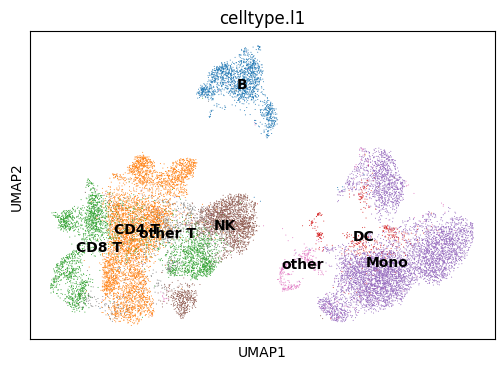

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


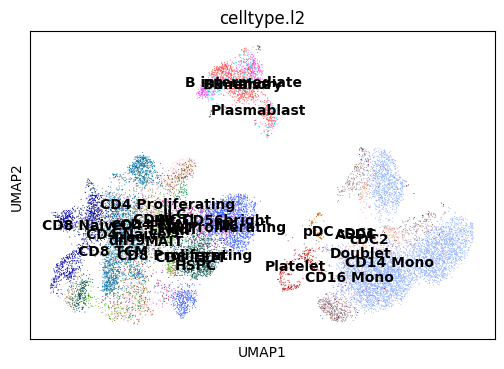

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


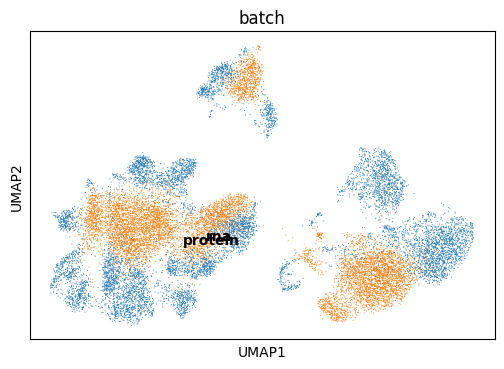

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.775,
lv2 matching acc: 0.556.
For All matchings: FOSCTTM score: 0.21713491, 
Knn Alignment score: [0.0013 0.0027 0.0042 0.0057 0.007  0.0085 0.0097 0.0106 0.0116 0.0128
 0.0135 0.0141 0.0151 0.0162 0.017  0.0176 0.0187 0.0197 0.0203 0.0209
 0.0213 0.0218 0.0231 0.0237 0.0244]
For All matchings: Silhouette F1 score for lv1: 0.5126101424161442, 
Silhouette F1 score for lv2: 0.49914485695501665



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  2.7630603313446045
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.853,
lv2 matching acc: 0.639.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.810,
lv2 matching acc: 0.577.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


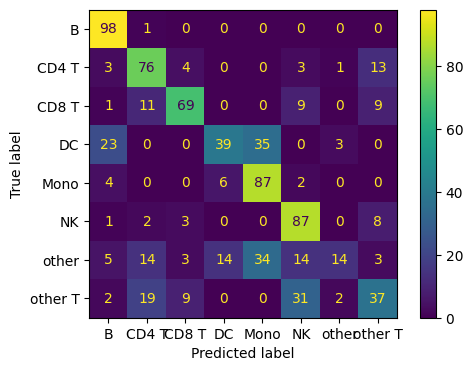

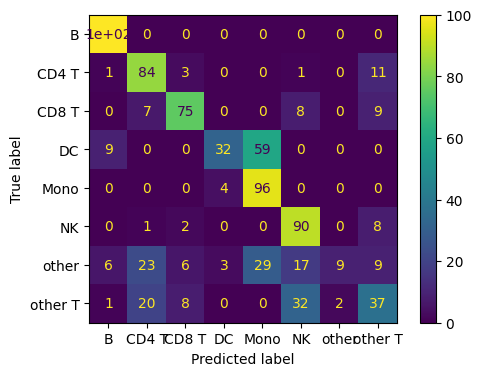

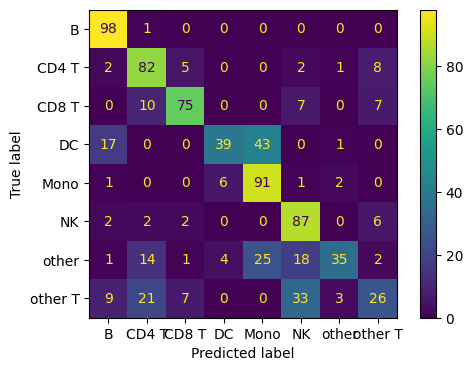

Epoch: 800: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 800: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1257, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4955, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8032, Protein KL Div Z: 0.4776, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4507, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7986 Cross Loss Protein: 0.5403


Epoch: 801: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1181, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4957, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8001, Protein KL Div Z: 0.4760, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4495, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8003 Cross Loss Protein: 0.5404


Epoch: 802: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1197, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4946, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8025, Protein KL Div Z: 0.4770, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4501, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8009 Cross Loss Protein: 0.5408


Epoch: 803: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1367, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4951, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8052, Protein KL Div Z: 0.4789, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4504, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8012 Cross Loss Protein: 0.5410


Epoch: 804: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1260, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4941, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8033, Protein KL Div Z: 0.4773, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4502, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8005 Cross Loss Protein: 0.5404


Epoch: 805: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1241, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4960, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.8014, Protein KL Div Z: 0.4762, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4497, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8075 Cross Loss Protein: 0.5423


Epoch: 806: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1199, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4953, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8071, Protein KL Div Z: 0.4731, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4492, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8102 Cross Loss Protein: 0.5425


Epoch: 807: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1151, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4958, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8040, Protein KL Div Z: 0.4749, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4499, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8019 Cross Loss Protein: 0.5407


Epoch: 808: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1166, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4952, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.7984, Protein KL Div Z: 0.4742, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4490, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5406


Epoch: 809: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1186, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4956, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8015, Protein KL Div Z: 0.4752, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4494, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.7971 Cross Loss Protein: 0.5399


Epoch: 810: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1248, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4958, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8004, Protein KL Div Z: 0.4740, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4497, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7982 Cross Loss Protein: 0.5400


Epoch: 811: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1285, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4958, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.7995, Protein KL Div Z: 0.4761, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4492, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.7976 Cross Loss Protein: 0.5404


Epoch: 812: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1223, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4965, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8002, Protein KL Div Z: 0.4765, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4493, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7991 Cross Loss Protein: 0.5403


Epoch: 813: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1228, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4954, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8007, Protein KL Div Z: 0.4761, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4489, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.7999 Cross Loss Protein: 0.5400


Epoch: 814: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1230, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4950, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.7988, Protein KL Div Z: 0.4763, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4478, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8019 Cross Loss Protein: 0.5412


Epoch: 815: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1309, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4965, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.7995, Protein KL Div Z: 0.4762, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4487, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.7976 Cross Loss Protein: 0.5396


Epoch: 816: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1160, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4955, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.7971, Protein KL Div Z: 0.4716, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4482, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7976 Cross Loss Protein: 0.5400


Epoch: 817: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1147, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4965, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8008, Protein KL Div Z: 0.4743, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4484, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7981 Cross Loss Protein: 0.5404


Epoch: 818: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1144, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4962, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8008, Protein KL Div Z: 0.4741, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4488, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8023 Cross Loss Protein: 0.5412


Epoch: 819: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1234, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4962, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8011, Protein KL Div Z: 0.4746, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4476, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8032 Cross Loss Protein: 0.5413


Epoch: 820: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1400, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4951, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8031, Protein KL Div Z: 0.4745, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4476, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8036 Cross Loss Protein: 0.5411


Epoch: 821: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1189, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4969, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8009, Protein KL Div Z: 0.4728, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4461, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8013 Cross Loss Protein: 0.5403


Epoch: 822: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1224, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4972, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.7985, Protein KL Div Z: 0.4732, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4479, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7983 Cross Loss Protein: 0.5402


Epoch: 823: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1282, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4969, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8024, Protein KL Div Z: 0.4733, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4471, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8018 Cross Loss Protein: 0.5405


Epoch: 824: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1185, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4984, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8015, Protein KL Div Z: 0.4712, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4470, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5410


Epoch: 825: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1215, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4984, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.7969, Protein KL Div Z: 0.4713, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4464, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8038 Cross Loss Protein: 0.5409


Epoch: 826: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1152, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4986, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8021, Protein KL Div Z: 0.4727, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4471, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8033 Cross Loss Protein: 0.5413


Epoch: 827: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1170, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4988, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.7997, Protein KL Div Z: 0.4740, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4459, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.7998 Cross Loss Protein: 0.5411


Epoch: 828: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1202, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4984, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.7975, Protein KL Div Z: 0.4728, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4456, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7995 Cross Loss Protein: 0.5405


Epoch: 829: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1197, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4990, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.7989, Protein KL Div Z: 0.4750, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4467, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7965 Cross Loss Protein: 0.5396


Epoch: 830: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1160, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4992, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.7989, Protein KL Div Z: 0.4730, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4460, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.7972 Cross Loss Protein: 0.5399


Epoch: 831: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1197, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4985, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8003, Protein KL Div Z: 0.4747, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4467, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.7987 Cross Loss Protein: 0.5406


Epoch: 832: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1199, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4992, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.7995, Protein KL Div Z: 0.4718, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4464, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8012 Cross Loss Protein: 0.5405


Epoch: 833: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1142, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4995, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8039, Protein KL Div Z: 0.4723, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4464, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.7990 Cross Loss Protein: 0.5402


Epoch: 834: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1129, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4987, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8036, Protein KL Div Z: 0.4729, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4453, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7977 Cross Loss Protein: 0.5413


Epoch: 835: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1139, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4987, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8088, Protein KL Div Z: 0.4736, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4460, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8009 Cross Loss Protein: 0.5400


Epoch: 836: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1130, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4983, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8048, Protein KL Div Z: 0.4739, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4455, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8042 Cross Loss Protein: 0.5419


Epoch: 837: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1073, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4982, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8042, Protein KL Div Z: 0.4726, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4458, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5414


Epoch: 838: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1100, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4978, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8015, Protein KL Div Z: 0.4700, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4447, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.7992 Cross Loss Protein: 0.5406


Epoch: 839: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1277, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4982, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8031, Protein KL Div Z: 0.4712, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4456, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8006 Cross Loss Protein: 0.5407


Epoch: 840: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1178, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4984, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8010, Protein KL Div Z: 0.4700, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4446, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.7983 Cross Loss Protein: 0.5398


Epoch: 841: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1142, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4986, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8013, Protein KL Div Z: 0.4682, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4449, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7974 Cross Loss Protein: 0.5402


Epoch: 842: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1197, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4983, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8007, Protein KL Div Z: 0.4691, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4448, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8000 Cross Loss Protein: 0.5403


Epoch: 843: 40it [00:09,  4.18it/s]


RNA Recon Loss: 2.1167, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4988, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.7967, Protein KL Div Z: 0.4691, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4442, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8013 Cross Loss Protein: 0.5408


Epoch: 844: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1185, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4979, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.7985, Protein KL Div Z: 0.4694, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4437, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8016 Cross Loss Protein: 0.5410


Epoch: 845: 40it [00:09,  4.31it/s]


RNA Recon Loss: 2.1182, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4993, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.7957, Protein KL Div Z: 0.4702, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4437, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.7998 Cross Loss Protein: 0.5400


Epoch: 846: 40it [00:09,  4.41it/s]


RNA Recon Loss: 2.1213, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5002, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.7974, Protein KL Div Z: 0.4705, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4438, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8015 Cross Loss Protein: 0.5408


Epoch: 847: 40it [00:09,  4.24it/s]


RNA Recon Loss: 2.1132, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4990, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8022, Protein KL Div Z: 0.4689, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4439, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7997 Cross Loss Protein: 0.5402


Epoch: 848: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1095, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4990, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.7965, Protein KL Div Z: 0.4693, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4436, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.7988 Cross Loss Protein: 0.5398


Epoch: 849: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1106, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4989, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.7995, Protein KL Div Z: 0.4713, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4435, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8006 Cross Loss Protein: 0.5411


Epoch: 850: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1320, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4974, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.7992, Protein KL Div Z: 0.4695, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4427, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7989 Cross Loss Protein: 0.5407


Epoch: 851: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1261, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5018, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8010, Protein KL Div Z: 0.4687, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4428, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.7998 Cross Loss Protein: 0.5402


Epoch: 852: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1113, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5005, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.7974, Protein KL Div Z: 0.4690, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4434, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8012 Cross Loss Protein: 0.5415


Epoch: 853: 40it [00:09,  4.43it/s]


RNA Recon Loss: 2.1134, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5002, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.7990, Protein KL Div Z: 0.4692, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4434, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7991 Cross Loss Protein: 0.5411


Epoch: 854: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1073, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5013, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8003, Protein KL Div Z: 0.4699, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4428, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7980 Cross Loss Protein: 0.5408


Epoch: 855: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1162, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5006, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8003, Protein KL Div Z: 0.4678, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4423, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8018 Cross Loss Protein: 0.5409


Epoch: 856: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1177, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4983, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.7999, Protein KL Div Z: 0.4681, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4435, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8021 Cross Loss Protein: 0.5413


Epoch: 857: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1085, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4999, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.7968, Protein KL Div Z: 0.4660, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4417, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8004 Cross Loss Protein: 0.5403


Epoch: 858: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1285, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5006, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.7988, Protein KL Div Z: 0.4677, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4428, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7976 Cross Loss Protein: 0.5400


Epoch: 859: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1380, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5012, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.7979, Protein KL Div Z: 0.4667, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4421, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8018 Cross Loss Protein: 0.5410


Epoch: 860: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1149, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5038, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.8054, Protein KL Div Z: 0.4664, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4422, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8049 Cross Loss Protein: 0.5423


Epoch: 861: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1157, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5031, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8032, Protein KL Div Z: 0.4655, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4418, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8009 Cross Loss Protein: 0.5399


Epoch: 862: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1035, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5029, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8059, Protein KL Div Z: 0.4676, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4419, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8021 Cross Loss Protein: 0.5419


Epoch: 863: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1238, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5034, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8000, Protein KL Div Z: 0.4658, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4407, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7990 Cross Loss Protein: 0.5403


Epoch: 864: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1157, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5037, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8030, Protein KL Div Z: 0.4677, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4418, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8003 Cross Loss Protein: 0.5401


Epoch: 865: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1225, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5038, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8011, Protein KL Div Z: 0.4661, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4410, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.7965 Cross Loss Protein: 0.5400


Epoch: 866: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1338, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5064, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8007, Protein KL Div Z: 0.4640, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4410, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.7992 Cross Loss Protein: 0.5396


Epoch: 867: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1295, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5068, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8036, Protein KL Div Z: 0.4662, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4404, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8030 Cross Loss Protein: 0.5409


Epoch: 868: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1132, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5050, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8033, Protein KL Div Z: 0.4634, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4401, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8065 Cross Loss Protein: 0.5420


Epoch: 869: 40it [00:09,  4.43it/s]


RNA Recon Loss: 2.1177, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5055, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8013, Protein KL Div Z: 0.4635, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4399, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.7982 Cross Loss Protein: 0.5403


Epoch: 870: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1169, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5055, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.7994, Protein KL Div Z: 0.4636, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4396, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8015 Cross Loss Protein: 0.5408


Epoch: 871: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1142, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5052, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8047, Protein KL Div Z: 0.4631, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4397, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8008 Cross Loss Protein: 0.5405


Epoch: 872: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1094, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5042, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8062, Protein KL Div Z: 0.4659, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4404, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.8024 Cross Loss Protein: 0.5407


Epoch: 873: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1075, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5050, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8021, Protein KL Div Z: 0.4652, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4401, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8025 Cross Loss Protein: 0.5418


Epoch: 874: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1102, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5053, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.7987, Protein KL Div Z: 0.4651, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4396, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7968 Cross Loss Protein: 0.5398


Epoch: 875: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1124, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5038, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.7982, Protein KL Div Z: 0.4645, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4402, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8006 Cross Loss Protein: 0.5402


Epoch: 876: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1142, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5051, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.7992, Protein KL Div Z: 0.4656, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4396, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8001 Cross Loss Protein: 0.5410


Epoch: 877: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1109, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5045, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8008, Protein KL Div Z: 0.4633, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4397, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.7997 Cross Loss Protein: 0.5409


Epoch: 878: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1184, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5048, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.7988, Protein KL Div Z: 0.4643, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4392, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8006 Cross Loss Protein: 0.5406


Epoch: 879: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1105, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5047, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.7997, Protein KL Div Z: 0.4648, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4392, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.8001 Cross Loss Protein: 0.5412


Epoch: 880: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1135, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5041, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8028, Protein KL Div Z: 0.4644, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4383, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8000 Cross Loss Protein: 0.5407


Epoch: 881: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1233, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5044, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8006, Protein KL Div Z: 0.4637, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4388, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.7967 Cross Loss Protein: 0.5396


Epoch: 882: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1158, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5046, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8013, Protein KL Div Z: 0.4635, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4382, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8000 Cross Loss Protein: 0.5405


Epoch: 883: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1060, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5059, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.7983, Protein KL Div Z: 0.4632, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4380, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.8042 Cross Loss Protein: 0.5418


Epoch: 884: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1146, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5045, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.7978, Protein KL Div Z: 0.4613, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4381, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8033 Cross Loss Protein: 0.5424


Epoch: 885: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1152, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5043, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.7987, Protein KL Div Z: 0.4612, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4380, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.7987 Cross Loss Protein: 0.5407


Epoch: 886: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1144, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5056, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8000, Protein KL Div Z: 0.4613, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4371, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.7997 Cross Loss Protein: 0.5397


Epoch: 887: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1282, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5048, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8022, Protein KL Div Z: 0.4619, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4393, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7997 Cross Loss Protein: 0.5397


Epoch: 888: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1095, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5058, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8007, Protein KL Div Z: 0.4618, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4373, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7982 Cross Loss Protein: 0.5407


Epoch: 889: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1043, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5056, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.7996, Protein KL Div Z: 0.4617, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4376, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7987 Cross Loss Protein: 0.5404


Epoch: 890: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1205, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5042, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8018, Protein KL Div Z: 0.4626, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4370, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7973 Cross Loss Protein: 0.5395


Epoch: 891: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1165, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5050, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8005, Protein KL Div Z: 0.4626, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4381, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7993 Cross Loss Protein: 0.5401


Epoch: 892: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1110, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5045, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8036, Protein KL Div Z: 0.4638, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4370, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7965 Cross Loss Protein: 0.5400


Epoch: 893: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1169, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5057, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8021, Protein KL Div Z: 0.4616, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4380, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7982 Cross Loss Protein: 0.5400


Epoch: 894: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1103, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5052, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.7989, Protein KL Div Z: 0.4595, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4378, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.7977 Cross Loss Protein: 0.5394


Epoch: 895: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1175, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5049, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.7996, Protein KL Div Z: 0.4612, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4378, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7977 Cross Loss Protein: 0.5402


Epoch: 896: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1124, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5056, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.7967, Protein KL Div Z: 0.4604, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4381, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.7979 Cross Loss Protein: 0.5408


Epoch: 897: 40it [00:09,  4.43it/s]


RNA Recon Loss: 2.1139, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5045, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.7996, Protein KL Div Z: 0.4607, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4367, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.7994 Cross Loss Protein: 0.5398


Epoch: 898: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1244, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5049, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.7990, Protein KL Div Z: 0.4610, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4384, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8085 Cross Loss Protein: 0.5419


Epoch: 899: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1148, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5043, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8007, Protein KL Div Z: 0.4592, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4353, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8022 Cross Loss Protein: 0.5416


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


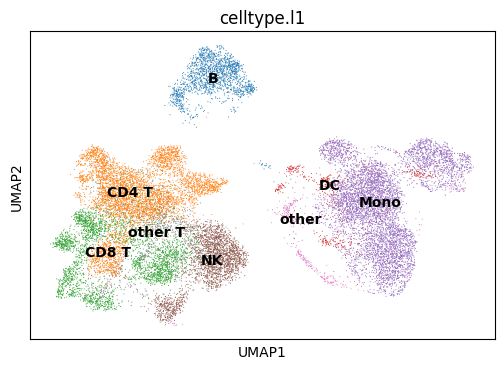

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


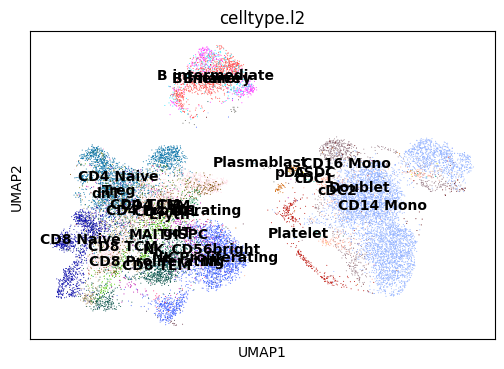

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


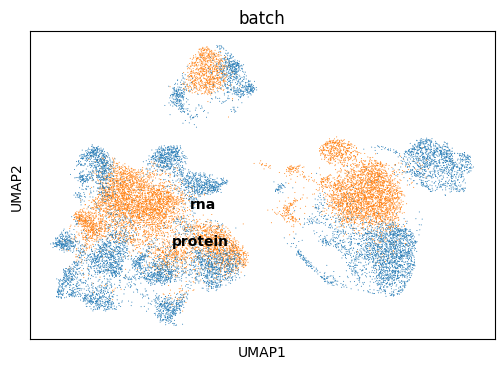

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.793,
lv2 matching acc: 0.573.
For All matchings: FOSCTTM score: 0.20192489, 
Knn Alignment score: [0.0013 0.0026 0.0037 0.0055 0.0069 0.0082 0.0096 0.0106 0.0111 0.0118
 0.0134 0.0146 0.0152 0.016  0.0167 0.0176 0.0193 0.0207 0.0214 0.0224
 0.0233 0.0241 0.0257 0.0263 0.0278]
For All matchings: Silhouette F1 score for lv1: 0.5167742810586624, 
Silhouette F1 score for lv2: 0.502206668124808



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  2.6288328170776367
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.862,
lv2 matching acc: 0.647.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.819,
lv2 matching acc: 0.589.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


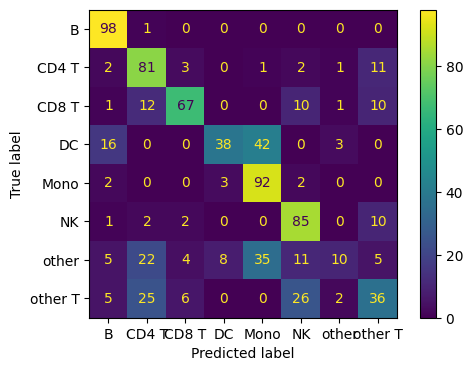

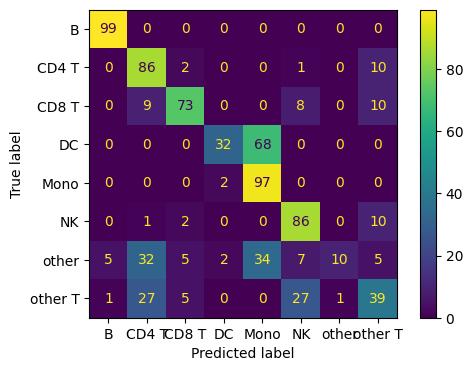

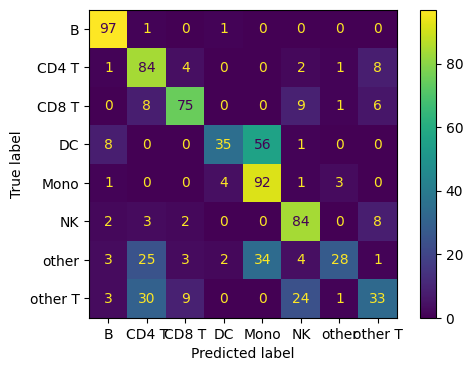

Epoch: 900: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 900: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.1158, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5038, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.7972, Protein KL Div Z: 0.4623, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4367, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.7986 Cross Loss Protein: 0.5400


Epoch: 901: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1141, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5048, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.7976, Protein KL Div Z: 0.4629, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4364, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8005 Cross Loss Protein: 0.5399


Epoch: 902: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1120, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5053, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.7989, Protein KL Div Z: 0.4627, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4364, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8000 Cross Loss Protein: 0.5401


Epoch: 903: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1097, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5044, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.7977, Protein KL Div Z: 0.4618, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4359, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.7986 Cross Loss Protein: 0.5398


Epoch: 904: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1089, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5046, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.7986, Protein KL Div Z: 0.4619, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4362, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.8024 Cross Loss Protein: 0.5412


Epoch: 905: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1082, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5046, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.7985, Protein KL Div Z: 0.4623, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4362, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8053 Cross Loss Protein: 0.5410


Epoch: 906: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1101, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5056, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.8020, Protein KL Div Z: 0.4621, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4370, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5407


Epoch: 907: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1087, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5051, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8060, Protein KL Div Z: 0.4572, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4363, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.8006 Cross Loss Protein: 0.5409


Epoch: 908: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1063, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5052, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8008, Protein KL Div Z: 0.4580, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4369, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7980 Cross Loss Protein: 0.5396


Epoch: 909: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1020, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5051, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8006, Protein KL Div Z: 0.4579, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4353, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7993 Cross Loss Protein: 0.5405


Epoch: 910: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1188, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5048, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.7974, Protein KL Div Z: 0.4590, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4364, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.7993 Cross Loss Protein: 0.5399


Epoch: 911: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1143, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5052, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.7974, Protein KL Div Z: 0.4589, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4360, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8014 Cross Loss Protein: 0.5404


Epoch: 912: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1039, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5048, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.7952, Protein KL Div Z: 0.4594, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4354, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7984 Cross Loss Protein: 0.5397


Epoch: 913: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1070, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5050, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.7969, Protein KL Div Z: 0.4605, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4351, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.8010 Cross Loss Protein: 0.5398


Epoch: 914: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1123, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5050, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.7970, Protein KL Div Z: 0.4597, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4352, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5409


Epoch: 915: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1073, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5063, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.7989, Protein KL Div Z: 0.4599, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4354, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7987 Cross Loss Protein: 0.5392


Epoch: 916: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1221, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5063, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.7986, Protein KL Div Z: 0.4594, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4364, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8024 Cross Loss Protein: 0.5411


Epoch: 917: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1136, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5071, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8016, Protein KL Div Z: 0.4591, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4349, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8032 Cross Loss Protein: 0.5411


Epoch: 918: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1074, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5075, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8007, Protein KL Div Z: 0.4586, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4351, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.7980 Cross Loss Protein: 0.5391


Epoch: 919: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1154, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5068, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8011, Protein KL Div Z: 0.4589, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4352, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7960 Cross Loss Protein: 0.5400


Epoch: 920: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1092, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5072, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8011, Protein KL Div Z: 0.4602, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4351, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.7979 Cross Loss Protein: 0.5399


Epoch: 921: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1081, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5070, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.7979, Protein KL Div Z: 0.4598, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4354, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.7977 Cross Loss Protein: 0.5393


Epoch: 922: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1096, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5082, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8001, Protein KL Div Z: 0.4594, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4346, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.7990 Cross Loss Protein: 0.5397


Epoch: 923: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1087, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5085, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8026, Protein KL Div Z: 0.4603, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4357, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.7996 Cross Loss Protein: 0.5411


Epoch: 924: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1072, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5061, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8006, Protein KL Div Z: 0.4584, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4344, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7980 Cross Loss Protein: 0.5406


Epoch: 925: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1047, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5079, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8018, Protein KL Div Z: 0.4582, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4347, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7985 Cross Loss Protein: 0.5399


Epoch: 926: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1170, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5084, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8017, Protein KL Div Z: 0.4588, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4344, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.7976 Cross Loss Protein: 0.5395


Epoch: 927: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1122, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5072, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.7994, Protein KL Div Z: 0.4590, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4344, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.7976 Cross Loss Protein: 0.5400


Epoch: 928: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1012, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5075, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.7973, Protein KL Div Z: 0.4577, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4339, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7997 Cross Loss Protein: 0.5404


Epoch: 929: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.0989, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5080, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8006, Protein KL Div Z: 0.4593, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4345, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7986 Cross Loss Protein: 0.5404


Epoch: 930: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1021, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5078, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8004, Protein KL Div Z: 0.4595, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4336, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7950 Cross Loss Protein: 0.5396


Epoch: 931: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1137, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5089, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.7982, Protein KL Div Z: 0.4582, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4334, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5418


Epoch: 932: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1106, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5082, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8015, Protein KL Div Z: 0.4592, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4339, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7979 Cross Loss Protein: 0.5397


Epoch: 933: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1035, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5078, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8004, Protein KL Div Z: 0.4593, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4336, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7977 Cross Loss Protein: 0.5401


Epoch: 934: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1007, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5080, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8004, Protein KL Div Z: 0.4567, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4335, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7986 Cross Loss Protein: 0.5395


Epoch: 935: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1226, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5089, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.7998, Protein KL Div Z: 0.4566, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4333, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7990 Cross Loss Protein: 0.5424


Epoch: 936: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1115, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5082, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8043, Protein KL Div Z: 0.4590, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4343, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8030 Cross Loss Protein: 0.5421


Epoch: 937: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1025, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5094, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8024, Protein KL Div Z: 0.4581, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4341, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7989 Cross Loss Protein: 0.5408


Epoch: 938: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.0974, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5084, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.7982, Protein KL Div Z: 0.4573, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4341, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.8008 Cross Loss Protein: 0.5407


Epoch: 939: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1089, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5095, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.7979, Protein KL Div Z: 0.4559, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4327, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.7989 Cross Loss Protein: 0.5401


Epoch: 940: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1137, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5093, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.7986, Protein KL Div Z: 0.4557, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4333, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8003 Cross Loss Protein: 0.5406


Epoch: 941: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1017, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5080, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.7988, Protein KL Div Z: 0.4575, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4329, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7962 Cross Loss Protein: 0.5396


Epoch: 942: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1135, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5094, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.7983, Protein KL Div Z: 0.4571, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4321, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7994 Cross Loss Protein: 0.5407


Epoch: 943: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1010, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5090, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8029, Protein KL Div Z: 0.4578, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4319, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7981 Cross Loss Protein: 0.5396


Epoch: 944: 40it [00:09,  4.40it/s]


RNA Recon Loss: 2.1056, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5085, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.7956, Protein KL Div Z: 0.4552, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4319, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.7994 Cross Loss Protein: 0.5397


Epoch: 945: 40it [00:09,  4.43it/s]


RNA Recon Loss: 2.1005, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5084, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8000, Protein KL Div Z: 0.4549, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4318, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.8014 Cross Loss Protein: 0.5409


Epoch: 946: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1086, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5097, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.7994, Protein KL Div Z: 0.4539, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4327, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7983 Cross Loss Protein: 0.5401


Epoch: 947: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1046, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5086, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8009, Protein KL Div Z: 0.4546, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4320, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7994 Cross Loss Protein: 0.5398


Epoch: 948: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1041, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5093, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8033, Protein KL Div Z: 0.4566, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4326, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.8004 Cross Loss Protein: 0.5399


Epoch: 949: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1070, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5091, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8006, Protein KL Div Z: 0.4543, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4316, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.7960 Cross Loss Protein: 0.5398


Epoch: 950: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1092, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5083, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8024, Protein KL Div Z: 0.4541, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4320, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7994 Cross Loss Protein: 0.5404


Epoch: 951: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1082, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5101, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8021, Protein KL Div Z: 0.4538, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4315, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7964 Cross Loss Protein: 0.5403


Epoch: 952: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1033, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5099, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.7970, Protein KL Div Z: 0.4538, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4301, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7997 Cross Loss Protein: 0.5404


Epoch: 953: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1118, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5089, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8012, Protein KL Div Z: 0.4554, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4312, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7993 Cross Loss Protein: 0.5405


Epoch: 954: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1018, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5091, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8010, Protein KL Div Z: 0.4519, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4302, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7968 Cross Loss Protein: 0.5392


Epoch: 955: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1066, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5093, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.7974, Protein KL Div Z: 0.4494, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4314, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7996 Cross Loss Protein: 0.5400


Epoch: 956: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1118, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5089, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8010, Protein KL Div Z: 0.4516, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4302, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8035 Cross Loss Protein: 0.5404


Epoch: 957: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1050, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5087, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8019, Protein KL Div Z: 0.4519, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4312, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8062 Cross Loss Protein: 0.5409


Epoch: 958: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.1032, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5099, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8026, Protein KL Div Z: 0.4516, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4308, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7992 Cross Loss Protein: 0.5399


Epoch: 959: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1036, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5088, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.7970, Protein KL Div Z: 0.4489, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4300, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7988 Cross Loss Protein: 0.5396


Epoch: 960: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1016, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5088, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.7975, Protein KL Div Z: 0.4503, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4301, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.7966 Cross Loss Protein: 0.5392


Epoch: 961: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1093, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5096, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.7981, Protein KL Div Z: 0.4509, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4303, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7981 Cross Loss Protein: 0.5400


Epoch: 962: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1005, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5084, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.7936, Protein KL Div Z: 0.4501, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4298, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7977 Cross Loss Protein: 0.5399


Epoch: 963: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1036, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5076, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.7984, Protein KL Div Z: 0.4506, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4296, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7961 Cross Loss Protein: 0.5397


Epoch: 964: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1024, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5094, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.7987, Protein KL Div Z: 0.4508, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4301, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5404


Epoch: 965: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1076, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5089, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8010, Protein KL Div Z: 0.4512, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4296, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8006 Cross Loss Protein: 0.5403


Epoch: 966: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.0992, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5093, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.7974, Protein KL Div Z: 0.4496, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4291, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7965 Cross Loss Protein: 0.5398


Epoch: 967: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1081, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5083, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.7994, Protein KL Div Z: 0.4502, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4293, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7979 Cross Loss Protein: 0.5401


Epoch: 968: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1009, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5097, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8007, Protein KL Div Z: 0.4506, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4292, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.8002 Cross Loss Protein: 0.5407


Epoch: 969: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1029, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5089, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8032, Protein KL Div Z: 0.4503, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4287, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7973 Cross Loss Protein: 0.5399


Epoch: 970: 40it [00:09,  4.41it/s]


RNA Recon Loss: 2.1011, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5096, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8015, Protein KL Div Z: 0.4477, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4286, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7983 Cross Loss Protein: 0.5402


Epoch: 971: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1038, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5088, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8017, Protein KL Div Z: 0.4482, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4282, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.7961 Cross Loss Protein: 0.5398


Epoch: 972: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1013, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5111, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8012, Protein KL Div Z: 0.4488, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4284, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.7990 Cross Loss Protein: 0.5405


Epoch: 973: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.0953, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5105, Protein Recon Loss: 0.4863, Protein KL Div Back Pro: 0.7980, Protein KL Div Z: 0.4497, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4287, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.8000 Cross Loss Protein: 0.5400


Epoch: 974: 40it [00:09,  4.33it/s]


RNA Recon Loss: 2.1024, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5100, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.7996, Protein KL Div Z: 0.4511, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4284, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.7989 Cross Loss Protein: 0.5401


Epoch: 975: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1104, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5112, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.7964, Protein KL Div Z: 0.4479, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4278, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7975 Cross Loss Protein: 0.5414


Epoch: 976: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.1220, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5072, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8034, Protein KL Div Z: 0.4457, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4282, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7970 Cross Loss Protein: 0.5397


Epoch: 977: 40it [00:08,  4.54it/s]


RNA Recon Loss: 2.1066, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5097, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8025, Protein KL Div Z: 0.4475, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4286, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.7968 Cross Loss Protein: 0.5392


Epoch: 978: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1072, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5109, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.8036, Protein KL Div Z: 0.4490, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4284, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.7991 Cross Loss Protein: 0.5481


Epoch: 979: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.0973, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5121, Protein Recon Loss: 0.4909, Protein KL Div Back Pro: 0.8100, Protein KL Div Z: 0.4495, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4280, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8116 Cross Loss Protein: 0.5463


Epoch: 980: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.0952, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5119, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8093, Protein KL Div Z: 0.4488, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4277, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8026 Cross Loss Protein: 0.5421


Epoch: 981: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1013, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5126, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8085, Protein KL Div Z: 0.4497, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4282, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7995 Cross Loss Protein: 0.5408


Epoch: 982: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.0957, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5119, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8038, Protein KL Div Z: 0.4495, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4284, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7986 Cross Loss Protein: 0.5404


Epoch: 983: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.0972, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5122, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8046, Protein KL Div Z: 0.4502, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4277, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7965 Cross Loss Protein: 0.5396


Epoch: 984: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1029, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5129, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8034, Protein KL Div Z: 0.4488, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4273, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8039 Cross Loss Protein: 0.5413


Epoch: 985: 40it [00:08,  4.49it/s]


RNA Recon Loss: 2.0989, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5125, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8069, Protein KL Div Z: 0.4474, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4278, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8017 Cross Loss Protein: 0.5412


Epoch: 986: 40it [00:09,  4.44it/s]


RNA Recon Loss: 2.1100, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5129, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8056, Protein KL Div Z: 0.4466, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4276, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8006 Cross Loss Protein: 0.5412


Epoch: 987: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1016, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5131, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.7978, Protein KL Div Z: 0.4462, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4269, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.7976 Cross Loss Protein: 0.5402


Epoch: 988: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.1006, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5130, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.7994, Protein KL Div Z: 0.4477, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4271, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8000 Cross Loss Protein: 0.5409


Epoch: 989: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1041, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5111, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8009, Protein KL Div Z: 0.4485, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4268, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7987 Cross Loss Protein: 0.5406


Epoch: 990: 40it [00:09,  4.40it/s]


RNA Recon Loss: 2.0981, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5129, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.7999, Protein KL Div Z: 0.4483, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4266, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8011 Cross Loss Protein: 0.5411


Epoch: 991: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.0967, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5131, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.7967, Protein KL Div Z: 0.4470, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4273, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.8011 Cross Loss Protein: 0.5409


Epoch: 992: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1031, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5123, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.7997, Protein KL Div Z: 0.4489, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4273, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7969 Cross Loss Protein: 0.5401


Epoch: 993: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.0979, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5131, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8002, Protein KL Div Z: 0.4485, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4262, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7982 Cross Loss Protein: 0.5405


Epoch: 994: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.0970, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5121, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.7983, Protein KL Div Z: 0.4469, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4267, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.8011 Cross Loss Protein: 0.5418


Epoch: 995: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.1116, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5127, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8016, Protein KL Div Z: 0.4477, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4275, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7992 Cross Loss Protein: 0.5397


Epoch: 996: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1199, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5122, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8004, Protein KL Div Z: 0.4455, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4261, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7983 Cross Loss Protein: 0.5404


Epoch: 997: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.1050, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5152, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8010, Protein KL Div Z: 0.4462, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4266, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.7987 Cross Loss Protein: 0.5402


Epoch: 998: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.1122, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5141, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8014, Protein KL Div Z: 0.4450, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4267, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7960 Cross Loss Protein: 0.5402


Epoch: 999: 40it [00:09,  4.34it/s]


RNA Recon Loss: 2.1047, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5148, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.7960, Protein KL Div Z: 0.4443, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4263, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.8010 Cross Loss Protein: 0.5409


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


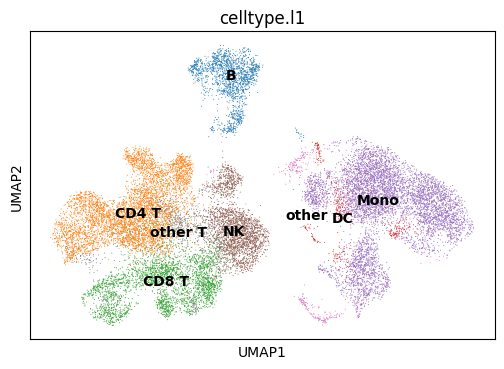

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


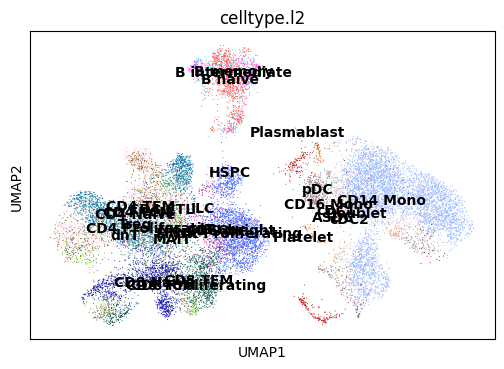

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


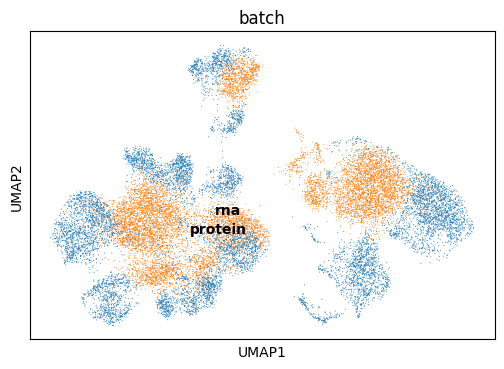

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.791,
lv2 matching acc: 0.567.
For All matchings: FOSCTTM score: 0.20769325, 
Knn Alignment score: [0.0015 0.0028 0.0039 0.0046 0.0057 0.0073 0.0086 0.0104 0.0113 0.0119
 0.0133 0.0144 0.0154 0.0162 0.0168 0.0183 0.0192 0.0199 0.0208 0.0215
 0.022  0.0232 0.0242 0.0246 0.0257]
For All matchings: Silhouette F1 score for lv1: 0.5153059721966334, 
Silhouette F1 score for lv2: 0.501392278964088



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  2.509016513824463
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.863,
lv2 matching acc: 0.647.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.804,
lv2 matching acc: 0.574.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


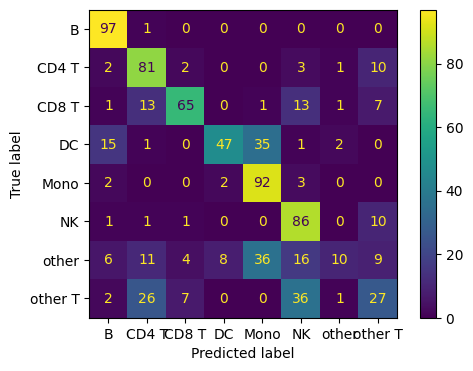

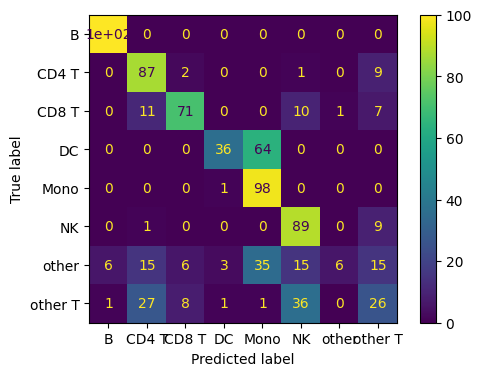

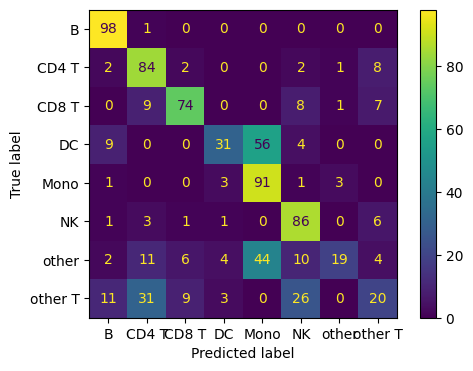

Epoch: 1000: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_15584\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 1000: 40it [00:08,  4.56it/s]

RNA Recon Loss: 2.1062, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5146, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.7984, Protein KL Div Z: 0.4456, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4260, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8037 Cross Loss Protein: 0.5417


In [34]:
kl_weight = 0.0
metrics = {
    'original': {
        'lv1_acc': [],
        'lv2_acc': [],
        'foscttm_score': []
    },
    'filtered':{
        'lv1_acc': [],
        'lv2_acc': [],
        'foscttm_score': []
    },
    'propagated':{
        'lv1_acc': [],
        'lv2_acc': [],
        'foscttm_score': []
    }
}
for epoch in range(2001):
    loss = 0.0
    rna_recon_loss_piter = 0.0
    rna_kl_div_l_piter = 0.0
    rna_kl_div_z_piter = 0.0
    pro_recon_loss_piter = 0.0
    pro_kl_div_back_pro_piter = 0.0
    pro_kl_div_z_piter = 0.0
    shared_recon_loss1_piter = 0.0
    shared_recon_loss2_piter = 0.0
    shared_kl_div_z_piter = 0.0
    loss_emb_r1_piter = 0.0
    loss_emb_r2_piter = 0.0
    loss_emb_p1_piter = 0.0
    loss_emb_p2_piter = 0.0
    cross_loss_pro_piter = 0.0
    for batchr, batchp in tqdm(zip(rna_dataloader, protein_dataloader), desc="Epoch: {}".format(epoch)):
        optimizer_p.zero_grad()
        optimizer_r.zero_grad()
        optimizer_pr.zero_grad()
        
        y_shared = batchp["y_shared"].to(device)
        x_shared = batchr["x_shared"].to(device)
        y_unshared = batchp["y_unshared"].to(device)
        x_unshared = batchr["x_unshared"].to(device)
        x_batch = batchr["batch"].to(device)
        y_batch = batchp["batch"].to(device)
        # local_mean = rna_dataset.local_mean.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        # local_var = rna_dataset.local_var.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        local_mean = batchr["mean"].to(device)
        local_var = batchr["var"].to(device)
        
        gene_size = x_shared.size(0)
        ## forward pass of unshared network of proteins and rna
        pro_recon_loss, pro_kl_div_z, pro_kl_div_back_pro, z_pro, _ = podel(y_unshared,cross_inf = False)
        rna_recon_loss, rna_kl_div_l, rna_kl_div_z, z_rna, _ = rodel(x_unshared, local_mean, local_var, cross_inf = False)
        unshared_protein_loss = torch.mean(pro_recon_loss) + 0.001*torch.mean(pro_kl_div_z) + 0.001*torch.mean(pro_kl_div_back_pro)
        unshared_rna_loss = torch.mean(rna_recon_loss) + 0.001*torch.mean(rna_kl_div_l) + 0.001*torch.mean(rna_kl_div_z)
        with torch.no_grad():
            _, _, _, _, _, z_gene, z_protein, _ = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf = False)
        loss_embedd_p = CLIP_loss(z_protein, z_pro)
        loss_embedd_r = CLIP_loss(z_gene, z_rna)
        loss_pro = unshared_protein_loss + loss_embedd_p
        loss_rna = unshared_rna_loss + loss_embedd_r
        loss_rna.backward()
        optimizer_r.step()
        loss_pro.backward()
        optimizer_p.step()
        
        # update losses: 
        rna_recon_loss_piter += torch.mean(rna_recon_loss).item()
        rna_kl_div_l_piter += torch.mean(rna_kl_div_l).item()
        rna_kl_div_z_piter += torch.mean(rna_kl_div_z).item()
        pro_recon_loss_piter += torch.mean(pro_recon_loss).item()
        pro_kl_div_back_pro_piter += torch.mean(pro_kl_div_back_pro).item()
        pro_kl_div_z_piter += torch.mean(pro_kl_div_z).item()
        loss_emb_p1_piter += torch.mean(loss_embedd_p).item()
        loss_emb_r1_piter += torch.mean(loss_embedd_r).item()
    
        # forward pass of shared_network
        reconst_loss_gene, reconst_loss_protein, kl_div_z, kl_div_l_gene, kl_div_back_pro, z_gene, z_protein, _ = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf=False)
        shared_loss = torch.mean(reconst_loss_gene) + torch.mean(reconst_loss_protein) + 0.001*torch.mean(kl_div_z) + 0.001*torch.mean(kl_div_l_gene) + 0.001*torch.mean(kl_div_back_pro)
        with torch.no_grad():
            _, _, _, z_pro, _ = podel(y_unshared, cross_inf=False)
            _, _, _, z_rna, _ = rodel(x_unshared,local_mean,local_var, cross_inf=False)
        loss_embedd_p = CLIP_loss(z_protein, z_pro)
        loss_embedd_r = CLIP_loss(z_gene, z_rna)
        loss = shared_loss + loss_embedd_p + loss_embedd_r
        loss.backward()
        optimizer_pr.step()
        shared_kl_div_z_piter += torch.mean(kl_div_z).item()
        shared_recon_loss1_piter += torch.mean(reconst_loss_gene).item()
        shared_recon_loss2_piter += torch.mean(reconst_loss_protein).item()
        
        if epoch>1:
            # optimizer_p.zero_grad()
            optimizer_r.zero_grad()
            optimizer_pr.zero_grad()
            # cross network training
            _, _, _, _, _, z_gene, z_protein, para_out_prodel = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf = False)
            pro_recon_loss, _, _, _, _ = podel(y_unshared,cross_inf = True, para = get_paras_for_podel(para_out_prodel, gene_size))
            # rna_recon_loss, _, _, _, _ = rodel(x_unshared, local_mean, local_var, cross_inf = True, para = get_paras_for_rodel(para_out_prodel, gene_size))
            cross_loss_podel = torch.mean(pro_recon_loss)
            # print("rna_recon_loss: ", rna_recon_loss)
            # print("pro_recon_loss: ", pro_recon_loss)
            # cross_loss_rodel = torch.mean(rna_recon_loss)
            # cross_loss_rodel.backward(retain_graph=True)
            # optimizer_r.step()
            cross_loss_podel.backward(retain_graph=True)
            optimizer_p.step()
            optimizer_pr.step()
            cross_loss_pro_piter += cross_loss_podel.item()
            
            # with torch.no_grad():
            #     _, _, _, z_pro, para_out_podel = podel(y_unshared, cross_inf=False)
            #     _, _, _, z_rna, para_out_rodel = rodel(x_unshared,local_mean,local_var, cross_inf=False)
            # recon_loss_prodel, _, _, _, _, _, _, _ = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf = True, para = get_paras_for_prodel(para_out_rodel, para_out_podel, gene_size))
            # cross_loss_prodel = torch.mean(recon_loss_prodel)
            # cross_loss_prodel.backward()
            # optimizer_pr.step()
         
    kl_weight = min(1.0,(epoch+1)/1000)  
    print(f"RNA Recon Loss: {rna_recon_loss_piter / 10000:.4f}, "
      f"RNA KL Div L: {rna_kl_div_l_piter / 10000:.4f}, "
      f"RNA KL Div Z: {rna_kl_div_z_piter / 10000:.4f}, "
      f"Protein Recon Loss: {pro_recon_loss_piter / 10000:.4f}, "
      f"Protein KL Div Back Pro: {pro_kl_div_back_pro_piter / 10000:.4f}, "
      f"Protein KL Div Z: {pro_kl_div_z_piter / 10000:.4f}, "
      f"Embedding Loss P1: {loss_emb_p1_piter / 10000:.4f}, "
      f"Embedding Loss R1: {loss_emb_r1_piter / 10000:.4f}, "
      f"Shared KL Div Z: {shared_kl_div_z_piter / 10000:.4f}, "
      f"Shared Recon Loss Gene: {shared_recon_loss1_piter / 10000:.4f}, "
      f"Shared Recon Loss Protein: {shared_recon_loss2_piter / 10000:.4f}",
         f"Cross Loss Protein: {cross_loss_pro_piter/10000:.4f}")
    if (epoch+1) % 100 == 0:
        """Testing loop and visualisation saving"""
        with torch.no_grad():
            shared_rna_data = torch.Tensor(rna_dataset.shared_data)
            shared_pro_data = torch.Tensor(protein_dataset.shared_data)
            labelsl1 = rna_dataset.labels_l1
            labelsl2 = rna_dataset.labels_l2
            shared_tensor_mean = torch.Tensor(rna_dataset.local_mean).to(device)
            shared_tensor_var = torch.Tensor(rna_dataset.local_var).to(device)
            x_batch = torch.Tensor(rna_dataset.batch).to(device)
            y_batch = torch.Tensor(protein_dataset.batch).to(device)
            _, _, _, _, _, z_gene, z_pro, _ = prodel(shared_rna_data, shared_pro_data, shared_tensor_mean, shared_tensor_var, x_batch, y_batch, cross_inf=False)
            adata_plot = ad.AnnData(X= np.concatenate([z_gene.numpy(), z_pro.numpy()], axis=0))
            adata_plot.obs['celltype.l1'] = np.concatenate([labelsl1,labels_l1], axis=0)
            adata_plot.obs['celltype.l2'] = np.concatenate([labelsl2,labels_l2], axis=0)
            adata_plot.obs['batch'] = np.concatenate([["rna"]*z_gene.shape[0], ["protein"]*z_pro.shape[0]], axis=0)
            sc.pp.neighbors(adata_plot)
            sc.tl.umap(adata_plot)
            sc.pl.umap(adata_plot, color='celltype.l1', legend_loc='on data', s=2)            
            sc.pl.umap(adata_plot, color='celltype.l2', legend_loc='on data', s=2)
            sc.pl.umap(adata_plot, color='batch', legend_loc='on data', s=2)            
            met = mu.get_all_metrics(z_gene, z_pro, labelsl1, labelsl2, dim_use = 20, k_max=25, metric='euclidean', assignment_type='mindist', filter_prop=0.5, verbose=True)
            metrics['original']['lv1_acc'].append(met['original']['lv1_acc'])
            metrics['original']['lv2_acc'].append(met['original']['lv2_acc'])
            metrics['original']['foscttm_score'].append(met['original']['foscttm_score'])
            metrics['filtered']['lv1_acc'].append(met['filtered']['lv1_acc'])
            metrics['filtered']['lv2_acc'].append(met['filtered']['lv2_acc'])
            metrics['filtered']['foscttm_score'].append(met['filtered']['foscttm_score'])
            metrics['propagated']['lv1_acc'].append(met['propagated']['lv1_acc'])
            metrics['propagated']['lv2_acc'].append(met['propagated']['lv2_acc'])
            metrics['propagated']['foscttm_score'].append(met['propagated']['foscttm_score'])

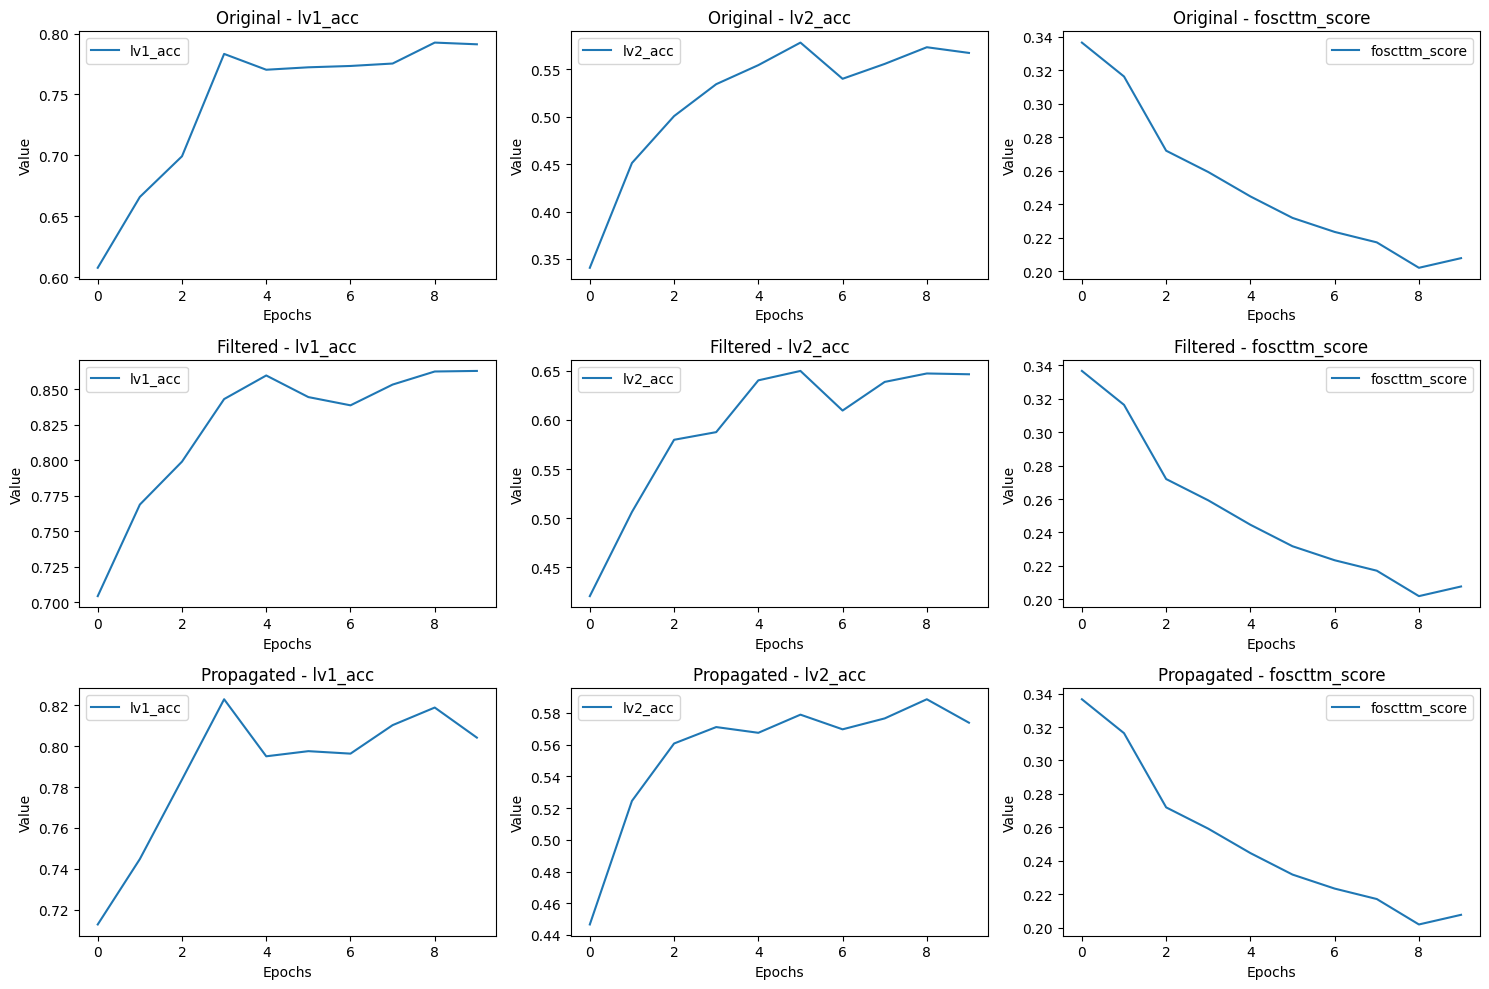

In [35]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot each metric on a separate subfigure
for i, (category, submetrics) in enumerate(metrics.items()):
    for j, (metric_name, values) in enumerate(submetrics.items()):
        ax = axs[i, j]
        ax.plot(values, label=metric_name)
        ax.set_title(f'{category.capitalize()} - {metric_name}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Value')
        ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()